### Prova RMC

Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci

import os
import pandas as pd
from ase.io import rmc6f
from ase.io import cfg
from ase.visualize import view
from ase.visualize import ngl


from ase import Atoms
from ase.neighborlist import NeighborList

from ase.neighborlist import neighbor_list

os.chdir('/home/ziglio/Desktop/thesis/RMC/RMCProfile/Simulations/Prova/350K/')



Functions to import .dat files and function to obtain errors with one significant figure and the associated measurement with the least significant figure as the one of the eerror

In [3]:
def read_dat_file(filename,skip):
    data = np.loadtxt(filename+'.dat',skiprows= skip,encoding='unicode_escape') #utf-8-sig')
    col = []
    num = len(data.transpose())
    for i in range(num):
        if num == len(data):
            col1 = data[i]
        else:
            col1 = data[:,i]
        col.append(col1)
    return col



def my_round(x, dx):
    round_x = []
    if np.size(x) > 1:
        for i in range(np.size(x)):
            dx_new, x_new = round_single_value(x[i], dx[i])
            round_x.append([x_new, dx_new])
    else:
        dx_new, x_new = round_single_value(x, dx)
        round_x.append([x_new, dx_new])
    return round_x

def round_single_value(x, dx):
    if dx == 0:
        return 0, x  # If dx is zero, return as is
    
    # Determine the number of decimal places to round to for dx to have 1 significant figure
    dist = -int(np.floor(np.log10(abs(dx)))) + 1
    
    # Round dx to 1 significant figure
    dx_new = round(dx, dist - 1)
    
    # Round x to the same decimal place as dx_new
    x_new = round(x, dist - 1)
    
    return x_new, dx_new


Function to check the trend of an *RMCProfile* simulation: plot $G(r)$ and $S(Q)$ both experimental and simulated and $\chi^2$ evolution. Can access different simulations on same system from different directories in the same filepath

In [4]:
def check_RMC_simulation(filepath,directories,filename,which_plot,chi):

    if which_plot == 'gdr' or which_plot == 'both':
        r = pd.read_csv(filepath+'/'+directories[0]+'/'+filename+'_PDF1.csv',header=1,usecols = [0], nrows = 611).values.flatten()
        gdr = pd.read_csv(filepath+'/'+directories[0]+'/'+filename+'_PDF1.csv',header=1,usecols = [2], nrows = 611).values.flatten()
        plt.plot(r,gdr, label = 'Exp')

        for i in directories:

            gdr_rmc =  pd.read_csv(filepath+'/'+i+'/'+filename+'_PDF1.csv',header=1,usecols = [1], nrows = 611).values.flatten()

            plt.plot(r,gdr_rmc,label = 'RMC '+i)

            
        plt.legend()
        plt.xlabel(r'$r$ [$\AA$]')
        plt.ylabel(r'$G(r)$')
        plt.title('Radial distribution function')
        plt.show()


    if which_plot == 'sdq' or which_plot == 'both':
        q = pd.read_csv(filepath+'/'+directories[0]+'/'+filename+'_SQ1.csv',header=1,usecols = [0], nrows = 611).values.flatten()
        sdq = pd.read_csv(filepath+'/'+directories[0]+'/'+filename+'_SQ1.csv',header=1,usecols = [2], nrows = 611).values.flatten()
        plt.plot(q,sdq, label = 'Exp')

        for i in directories:

            sdq_rmc =  pd.read_csv(filepath+'/'+i+'/'+filename+'_SQ1.csv',header=1,usecols = [1], nrows = 611).values.flatten()

            plt.plot(q,sdq_rmc,label = 'RMC '+i)

        
        plt.xlabel(r'$Q$ [$\AA^{-1}$]')
        plt.ylabel(r'$S(Q)$')
        plt.title('Structure factor')
        plt.legend()
        plt.show()

    for i in directories:
        data = np.loadtxt(filepath+'/'+i+'/'+filename+'.chi2', skiprows = 1 ).transpose()

        acc_moves = data[0]
        
        if np.size(chi)>1:
            chi2 = data[chi[0]]
        else:
            chi2 = data[chi]
        
        if np.size(chi2) > 1:
            plt.plot(acc_moves,chi2)
            plt.title('Chi squared '+i)
            plt.xlabel('Accepted moves')
            plt.ylabel(r'$\chi^2$')
            plt.yscale('log')
            if np.size(chi) > 1:
                plt.ylim(chi[1],chi[2])
            plt.show()
        else:
            continue


Function to compute the coordination number of one atomic species with another one within a given distance shell.

In [5]:
def coordination_number_calculator_pbc(atoms, species1, species2, min_distance, max_distance):
    # Initialize variables
    individual_coordination_numbers = []
    total_coordination_number = 0
    species1_indices = [i for i, atom in enumerate(atoms) if atom.symbol == species1]
    species2_indices = [i for i, atom in enumerate(atoms) if atom.symbol == species2]

    # Calculate the neighbor list with periodic boundary conditions
    i, j, distances = neighbor_list('ijd', atoms, cutoff=max_distance)

    # Filter pairs based on the specified elements and distance range
    valid_pairs = ((distances >= min_distance) & (distances <= max_distance) &
                   np.isin(i, species1_indices) & np.isin(j, species2_indices))
  
    # Count the number of valid pairs for each atom in species1_indices
    coordination_numbers = np.bincount(i[valid_pairs], minlength=len(atoms))

    # Collect coordination numbers for species1 atoms
    for idx in species1_indices:
        individual_coordination_numbers.append(coordination_numbers[idx])
        total_coordination_number += coordination_numbers[idx]

    # Calculate average coordination number
    average_coordination_number = total_coordination_number / len(species1_indices) if species1_indices else 0

    # Count the occurrences of each element in the array
    element_count = {}
    for num in individual_coordination_numbers:
        if num in element_count:
            element_count[num] += 1
        else:
            element_count[num] = 1

    # Calculate the percentage of each element
    total_elements = len(individual_coordination_numbers)
    percentage_dict = {num: (count / total_elements) * 100 for num, count in element_count.items()}

    # Sort the elements by their values (keys) from smallest to largest
    sorted_percentage = dict(sorted(percentage_dict.items()))

    # Printing the result
    print("Average "+species1+"-"+species2+f" coordination number {average_coordination_number:.2f}")
    for element, percentage in sorted_percentage.items():
        print(f"Coordination number {element:.0f}: {percentage:.2f}% ")

    #make histogram of coordination numbers in percentage
    plt.bar(sorted_percentage.keys(), sorted_percentage.values())
    plt.xlabel('Coordination number')
    plt.ylabel('Frequency (%)')
    plt.title(f'{species1}-{species2} coordination number histogram')
    plt.show()
    
    # Return individual coordination numbers and average coordination number
    #return individual_coordination_numbers, average_coordination_number


Function to add oxygen atoms in between Ge atoms distant in a certain window. if the Ge network construction is efficient, this is an easy way to build the GeO $_2$ network

In [6]:
def add_oxygen_atoms_pbc(ge_atoms, min_distance, max_distance, filepath):  
    ge_positions = ge_atoms.get_positions()
    cell = ge_atoms.get_cell()
    pbc = ge_atoms.get_pbc()
    o_positions_set = set()

    # Use neighbor_list to find pairs within the distance range
    i_list, j_list, distances = neighbor_list('ijd', ge_atoms, {('Ge', 'Ge'): max_distance})
    
    for i, j, distance in zip(i_list, j_list, distances):
        if min_distance <= distance <= max_distance and i < j:
            delta = ge_positions[i] - ge_positions[j]
            delta -= np.round(delta / cell.diagonal()) * cell.diagonal()
            midpoint = tuple(ge_positions[j] + 0.5 * delta)
            o_positions_set.add(midpoint)
    
    o_positions = list(o_positions_set)
    o_atoms = Atoms('O'*len(o_positions), positions=o_positions, cell=cell, pbc=pbc)
    print('Number of O atoms added:', len(o_atoms.get_positions()))

    geo2_atoms = ge_atoms + o_atoms
    rmc6f.write_rmc6f(filepath + '/ge_o_network.rmc6f', atoms=geo2_atoms)

    return geo2_atoms

Add random displacement from the middle point between two Ge atoms

In [7]:
def add_oxygen_atoms_pbc_random(ge_atoms, min_distance, max_distance, filepath, span):  
    ge_positions = ge_atoms.get_positions()
    cell = ge_atoms.get_cell()
    pbc = ge_atoms.get_pbc()
    o_positions_set = set()

    # Use neighbor_list to find pairs within the distance range
    i_list, j_list, distances = neighbor_list('ijd', ge_atoms, {('Ge', 'Ge'): max_distance})
  
    for i, j, distance in zip(i_list, j_list, distances):
        if min_distance <= distance <= max_distance and i < j:
            delta = ge_positions[i] - ge_positions[j]
            delta -= np.round(delta / cell.diagonal()) * cell.diagonal()
            midpoint = ge_positions[j] + 0.5 * delta
            
            # Introduce randomness 
            random_factor = np.random.uniform(-span, span)
            random_point = midpoint + random_factor * delta / np.linalg.norm(delta)
            
            
            o_positions_set.add(tuple(random_point))
             
    
    o_positions = list(o_positions_set)
    o_atoms = Atoms('O'*len(o_positions), positions=o_positions, cell=cell, pbc=pbc)
    print('Number of O atoms added:', len(o_atoms.get_positions()))

    geo2_atoms = ge_atoms + o_atoms
    rmc6f.write_rmc6f(filepath + '/ge_o_network_random.rmc6f', atoms=geo2_atoms)

    return geo2_atoms

# version with minimum distance constarints between O atoms
'''def add_oxygen_atoms_pbc_random(ge_atoms, min_distance, max_distance, filepath, span):  
    ge_positions = ge_atoms.get_positions()
    cell = ge_atoms.get_cell()
    pbc = ge_atoms.get_pbc()
    o_positions_set = set()

    # Use neighbor_list to find pairs within the distance range
    i_list, j_list, distances = neighbor_list('ijd', ge_atoms, {('Ge', 'Ge'): max_distance})
    num = 0
    for i, j, distance in zip(i_list, j_list, distances):
        if min_distance <= distance <= max_distance and i < j:
            num +=1
            print('adding oxygenatom:', num)
            delta = ge_positions[i] - ge_positions[j]
            delta -= np.round(delta / cell.diagonal()) * cell.diagonal()
            midpoint = ge_positions[j] + 0.5 * delta
            
            # Introduce randomness within the span and ensure minimum distance
            while True:
                random_factor = np.random.uniform(-span, span)
                random_point = midpoint + random_factor * delta / np.linalg.norm(delta)
                
                if all(np.linalg.norm(random_point - np.array(pos)) >= min_distance for pos in o_positions_set):
                    o_positions_set.add(tuple(random_point))
                    break
    
    o_positions = list(o_positions_set)
    o_atoms = Atoms('O'*len(o_positions), positions=o_positions, cell=cell, pbc=pbc)
    print('Number of O atoms added:', len(o_atoms.get_positions()))

    geo2_atoms = ge_atoms + o_atoms
    rmc6f.write_rmc6f(filepath + '/ge_o_network_random.rmc6f', atoms=geo2_atoms)

    return geo2_atoms'''

"def add_oxygen_atoms_pbc_random(ge_atoms, min_distance, max_distance, filepath, span):  \n    ge_positions = ge_atoms.get_positions()\n    cell = ge_atoms.get_cell()\n    pbc = ge_atoms.get_pbc()\n    o_positions_set = set()\n\n    # Use neighbor_list to find pairs within the distance range\n    i_list, j_list, distances = neighbor_list('ijd', ge_atoms, {('Ge', 'Ge'): max_distance})\n    num = 0\n    for i, j, distance in zip(i_list, j_list, distances):\n        if min_distance <= distance <= max_distance and i < j:\n            num +=1\n            print('adding oxygenatom:', num)\n            delta = ge_positions[i] - ge_positions[j]\n            delta -= np.round(delta / cell.diagonal()) * cell.diagonal()\n            midpoint = ge_positions[j] + 0.5 * delta\n            \n            # Introduce randomness within the span and ensure minimum distance\n            while True:\n                random_factor = np.random.uniform(-span, span)\n                random_point = midpoint + r

Function to check initial part of initial configuartion building: random and net. Or also the whole procedure if already done.

In [8]:
def check_configuration_building_pbc(filepath, directories,min_distance,max_distance):
    configurations = []
    for directory in directories:
        print('Configuration:', directory)
        
        # Traverse the directory tree
        for root, _, files in os.walk(os.path.join(filepath, directory)):
            print('Processing directory:', root)
            # Filter out the .rmc6f files that match the directory name
            rmc6f_files = [f for f in files if f.endswith(directory + '.rmc6f')]
          
            for rmc6f_file in rmc6f_files:
                print('Processing file:', rmc6f_file)
                atoms = rmc6f.read_rmc6f(os.path.join(root, rmc6f_file))
                configurations.append(atoms)
                print('Ge-Ge coordination')
                coordination_number_calculator_pbc(atoms, 'Ge', 'Ge', min_distance, max_distance)
                
                if directory == 'ge_o_network':
                    print('Ge-O coordination')
                    coordination_number_calculator_pbc(atoms, 'Ge', 'O', min_distance, max_distance/2)
                    print('O-Ge coordination')
                    coordination_number_calculator_pbc(atoms, 'O', 'Ge', min_distance, max_distance/2)

    return configurations

Function to see a portion of the atoms box

In [9]:
def view_sub_box(atoms, sub_box_size):
    """
    Extract atoms within a cubic subportion of the unit cell.
    
    Parameters:
    atoms (Atoms): ASE Atoms object.
    sub_box_size (float): Size of the cubic sub-box.
    
    Returns:
    Atoms: ASE Atoms object within the sub-box.
    """
    # Extract positions from Atom objects
    positions = atoms.get_positions()
    
    # Calculate the center of the unit cell
    unit_cell_center = np.mean(positions, axis=0)
    print(f"Unit cell center: {unit_cell_center}")
    
    # Calculate the bounds of the sub-box
    half_size = sub_box_size / 2
    lower_bound = unit_cell_center - half_size
    upper_bound = unit_cell_center + half_size
    print(f"Sub-box bounds: {lower_bound} to {upper_bound}")
    
    # Filter atoms within the sub-box
    in_sub_box = np.all((positions >= lower_bound) & (positions <= upper_bound), axis=1)
    sub_box_atoms = atoms[in_sub_box]
    
    return sub_box_atoms

Function to move undercoordinated atoms near to undercoordinated atoms but with higher coordination. This is needed as at a certain point, expecially with hugh number of Ge *RMCProfile* is not able to reach full 4-fold coordination when building the Ge network. Then follow suggestion of *RMCA* and do this. After this rerun *RMCProfile* and even higher percentage of 4-fold coordinated atoms will be reached.

In [10]:
def calculate_coordination_numbers(atoms, min_distance, max_distance):
    """Calculate coordination numbers for each atom."""
    i, j, distances = neighbor_list('ijd', atoms, cutoff=max_distance)
    valid_pairs = (distances >= min_distance) & (distances <= max_distance)
    coordination_numbers = np.bincount(i[valid_pairs], minlength=len(atoms))
    return coordination_numbers

def calculate_coordination_number_for_atom(atoms, atom_idx, min_distance, max_distance):
    """Calculate the coordination number for a single atom within a specified distance range."""
    i, j, distances = neighbor_list('ijd', atoms, self_interaction=False, cutoff=max_distance)
    valid_pairs = (distances >= min_distance) & (distances <= max_distance)
    
    # Filter pairs to include only those involving the specified atom
    valid_pairs_for_atom = valid_pairs & (i == atom_idx)
    
    # Count the number of valid neighbors for the specified atom
    coordination_number = np.sum(valid_pairs_for_atom)
    
    return coordination_number

def minimum_image_distance(pos1, pos2, cell):
    """Calculate the minimum image distance between two positions considering periodic boundary conditions."""
    delta = pos1 - pos2
    delta -= np.round(delta / cell) * cell
    return np.linalg.norm(delta, axis=-1)

def random_position_within_shell_and_outside_spheres(center, min_dist, max_dist, other_positions, exclusion_radius, cell):
    """Generate a random position within a spherical shell and outside other spheres considering periodic boundary conditions."""
    for i in range(1000):  # Try up to 100 times to find a valid position
        random_direction = np.random.normal(size=3)
        random_direction /= np.linalg.norm(random_direction)  # Normalize direction
        random_distance = np.random.uniform(min_dist, max_dist)
        random_position = center + random_direction * random_distance
        random_position %= cell  # Apply periodic boundary conditions
        
        # Check if the new position is outside exclusion spheres
        distances = minimum_image_distance(random_position, np.array(other_positions), cell)
        #print number of delements in distances which are greater than exclusion_radius
        #print(np.sum(distances >= exclusion_radius),len(other_positions))
  
        if np.all(distances >= exclusion_radius):
            return random_position
    return None

def move_atoms_over(atoms, coordination_numbers, target_coordination, min_dist, max_dist):
    """Move over-coordinated atoms closer to under-coordinated atoms within a radial distance window without disrupting other atoms."""
    high_coord_atoms = [i for i, cn in enumerate(coordination_numbers) if cn > target_coordination]
    low_coord_atoms = [i for i, cn in enumerate(coordination_numbers) if cn < target_coordination]
    cell = atoms.get_cell().diagonal()
    print(f"High coordination atoms: {high_coord_atoms}")
    print(f"Low coordination atoms: {low_coord_atoms}")

    for high_idx in high_coord_atoms:
        high_atom_pos = atoms.positions[high_idx]
        
        # Sort low_coord_atoms by their coordination numbers
        sorted_low_coord_atoms = sorted(low_coord_atoms, key=lambda idx: coordination_numbers[idx])
        
        for lowest_coord_idx in sorted_low_coord_atoms:
            nearest_low_pos = atoms.positions[lowest_coord_idx]
            print(f"Trying to move atom {high_idx} with coordination number {coordination_numbers[high_idx]} near to atom {lowest_coord_idx} with coordination number {coordination_numbers[lowest_coord_idx]}")
            
            # Collect positions of all other atoms
            other_positions = [atoms.positions[i] for i in range(len(atoms)) if i != high_idx and i != lowest_coord_idx]
            
            # Try to find a valid new position
            new_position = random_position_within_shell_and_outside_spheres(nearest_low_pos, min_dist, max_dist, other_positions, max_dist, cell)
            print(new_position)
            if new_position is not None:
                atoms.positions[high_idx] = new_position
                print(f"New position: {new_position}")
                break  # Exit the loop once a valid position is found
        else:
            print(f"Could not find a valid new position for atom {high_idx}")

def move_atoms_under(atoms, coordination_numbers, target_coordination, min_dist, max_dist):
    """Move under-coordinated atoms with fewer neighbors closer to under-coordinated atoms with more neighbors within a radial distance window without disrupting other atoms."""
    low_coord_atoms = [i for i, cn in enumerate(coordination_numbers) if cn < target_coordination]
    cell = atoms.get_cell().diagonal()
    print(f"Low coordination atoms: {low_coord_atoms}")
    

    # Sort low_coord_atoms by their coordination numbers in ascending order
    sorted_low_coord_atoms = sorted(low_coord_atoms, key=lambda idx: coordination_numbers[idx])

    for low_idx in sorted_low_coord_atoms:
        low_atom_pos = atoms.positions[low_idx]
        
        # Find the next under-coordinated atom with more neighbors
        for higher_idx in sorted_low_coord_atoms:
            if coordination_numbers[higher_idx] > coordination_numbers[low_idx] and coordination_numbers[higher_idx] < target_coordination and coordination_numbers[low_idx] < target_coordination:
                higher_atom_pos = atoms.positions[higher_idx]

                print(f"Trying to move atom {low_idx} with coordination number {coordination_numbers[low_idx]} near to atom {higher_idx} with coordination number {coordination_numbers[higher_idx]}")
                
                # Collect positions of all other atoms
                other_positions = [atoms.positions[i] for i in range(len(atoms)) if i != low_idx and i != higher_idx]
            
                # Try to find a valid new position
                new_position = random_position_within_shell_and_outside_spheres(higher_atom_pos, min_dist, max_dist, other_positions, max_dist, cell)
                
                if new_position is not None:
                    atoms.positions[low_idx] = new_position
                    print(f"New position: {new_position}")
                    
                    # Update coordination numbers
                    
                    coordination_numbers[low_idx] = calculate_coordination_number_for_atom(atoms, low_idx, min_dist, max_dist)
                    coordination_numbers[higher_idx] = calculate_coordination_number_for_atom(atoms, higher_idx, min_dist, max_dist)
                    
                    # Check if either atom has obtained the right coordination
                    if coordination_numbers[low_idx] >= target_coordination or coordination_numbers[higher_idx] >= target_coordination:
                        print(f"Atom {low_idx} or atom {higher_idx} has obtained the right coordination: {coordination_numbers[low_idx]}, {coordination_numbers[higher_idx]}")
                        break  # Exit the loop once either atom has the right coordination
                    break # Exit the loop once a valid position is found
        else:
            print(f"Could not find a valid new position for atom {low_idx}")

Function to rebin q data to have them equally spaced and propagate error in the rebin. Needed as *RMCProfile* wants equally spaced data.

In [11]:
def rebin(filepath,filename):
    data = read_dat_file(filepath+'/'+filename, skip=2)
    # Ensure the data and errors arrays are numpy arrays
    q = np.array(data[0])
    sdq = np.array(data[1])
    err_sdq = np.array(data[2])

    # Define new bin edges
    q_min = q.min()
    q_max = q.max()
    bin_width = q[1]-q[0]
    bin_edges = np.arange(q_min, q_max + bin_width, bin_width)
    num_bins = len(bin_edges) - 1
    
    q_new = []
    # Initialize arrays for rebinned data and errors
    rebinned_data = np.zeros(num_bins)
    rebinned_errors = np.zeros(num_bins)
    bin_counts = np.zeros(num_bins)

    # Aggregate data and errors within each bin
    for i in range(len(q)):
        bin_index = np.digitize(q[i], bin_edges) - 1
        if 0 <= bin_index < num_bins:
            rebinned_data[bin_index] += sdq[i]
            rebinned_errors[bin_index] += err_sdq[i]**2
            bin_counts[bin_index] += 1

    # Normalize by the number of counts in each bin
    for i in range(num_bins):
        q_new.append(q[0]+i*bin_width)
        if bin_counts[i] > 0:
            rebinned_data[i] /= bin_counts[i]
            rebinned_errors[i] = np.sqrt(rebinned_errors[i]) / bin_counts[i]

    file_to_open = filepath+'/'+filename+'_rebinned.dat'

    with open(file_to_open, 'w', encoding='utf-8') as f:
        #f.write('Q S(Q) err_S(Q) \n')
        f.write(str(len(q_new)) +'\n '+filename+'    rebinned \n')
        for i in range(len(q_new)):
            f.write('  ')
            f.write(str(q_new[i]))
            f.write('  ')
            f.write(str(rebinned_data[i]))
            f.write('  ')
            f.write(str(rebinned_errors[i]))
            f.write('\n')
        f.close()

In [12]:
'''# without for loop and without pbc
def compute_angles(geo2_atoms, species1_indices, species2_indices, cutoffs):
    i, j, distances = neighbor_list('ijd', geo2_atoms, cutoffs[1])
    valid_pairs = ((distances >= 0) & (distances <= cutoffs[1]) & np.isin(i, species1_indices) & np.isin(j, species2_indices))
    
    ge_o_indices = np.column_stack((i[valid_pairs], j[valid_pairs]))
    ge_o_distances = distances[valid_pairs]
    
    # Extract coordinates of Ge and O atoms
    species1_coords = geo2_atoms.positions[ge_o_indices[:, 0]]
    species2_coords = geo2_atoms.positions[ge_o_indices[:, 1]]
    
    # Compute vectors between Ge and O atoms
    vectors = species1_coords - species2_coords
    
    # Normalize vectors
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    unit_vectors = vectors / norms
    
    # Compute dot products between all pairs of unit vectors
    dot_products = np.einsum('ij,ij->i', unit_vectors[:-1], unit_vectors[1:])
    
    # Compute angles in radians
    angles = np.arccos(np.clip(dot_products, -1.0, 1.0))
    
    # Convert angles to degrees
    angles_degrees = np.degrees(angles)
    
    return angles_degrees'''

"# without for loop and without pbc\ndef compute_angles(geo2_atoms, species1_indices, species2_indices, cutoffs):\n    i, j, distances = neighbor_list('ijd', geo2_atoms, cutoffs[1])\n    valid_pairs = ((distances >= 0) & (distances <= cutoffs[1]) & np.isin(i, species1_indices) & np.isin(j, species2_indices))\n    \n    ge_o_indices = np.column_stack((i[valid_pairs], j[valid_pairs]))\n    ge_o_distances = distances[valid_pairs]\n    \n    # Extract coordinates of Ge and O atoms\n    species1_coords = geo2_atoms.positions[ge_o_indices[:, 0]]\n    species2_coords = geo2_atoms.positions[ge_o_indices[:, 1]]\n    \n    # Compute vectors between Ge and O atoms\n    vectors = species1_coords - species2_coords\n    \n    # Normalize vectors\n    norms = np.linalg.norm(vectors, axis=1, keepdims=True)\n    unit_vectors = vectors / norms\n    \n    # Compute dot products between all pairs of unit vectors\n    dot_products = np.einsum('ij,ij->i', unit_vectors[:-1], unit_vectors[1:])\n    \n    # Co

In [13]:
# compute angles species1-species2-species1 with PBC: old and slow version
'''def compute_angles(geo2_atoms, species1_indices, species2_indices, cutoffs):
    i, j, distances = neighbor_list('ijd', geo2_atoms, cutoffs[1])
    valid_pairs = ((distances >= 0) & (distances <= cutoffs[1]) & np.isin(i, species1_indices) & np.isin(j, species2_indices))
    
    ge_o_indices = np.column_stack((i[valid_pairs], j[valid_pairs]))
    ge_o_distances = distances[valid_pairs]
    
    # Extract coordinates of Ge and O atoms
    species1_coords = geo2_atoms.positions[ge_o_indices[:, 0]]
    species2_coords = geo2_atoms.positions[ge_o_indices[:, 1]]
    
    # Compute vectors between Ge and O atoms considering PBC
    cell = geo2_atoms.get_cell()
    delta = species1_coords - species2_coords
    delta -= np.round(delta @ np.linalg.inv(cell)) @ cell  # Apply minimum image convention
    
    # Normalize vectors
    norms = np.linalg.norm(delta, axis=1, keepdims=True)
    unit_vectors = delta / norms
    
    # Identify unique Ge-O-Ge triplets
    unique_triplets = []
    for idx, (ge_idx, o_idx) in enumerate(ge_o_indices):
        for next_idx in range(idx + 1, len(ge_o_indices)):
            if ge_o_indices[next_idx, 1] == o_idx and ge_o_indices[next_idx, 0] != ge_idx:
                unique_triplets.append((ge_idx, o_idx, ge_o_indices[next_idx, 0]))
    
    # Compute angles for unique triplets
    angles_degrees = []
    for ge1, o, ge2 in unique_triplets:
        vec1 = geo2_atoms.positions[ge1] - geo2_atoms.positions[o]
        vec2 = geo2_atoms.positions[ge2] - geo2_atoms.positions[o]
        
        # Apply PBC
        vec1 -= np.round(vec1 @ np.linalg.inv(cell)) @ cell
        vec2 -= np.round(vec2 @ np.linalg.inv(cell)) @ cell
        
        # Normalize vectors
        vec1 /= np.linalg.norm(vec1)
        vec2 /= np.linalg.norm(vec2)
        
        # Compute dot product
        dot_product = np.dot(vec1, vec2)
        
        # Compute angle in radians
        angle = np.arccos(np.clip(dot_product, -1.0, 1.0))
        
        # Convert angle to degrees
        angles_degrees.append(np.degrees(angle))
    
    return np.array(angles_degrees)

# Example usage
# geo2_atoms: ASE Atoms object
# species1_indices: Indices of Ge atoms
# species2_indices: Indices of O atoms
# cutoffs: Cutoff distances for neighbor list'''

#Function to analyze an atom element with {species1} and {species2} : average distance and distance distribution between nearest neighbors atomic species {species1}-{species1}, {species1}-{species2} and {species2}-{species2} with diffeent cutoff for each couple, average bond angle and bond angle dstribution between {species1}-{species2}-{species1} and {species2}-{species1}-{species2} nearest neighbors
'''def analyze_rmc(geo2_atoms, species1, species2,cutoffs,n_bins):
    ge_indices = [i for i, atom in enumerate(geo2_atoms) if atom.symbol == species1]
    o_indices = [i for i, atom in enumerate(geo2_atoms) if atom.symbol == species2]

    # Initialize variables
    ge_ge_distances = []
    ge_o_distances = []
    o_o_distances = []
    ge_o_ge_angles = []

    # Calculate the neighbor list with periodic boundary conditions 
    i, j, distances = neighbor_list('ijd', geo2_atoms, cutoffs[0])
    valid_pairs = ((distances >= 0) & (distances <= cutoffs[0]) & np.isin(i, ge_indices) & np.isin(j, ge_indices))
    ge_ge_distances = distances[valid_pairs]
   
    i, j, distances = neighbor_list('ijd', geo2_atoms, cutoffs[2])
    valid_pairs = ((distances >= 0) & (distances <= cutoffs[2]) & np.isin(i, o_indices) & np.isin(j, o_indices))
    o_o_distances = distances[valid_pairs]

    i, j, distances = neighbor_list('ijd', geo2_atoms, cutoffs[1])
    valid_pairs = ((distances >= 0) & (distances <= cutoffs[1]) & np.isin(i, ge_indices) & np.isin(j, o_indices))
    ge_o_distances = distances[valid_pairs]

    # Calculate the bond angles between {species1}-{species2}-{species1} geo2_atoms, use valid pairs from the previous step
    ge_o_ge_angles = compute_angles(geo2_atoms, ge_indices, o_indices, cutoffs)
    o_ge_o_angles = compute_angles(geo2_atoms, o_indices, ge_indices, cutoffs)

    # Calculate average values and histgrams
    ge_ge_avg = np.mean(ge_ge_distances)
    ge_o_avg = np.mean(ge_o_distances)
    o_o_avg = np.mean(o_o_distances)
    ge_o_ge_avg = np.mean(ge_o_ge_angles)
    o_ge_o_avg = np.mean(o_ge_o_angles)

    err_ge_ge = np.std(ge_ge_distances)/np.sqrt(len(ge_ge_distances))
    err_ge_o = np.std(ge_o_distances)/np.sqrt(len(ge_o_distances))
    err_o_o = np.std(o_o_distances)/np.sqrt(len(o_o_distances))
    err_ge_o_ge = np.std(ge_o_ge_angles)/np.sqrt(len(ge_o_ge_angles))
    err_o_ge_o = np.std(o_ge_o_angles)/np.sqrt(len(o_ge_o_angles))

    ge_ge_hist, ge_ge_bins = np.histogram(ge_ge_distances, bins=n_bins)
    ge_o_hist, ge_o_bins = np.histogram(ge_o_distances, bins=n_bins)
    o_o_hist, o_o_bins = np.histogram(o_o_distances, bins=n_bins)
    ge_o_ge_hist, ge_o_ge_bins = np.histogram(ge_o_ge_angles, bins=n_bins)
    o_ge_o_hist, o_ge_o_bins = np.histogram(o_ge_o_angles, bins=n_bins)

    # Normalize in %
    ge_ge_hist = ge_ge_hist / len(ge_ge_distances) * 100
    ge_o_hist = ge_o_hist / len(ge_o_distances) * 100
    o_o_hist = o_o_hist / len(o_o_distances) * 100
    ge_o_ge_hist = ge_o_ge_hist / len(ge_o_ge_angles) * 100
    o_ge_o_hist = o_ge_o_hist / len(o_ge_o_angles) * 100

    #Calculate coordination number
    coordination_number_calculator_pbc(geo2_atoms, species1, species1, 0, cutoffs[0])
    coordination_number_calculator_pbc(geo2_atoms, species1, species2, 0, cutoffs[1])
    coordination_number_calculator_pbc(geo2_atoms, species2, species1, 0, cutoffs[1])
    coordination_number_calculator_pbc(geo2_atoms, species2, species2, 0, cutoffs[2])

    # Print rounded values with round_single_value function with +/- and units
    round_ge_ge_avg = round_single_value(ge_ge_avg, err_ge_ge)
    print(f'Average {species1}-{species1} distance: ',round_ge_ge_avg[0],'+/-',round_ge_ge_avg[1], 'Å')
    round_ge_o_avg = round_single_value(ge_o_avg, err_ge_o)
    print(f'Average {species1}-{species2} distance: ',round_ge_o_avg[0],'+/-',round_ge_o_avg[1], 'Å')
    round_o_o_avg = round_single_value(o_o_avg, err_o_o)
    print(f'Average {species2}-{species2} distance: ',round_o_o_avg[0],'+/-',round_o_o_avg[1], 'Å')
    round_ge_o_ge_avg = round_single_value(ge_o_ge_avg, err_ge_o_ge)
    print(f'Average  {species1}-{species2}-{species1} angle: ',round_ge_o_ge_avg[0],'+/-',round_ge_o_ge_avg[1], '°')
    round_o_ge_o_avg = round_single_value(o_ge_o_avg, err_o_ge_o)
    print(f'Average  {species2}-{species1}-{species2} angle: ',round_o_ge_o_avg[0],'+/-',round_o_ge_o_avg[1], '°')


    # Plot histograms
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    fig.suptitle('Interatomic distances distribution')

    axs[0].bar(ge_ge_bins[:-1], ge_ge_hist, width=np.diff(ge_ge_bins), edgecolor='black')
    axs[0].set_title(f'{species1}-{species1} distances')
    axs[0].set_xlabel('Distance (Å)')
    axs[0].set_ylabel('Frequency (%)')
    axs[0].legend([f"$d_{{{species1}-{species1}}}$= {round_ge_ge_avg[0]} $\\pm$ {round_ge_ge_avg[1]} Å"])

    axs[1].bar(ge_o_bins[:-1], ge_o_hist, width=np.diff(ge_o_bins), edgecolor='black')
    axs[1].set_title(f'{species1}-{species2} distances')
    axs[1].set_xlabel('Distance (Å)')
    axs[1].set_ylabel('Frequency (%)')
    axs[1].legend([f"$d_{{{species1}-{species2}}}$= {round_ge_o_avg[0]} $\\pm$ {round_ge_o_avg[1]} Å"])

    axs[2].bar(o_o_bins[:-1], o_o_hist, width=np.diff(o_o_bins), edgecolor='black')
    axs[2].set_title(f'{species2}-{species2} distances')
    axs[2].set_xlabel('Distance (Å)')
    axs[2].set_ylabel('Frequency (%)')
    axs[2].legend([f"$d_{{{species2}-{species2}}}$= {round_o_o_avg[0]} $\\pm$ {round_o_o_avg[1]} Å"])


    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle('Bond angles distribution')

    axs[0].bar(ge_o_ge_bins[:-1], ge_o_ge_hist, width=np.diff(ge_o_ge_bins), edgecolor='black')
    axs[0].set_title(f'{species1}-{species2}-{species1} angles')
    axs[0].set_xlabel('Angle (°)')
    axs[0].set_ylabel('Frequency (%)')
    axs[0].legend([f"$\\theta_{{{species1}-{species2}-{species1}}}$= {round_ge_o_ge_avg[0]} $\\pm$ {round_ge_o_ge_avg[1]} °"])

    axs[1].bar(o_ge_o_bins[:-1], o_ge_o_hist, width=np.diff(o_ge_o_bins), edgecolor='black')
    axs[1].set_title(f'{species2}-{species1}-{species2} angles')
    axs[1].set_xlabel('Angle (°)')
    axs[1].set_ylabel('Frequency (%)')
    axs[1].legend([f"$\\theta_{{{species2}-{species1}-{species2}}}$= {round_o_ge_o_avg[0]} $\\pm$ {round_o_ge_o_avg[1]} °"])


    plt.tight_layout()
    plt.show()

    return ge_o_ge_angles, o_ge_o_angles'''


'def analyze_rmc(geo2_atoms, species1, species2,cutoffs,n_bins):\n    ge_indices = [i for i, atom in enumerate(geo2_atoms) if atom.symbol == species1]\n    o_indices = [i for i, atom in enumerate(geo2_atoms) if atom.symbol == species2]\n\n    # Initialize variables\n    ge_ge_distances = []\n    ge_o_distances = []\n    o_o_distances = []\n    ge_o_ge_angles = []\n\n    # Calculate the neighbor list with periodic boundary conditions \n    i, j, distances = neighbor_list(\'ijd\', geo2_atoms, cutoffs[0])\n    valid_pairs = ((distances >= 0) & (distances <= cutoffs[0]) & np.isin(i, ge_indices) & np.isin(j, ge_indices))\n    ge_ge_distances = distances[valid_pairs]\n   \n    i, j, distances = neighbor_list(\'ijd\', geo2_atoms, cutoffs[2])\n    valid_pairs = ((distances >= 0) & (distances <= cutoffs[2]) & np.isin(i, o_indices) & np.isin(j, o_indices))\n    o_o_distances = distances[valid_pairs]\n\n    i, j, distances = neighbor_list(\'ijd\', geo2_atoms, cutoffs[1])\n    valid_pairs = ((dist

Function to compute the bond angle between *species1-species2-species1* triplets

In [14]:

def compute_angles(geo2_atoms, species1_indices, species2_indices, cutoffs):
    i, j, distances = neighbor_list('ijd', geo2_atoms, cutoffs[1])
    valid_pairs = ((distances >= 0) & (distances <= cutoffs[1]) & np.isin(i, species1_indices) & np.isin(j, species2_indices))
    
    ge_o_indices = np.column_stack((i[valid_pairs], j[valid_pairs]))
    ge_o_distances = distances[valid_pairs]
    
    # Extract coordinates of Ge and O atoms
    species1_coords = geo2_atoms.positions[ge_o_indices[:, 0]]
    species2_coords = geo2_atoms.positions[ge_o_indices[:, 1]]
    
    # Compute vectors between Ge and O atoms considering PBC
    cell = geo2_atoms.get_cell()
    delta = species1_coords - species2_coords
    delta -= np.round(delta @ np.linalg.inv(cell)) @ cell  # Apply minimum image convention
    
    # Normalize vectors
    norms = np.linalg.norm(delta, axis=1, keepdims=True)
    unit_vectors = delta / norms
    
    # Identify unique Ge-O-Ge triplets using broadcasting
    o_indices = ge_o_indices[:, 1]
    unique_o_indices, inverse_indices = np.unique(o_indices, return_inverse=True)
    
    # Create a mask to identify pairs of Ge atoms sharing the same O atom
    mask = np.equal.outer(inverse_indices, inverse_indices)
    np.fill_diagonal(mask, False)  # Remove self-pairs
    
    # Get indices of unique triplets
    ge1_indices, ge2_indices = np.where(mask)
    
    # Ensure unique triplets by sorting and removing duplicates
    triplets = np.sort(np.column_stack((ge1_indices, ge2_indices)), axis=1)
    unique_triplets = np.unique(triplets, axis=0)
    
    # Extract vectors for unique triplets
    vec1 = unit_vectors[unique_triplets[:, 0]]
    vec2 = unit_vectors[unique_triplets[:, 1]]
    
    # Compute dot products
    dot_products = np.einsum('ij,ij->i', vec1, vec2)
    
    # Compute angles in radians
    angles = np.arccos(np.clip(dot_products, -1.0, 1.0))
    
    # Convert angles to degrees
    angles_degrees = np.degrees(angles)
    
    return angles_degrees

# Example usage
# geo2_atoms: ASE Atoms object
# species1_indices: Indices of Ge atoms
# species2_indices: Indices of O atoms
# cutoffs: Cutoff distances for neighbor list

Function to analyze the results of the simulation: interatomic distances between atomic species, bond angles and coordination numbers, both their distribution and their average values.

In [15]:
#Function to analyze an atom element with {species1} and {species2} : average distance and distance distribution between nearest neighbors atomic species {species1}-{species1}, {species1}-{species2} and {species2}-{species2} with diffeent cutoff for each couple, average bond angle and bond angle dstribution between {species1}-{species2}-{species1} and {species2}-{species1}-{species2} nearest neighbors
def analyze_rmc(geo2_atoms, species1, species2,cutoffs,n_bins):
    ge_indices = [i for i, atom in enumerate(geo2_atoms) if atom.symbol == species1]
    o_indices = [i for i, atom in enumerate(geo2_atoms) if atom.symbol == species2]

    # Initialize variables
    ge_ge_distances = []
    ge_o_distances = []
    o_o_distances = []
    ge_o_ge_angles = []

    # Calculate the neighbor list with periodic boundary conditions 
    i, j, distances = neighbor_list('ijd', geo2_atoms, cutoffs[0])
    valid_pairs = ((distances >= 0) & (distances <= cutoffs[0]) & np.isin(i, ge_indices) & np.isin(j, ge_indices))
    ge_ge_distances = distances[valid_pairs]
   
    i, j, distances = neighbor_list('ijd', geo2_atoms, cutoffs[2])
    valid_pairs = ((distances >= 0) & (distances <= cutoffs[2]) & np.isin(i, o_indices) & np.isin(j, o_indices))
    o_o_distances = distances[valid_pairs]

    i, j, distances = neighbor_list('ijd', geo2_atoms, cutoffs[1])
    valid_pairs = ((distances >= 0) & (distances <= cutoffs[1]) & np.isin(i, ge_indices) & np.isin(j, o_indices))
    ge_o_distances = distances[valid_pairs]
    print('Pairs computed')
    # Calculate the bond angles between {species1}-{species2}-{species1} geo2_atoms, use valid pairs from the previous step
    ge_o_ge_angles = compute_angles(geo2_atoms, ge_indices, o_indices, cutoffs)
    o_ge_o_angles = compute_angles(geo2_atoms, o_indices, ge_indices, cutoffs)
    print('Angles computed')
    # Calculate average values and histgrams
    ge_ge_avg = np.mean(ge_ge_distances)
    ge_o_avg = np.mean(ge_o_distances)
    o_o_avg = np.mean(o_o_distances)
    ge_o_ge_avg = np.mean(ge_o_ge_angles)
    o_ge_o_avg = np.mean(o_ge_o_angles)

    err_ge_ge = np.std(ge_ge_distances)/np.sqrt(len(ge_ge_distances))
    err_ge_o = np.std(ge_o_distances)/np.sqrt(len(ge_o_distances))
    err_o_o = np.std(o_o_distances)/np.sqrt(len(o_o_distances))
    err_ge_o_ge = np.std(ge_o_ge_angles)/np.sqrt(len(ge_o_ge_angles))
    err_o_ge_o = np.std(o_ge_o_angles)/np.sqrt(len(o_ge_o_angles))

    ge_ge_hist, ge_ge_bins = np.histogram(ge_ge_distances, bins=n_bins)
    ge_o_hist, ge_o_bins = np.histogram(ge_o_distances, bins=n_bins)
    o_o_hist, o_o_bins = np.histogram(o_o_distances, bins=n_bins)
    ge_o_ge_hist, ge_o_ge_bins = np.histogram(ge_o_ge_angles, bins=n_bins)
    o_ge_o_hist, o_ge_o_bins = np.histogram(o_ge_o_angles, bins=n_bins)

    # Normalize in %
    ge_ge_hist = ge_ge_hist / len(ge_ge_distances) * 100
    ge_o_hist = ge_o_hist / len(ge_o_distances) * 100
    o_o_hist = o_o_hist / len(o_o_distances) * 100
    ge_o_ge_hist = ge_o_ge_hist / len(ge_o_ge_angles) * 100
    o_ge_o_hist = o_ge_o_hist / len(o_ge_o_angles) * 100
    print('Histograms made')
    #Calculate coordination number
    coordination_number_calculator_pbc(geo2_atoms, species1, species1, 0, cutoffs[0])
    coordination_number_calculator_pbc(geo2_atoms, species1, species2, 0, cutoffs[1])
    coordination_number_calculator_pbc(geo2_atoms, species2, species1, 0, cutoffs[1])
    coordination_number_calculator_pbc(geo2_atoms, species2, species2, 0, cutoffs[2])

    # Print rounded values with round_single_value function with +/- and units
    round_ge_ge_avg = round_single_value(ge_ge_avg, err_ge_ge)
    print(f'Average {species1}-{species1} distance: ',round_ge_ge_avg[0],'+/-',round_ge_ge_avg[1], 'Å')
    round_ge_o_avg = round_single_value(ge_o_avg, err_ge_o)
    print(f'Average {species1}-{species2} distance: ',round_ge_o_avg[0],'+/-',round_ge_o_avg[1], 'Å')
    round_o_o_avg = round_single_value(o_o_avg, err_o_o)
    print(f'Average {species2}-{species2} distance: ',round_o_o_avg[0],'+/-',round_o_o_avg[1], 'Å')
    round_ge_o_ge_avg = round_single_value(ge_o_ge_avg, err_ge_o_ge)
    print(f'Average  {species1}-{species2}-{species1} angle: ',round_ge_o_ge_avg[0],'+/-',round_ge_o_ge_avg[1], '°')
    round_o_ge_o_avg = round_single_value(o_ge_o_avg, err_o_ge_o)
    print(f'Average  {species2}-{species1}-{species2} angle: ',round_o_ge_o_avg[0],'+/-',round_o_ge_o_avg[1], '°')


    # Plot histograms
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    fig.suptitle('Interatomic distances distribution')

    axs[0].bar(ge_ge_bins[:-1], ge_ge_hist, width=np.diff(ge_ge_bins), edgecolor='black')
    axs[0].set_title(f'{species1}-{species1} distances')
    axs[0].set_xlabel('Distance (Å)')
    axs[0].set_ylabel('Frequency (%)')
    axs[0].legend([f"$d_{{{species1}-{species1}}}$= {round_ge_ge_avg[0]} $\\pm$ {round_ge_ge_avg[1]} Å"])

    axs[1].bar(ge_o_bins[:-1], ge_o_hist, width=np.diff(ge_o_bins), edgecolor='black')
    axs[1].set_title(f'{species1}-{species2} distances')
    axs[1].set_xlabel('Distance (Å)')
    axs[1].set_ylabel('Frequency (%)')
    axs[1].legend([f"$d_{{{species1}-{species2}}}$= {round_ge_o_avg[0]} $\\pm$ {round_ge_o_avg[1]} Å"])

    axs[2].bar(o_o_bins[:-1], o_o_hist, width=np.diff(o_o_bins), edgecolor='black')
    axs[2].set_title(f'{species2}-{species2} distances')
    axs[2].set_xlabel('Distance (Å)')
    axs[2].set_ylabel('Frequency (%)')
    axs[2].legend([f"$d_{{{species2}-{species2}}}$= {round_o_o_avg[0]} $\\pm$ {round_o_o_avg[1]} Å"])


    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle('Bond angles distribution')

    axs[0].bar(ge_o_ge_bins[:-1], ge_o_ge_hist, width=np.diff(ge_o_ge_bins), edgecolor='black')
    axs[0].set_title(f'{species1}-{species2}-{species1} angles')
    axs[0].set_xlabel('Angle (°)')
    axs[0].set_ylabel('Frequency (%)')
    axs[0].legend([f"$\\theta_{{{species1}-{species2}-{species1}}}$= {round_ge_o_ge_avg[0]} $\\pm$ {round_ge_o_ge_avg[1]} °"])

    axs[1].bar(o_ge_o_bins[:-1], o_ge_o_hist, width=np.diff(o_ge_o_bins), edgecolor='black')
    axs[1].set_title(f'{species2}-{species1}-{species2} angles')
    axs[1].set_xlabel('Angle (°)')
    axs[1].set_ylabel('Frequency (%)')
    axs[1].legend([f"$\\theta_{{{species2}-{species1}-{species2}}}$= {round_o_ge_o_avg[0]} $\\pm$ {round_o_ge_o_avg[1]} °"])


    plt.tight_layout()
    plt.show()


# Compute densities and scattering factors

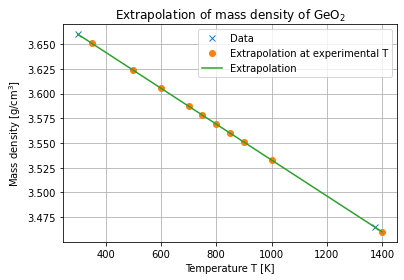

In [16]:
### Compute neuron scattering coefficients

def lin_fit(x,a,b):
    return a*x+b

N = 6.022e23   #avogadro number

#GeO2


T = [350, 500, 600, 700, 750, 800, 850, 900, 1000,1400]  # K

T_data = [300, 1373] #K
density = [3.66, 3.465]  # g/cm^3

slope = (density[0]-density[1])/(T_data[0]-T_data[1])
intercept = (T_data[1]*density[0]-T_data[0]*density[1])/(T_data[1]-T_data[0])


density_geo2 = lin_fit(np.array(T),*[slope,intercept])

aw_ge = 72.63 #g/mol
aw_o = 15.9994 #g/mol
aw_geo2 = aw_ge + 2*aw_o #g/mol

w_ge = aw_ge/aw_geo2
w_o = 2*aw_o/aw_geo2

n_geo2 = density_geo2*N/aw_geo2*1e-24  # atoms/A^3

sigma_ge_coh = 8.42   # barn  1e-28 m^2
sigma_ge_inc = 0.18 
sigma_o_coh = 4.232

sigma_geo2_coh = sigma_ge_coh+2*sigma_o_coh


T_plot = np.linspace(min(T_data),max(T),10000)
plt.plot(T_data,density,'x',label = 'Data')
plt.plot(T[:],density_geo2[:],'o',label = 'Extrapolation at experimental T')
plt.plot(T_plot,lin_fit(T_plot,*[slope,intercept]), '-', label = 'Extrapolation')
plt.legend()
plt.grid()
plt.xlabel('Temperature T [K]')
plt.ylabel(r'Mass density [g/cm$^3$]')
plt.title(r'Extrapolation of mass density of GeO$_2$')
plt.show()



In [17]:
c_ge = 1/3
c_o = 2/3

neutron_coeff = [c_ge*c_ge*sigma_ge_coh/(4*np.pi),2*c_ge*c_o*np.sqrt(sigma_ge_coh*sigma_o_coh)/(4*np.pi),c_o*c_o*sigma_o_coh/(4*np.pi)]  # in barn

print(neutron_coeff)

[0.07444914560187547, 0.21112345923092582, 0.14967638203664468]


In [18]:
(c_ge*np.sqrt(sigma_ge_coh)+c_o*np.sqrt(sigma_o_coh))**2/(np.pi*4)

0.4352489868694459

# Build initial configuration

Follow RMCA SiO $_2$ tutorial:  
* **rand** Build initial random configuration of Ge atoms, with minimum ditance approach. I set $d_{min} = 2.9 \AA$ form check on $g_{Ge-Ge}(r)$ in test runs.  
* **net** Make a Ge-Ge net 4-fold coordinated, set minimum and also maximum distance between atoms, the latter is set to $d_{max}=3.6 \AA$, still form $g_{Ge-Ge}(r)$ in test runs.  
* **ge_o_network** Finally add O atoms in the middle point between Ge atoms. If the net is built correctly this is an easy task with the *add_oxygen_atoms* function.  
If this procedure is implemented correctly one obtains an initial configuration which is able to produce convergent results in a RMCProfile simulation, as previously observed with SiO $_2$.  

If the **net** procedure does not reach >99.5\% 4-fold coordination, move the undercoordinated atoms with *move_atoms_under* and rerun *RMCProfile*. Repeat until the desired almost full 4-fold coordination is reached.



# PBC 2000

### rand and net


In [279]:
filepath = 'pbc_rulez_2000'
directories = ['rand','net']
config = check_configuration_building_pbc(filepath,directories,0,3.6)

Configuration: rand
Processing directory: pbc_rulez_2000/rand
Processing file: ge_rand.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 3.17
Coordination number 0: 1.60% 
Coordination number 1: 8.15% 
Coordination number 2: 21.40% 
Coordination number 3: 30.35% 
Coordination number 4: 22.60% 
Coordination number 5: 11.05% 
Coordination number 6: 4.20% 
Coordination number 7: 0.65% 
Configuration: net
Processing directory: pbc_rulez_2000/net
Processing file: ge_net.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 3.95
Coordination number 1: 0.55% 
Coordination number 2: 1.85% 
Coordination number 4: 97.35% 
Coordination number 6: 0.05% 
Coordination number 7: 0.15% 
Coordination number 8: 0.05% 
Processing directory: pbc_rulez_2000/net/move
Processing file: ge_net.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 3.97
Coordination number 0: 0.05% 
Coordination number 1: 0.40% 
Coordination number 2: 1.05% 
Coordination number 3: 0.20% 
Coordination number 4:

In [ ]:
print('rand')  
#view(config[0],viewer = 'x3d')

In [ ]:
print('net')  
#view(config[1],viewer = 'x3d')

### Reach desired coordination  
Firstly move the more undercoordinated atoms near the less undercoordinated ones.

In [ ]:
coordination_number = calculate_coordination_numbers(config[1], 2.9, 3.6)
move_atoms_under(config[1], coordination_number, 4, 2.9, 3.6)
coordination_number_calculator_pbc(config[1], 'Ge', 'Ge', 0, 3.6)

In [ ]:
rmc6f.write_rmc6f(filepath+'/ge_net_move_under.rmc6f',atoms=config[1])

Then rerun *RMCProfile* and check result

In [ ]:
ge_atoms = rmc6f.read_rmc6f(filepath+'/net/ge_net.rmc6f')
print('Original Ge coordination number')
coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', 0, 3.6)

ge_atoms = rmc6f.read_rmc6f(filepath+'/net/move/ge_net.rmc6f')
print('Ge coordination number after move and rerun')
coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', 0, 3.6)




In [ ]:
ge_atoms_move = ge_atoms.copy()
move_atoms_under(ge_atoms_move, coordination_number, 4, 2.9, 3.6)

print('Ge coordination number after move and rerun')
coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', 0, 3.6)

print('Ge coordination number after move 2')
coordination_number_calculator_pbc(ge_atoms_move, 'Ge', 'Ge', 0, 3.6)



In [ ]:
rmc6f.write_rmc6f(filepath+'/ge_net.rmc6f',atoms=ge_atoms_move)

In [434]:
filepath = 'pbc_rulez_2000'
ge_atoms = rmc6f.read_rmc6f(filepath+'/net/ge_net.rmc6f')

print('Original Ge coordination number')
#coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', 0, 3.6)

ge_atoms = rmc6f.read_rmc6f(filepath+'/net/move/ge_net.rmc6f')

print('Ge coordination number after move and rerun')
coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', 0, 3.6)

print('Ge coordination number after move 2')
#coordination_number_calculator_pbc(ge_atoms_move, 'Ge', 'Ge', 0, 3.6)

ge_atoms = rmc6f.read_rmc6f(filepath+'/net/move1/ge_net.rmc6f')
print('Ge coordination number after move and rerun 2')
coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', 0, 3.6)

Original Ge coordination number
Ge coordination number after move and rerun
Average Ge-Ge coordination number 3.97
Coordination number 0: 0.05% 
Coordination number 1: 0.40% 
Coordination number 2: 1.05% 
Coordination number 3: 0.20% 
Coordination number 4: 98.00% 
Coordination number 5: 0.05% 
Coordination number 6: 0.05% 
Coordination number 7: 0.15% 
Coordination number 8: 0.05% 
Ge coordination number after move 2
Ge coordination number after move and rerun 2
Average Ge-Ge coordination number 3.98
Coordination number 0: 0.05% 
Coordination number 1: 0.35% 
Coordination number 2: 0.55% 
Coordination number 3: 0.05% 
Coordination number 4: 98.90% 
Coordination number 6: 0.05% 
Coordination number 8: 0.05% 


In [435]:
ge_atoms_move = ge_atoms.copy()

coordination_number = calculate_coordination_numbers(ge_atoms_move, 2.9, 3.6)

move_atoms_under(ge_atoms_move, coordination_number, 4, 2.9, 3.6)

print('Ge coordination number after move and rerun 2')
coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', 0, 3.6)

print('Ge coordination number after move 3')
coordination_number_calculator_pbc(ge_atoms_move, 'Ge', 'Ge', 0, 3.6)

Low coordination atoms: [9, 74, 161, 271, 522, 566, 624, 644, 648, 715, 803, 905, 1022, 1285, 1372, 1442, 1458, 1510, 1518, 1667]
Trying to move atom 803 with coordination number 0 near to atom 74 with coordination number 1
Trying to move atom 803 with coordination number 0 near to atom 271 with coordination number 1
New position: [ 1.25859048 26.63247737 39.66064191]
Trying to move atom 74 with coordination number 1 near to atom 271 with coordination number 2
Trying to move atom 74 with coordination number 1 near to atom 9 with coordination number 2
Trying to move atom 74 with coordination number 1 near to atom 161 with coordination number 2
Trying to move atom 74 with coordination number 1 near to atom 522 with coordination number 2
New position: [11.18019317 19.37835249 26.79386322]
Trying to move atom 271 with coordination number 2 near to atom 522 with coordination number 3
Trying to move atom 271 with coordination number 2 near to atom 644 with coordination number 3
New position:

In [436]:
rmc6f.write_rmc6f(filepath+'/ge_net.rmc6f',atoms=ge_atoms_move)

In [501]:
filepath = 'pbc_rulez_2000'
ge_atoms = rmc6f.read_rmc6f(filepath+'/net/ge_net.rmc6f')

print('Original Ge coordination number')
#coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', 0, 3.6)

ge_atoms = rmc6f.read_rmc6f(filepath+'/net/move/ge_net.rmc6f')

print('Ge coordination number after move and rerun')
#coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', 0, 3.6)

print('Ge coordination number after move 2')
#coordination_number_calculator_pbc(ge_atoms_move, 'Ge', 'Ge', 0, 3.6)

ge_atoms = rmc6f.read_rmc6f(filepath+'/net/move1/ge_net.rmc6f')
print('Ge coordination number after move and rerun 2')
coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', 0, 3.6)

ge_atoms = rmc6f.read_rmc6f(filepath+'/net/move2/ge_net.rmc6f')
print('Ge coordination number after move and rerun 3')
coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', 0, 3.6)

Original Ge coordination number
Ge coordination number after move and rerun
Ge coordination number after move 2
Ge coordination number after move and rerun 2
Average Ge-Ge coordination number 3.98
Coordination number 0: 0.05% 
Coordination number 1: 0.35% 
Coordination number 2: 0.55% 
Coordination number 3: 0.05% 
Coordination number 4: 98.90% 
Coordination number 6: 0.05% 
Coordination number 8: 0.05% 
Ge coordination number after move and rerun 3
Average Ge-Ge coordination number 3.99
Coordination number 0: 0.05% 
Coordination number 1: 0.15% 
Coordination number 2: 0.25% 
Coordination number 3: 0.05% 
Coordination number 4: 99.45% 
Coordination number 6: 0.05% 


### ge_o_network

In [504]:
min_distance = 2.9
max_distance = 3.6
ge_atoms = rmc6f.read_rmc6f(filepath+'/net/move2/ge_net.rmc6f')
geo2_atoms = add_oxygen_atoms_pbc(ge_atoms,min_distance,max_distance,filepath)

Number of O atoms added: 3989


In [505]:
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'O', 0,1.8)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'Ge', 0,1.8)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'O', 0,2.35)

Average Ge-O coordination number 3.99
Coordination number 0: 0.05% 
Coordination number 1: 0.15% 
Coordination number 2: 0.25% 
Coordination number 3: 0.05% 
Coordination number 4: 99.45% 
Coordination number 6: 0.05% 
Average O-Ge coordination number 2.00
Coordination number 2: 100.00% 
Average O-O coordination number 2.56
Coordination number 0: 3.06% 
Coordination number 1: 13.71% 
Coordination number 2: 31.79% 
Coordination number 3: 31.81% 
Coordination number 4: 15.14% 
Coordination number 5: 3.99% 
Coordination number 6: 0.48% 
Coordination number 7: 0.03% 


In [ ]:
print('ge_o_network')  
#view(config[1],viewer = 'x3d')

Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 3.99
Coordination number 0: 0.05% 
Coordination number 1: 0.15% 
Coordination number 2: 0.25% 
Coordination number 3: 0.05% 
Coordination number 4: 99.45% 
Coordination number 6: 0.05% 
Average Ge-O coordination number 3.99
Coordination number 0: 0.05% 
Coordination number 1: 0.15% 
Coordination number 2: 0.25% 
Coordination number 3: 0.05% 
Coordination number 4: 99.45% 
Coordination number 6: 0.05% 
Average O-Ge coordination number 2.00
Coordination number 2: 100.00% 
Average O-O coordination number 7.41
Coordination number 3: 0.05% 
Coordination number 4: 0.13% 
Coordination number 5: 0.25% 
Coordination number 6: 20.73% 
Coordination number 7: 37.13% 
Coordination number 8: 26.27% 
Coordination number 9: 11.08% 
Coordination number 10: 3.13% 
Coordination number 11: 0.93% 
Coordination number 12: 0.20% 
Coordination number 13: 0.10% 
Average Ge-Ge distance:  3.26 +/- 0.002 Å
Average Ge-O distance:  1.6

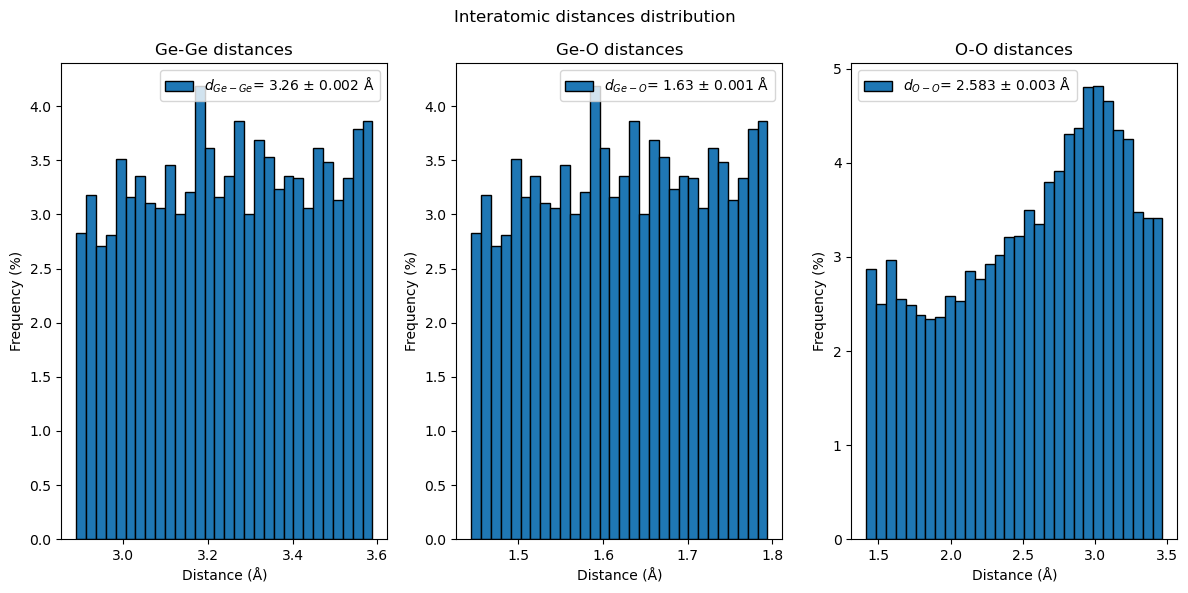

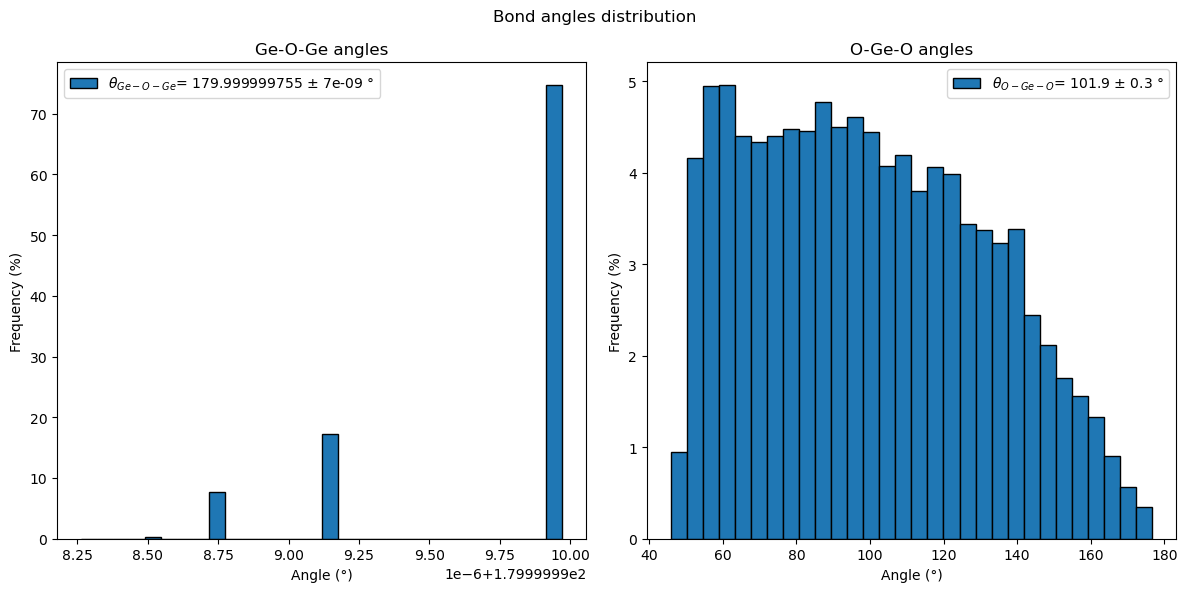

In [506]:
analyze_rmc(geo2_atoms, 'Ge','O',[3.6, 1.8, 3.5],30)

### simulation

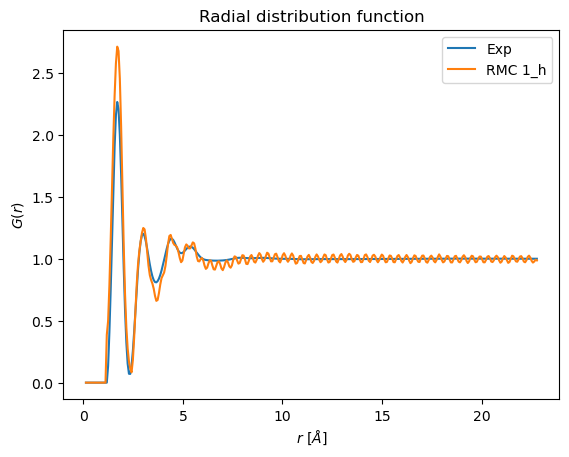

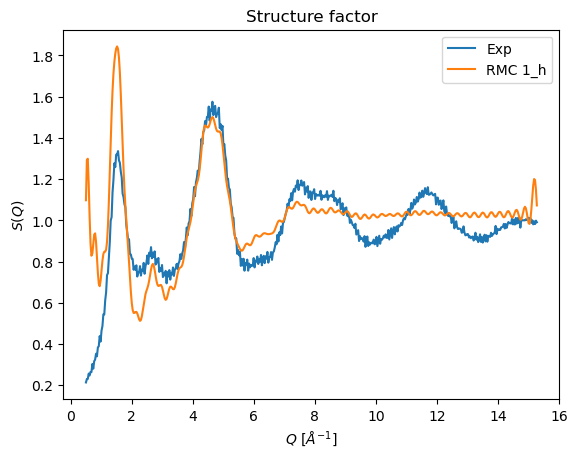

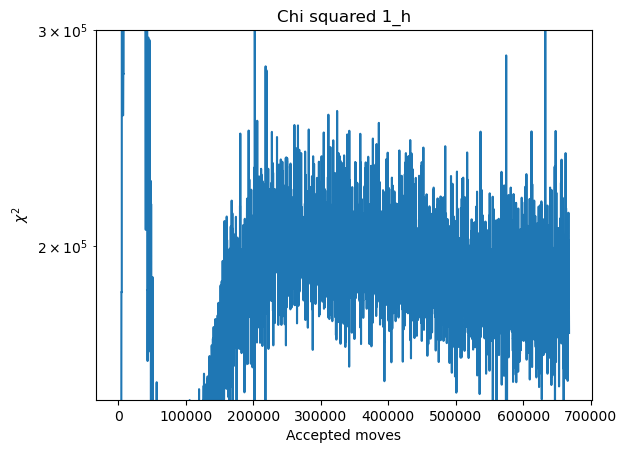

In [394]:
filepath = 'pbc_rulez_2000/ge_o_network1/base'
directories = ['1_h']#,'start']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,'both',[3,1.5e5,3e5])

In [396]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/1_h/ge_o_network.rmc6f')
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'O', 1.17,2.35)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'Ge', 1.17,2.35)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'O', 0,3.2)
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'Ge', 0,3.6)

Average Ge-O coordination number 3.99
Coordination number 0: 0.05% 
Coordination number 1: 0.30% 
Coordination number 2: 0.55% 
Coordination number 3: 0.10% 
Coordination number 4: 98.35% 
Coordination number 5: 0.50% 
Coordination number 6: 0.05% 
Coordination number 7: 0.05% 
Coordination number 8: 0.05% 
Average O-Ge coordination number 2.00
Coordination number 2: 99.77% 
Coordination number 3: 0.23% 
Average O-O coordination number 5.87
Coordination number 1: 0.10% 
Coordination number 2: 0.93% 
Coordination number 3: 4.04% 
Coordination number 4: 11.07% 
Coordination number 5: 23.96% 
Coordination number 6: 28.25% 
Coordination number 7: 19.29% 
Coordination number 8: 8.31% 
Coordination number 9: 3.01% 
Coordination number 10: 0.80% 
Coordination number 11: 0.23% 
Average Ge-Ge coordination number 4.20
Coordination number 0: 0.05% 
Coordination number 1: 0.20% 
Coordination number 2: 0.40% 
Coordination number 3: 0.25% 
Coordination number 4: 79.85% 
Coordination number 5: 17.20%

In [ ]:
print('rmc')  
#view(geo2_atoms,viewer = 'x3d')

Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 4.20
Coordination number 0: 0.05% 
Coordination number 1: 0.20% 
Coordination number 2: 0.40% 
Coordination number 3: 0.30% 
Coordination number 4: 79.75% 
Coordination number 5: 17.25% 
Coordination number 6: 1.95% 
Coordination number 7: 0.05% 
Coordination number 8: 0.05% 
Average Ge-O coordination number 3.99
Coordination number 0: 0.05% 
Coordination number 1: 0.30% 
Coordination number 2: 0.55% 
Coordination number 3: 0.10% 
Coordination number 4: 98.35% 
Coordination number 5: 0.50% 
Coordination number 6: 0.05% 
Coordination number 7: 0.05% 
Coordination number 8: 0.05% 
Average O-Ge coordination number 2.00
Coordination number 2: 99.77% 
Coordination number 3: 0.23% 
Average O-O coordination number 7.24
Coordination number 2: 0.05% 
Coordination number 3: 0.33% 
Coordination number 4: 2.16% 
Coordination number 5: 7.96% 
Coordination number 6: 21.70% 
Coordination number 7: 27.77% 
Coordination nu

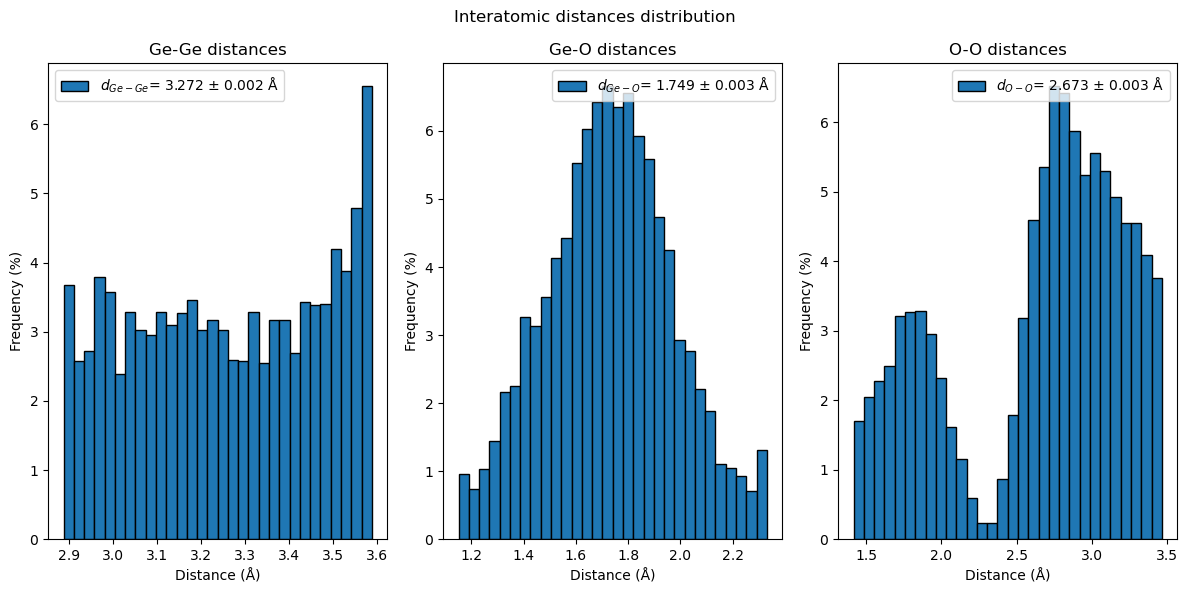

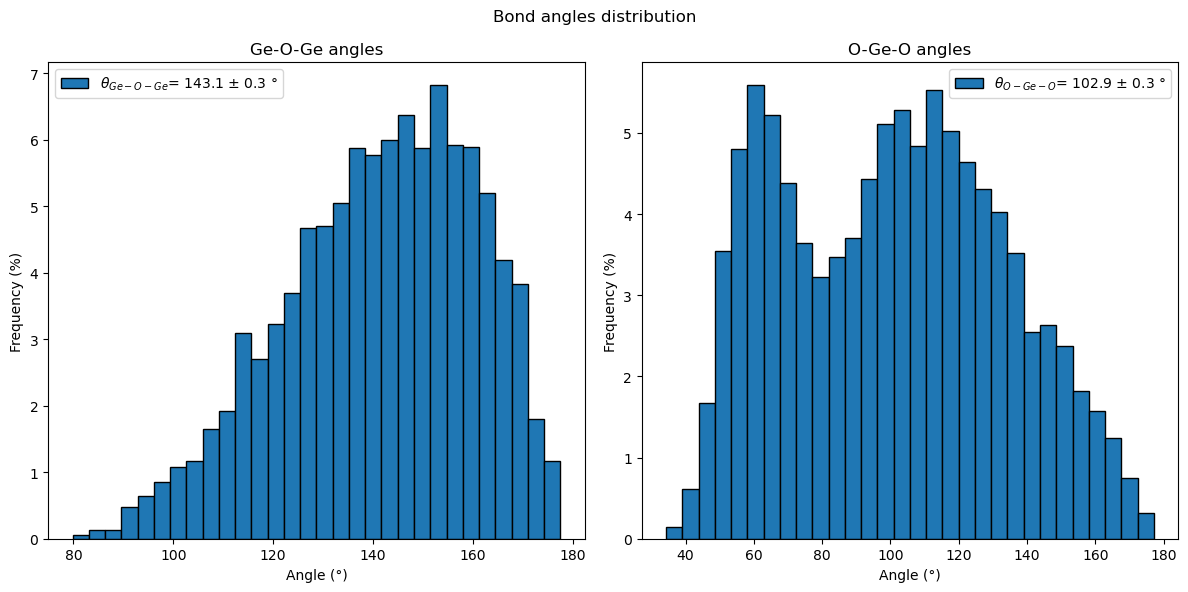

In [354]:
analyze_rmc(geo2_atoms, 'Ge','O',[3.6, 2.35, 3.5],30)

### add distance window [$2.35 \AA,3.5 \AA$] for O-O atoms

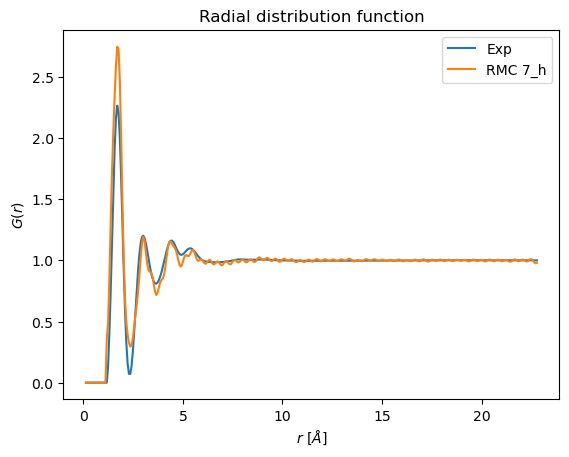

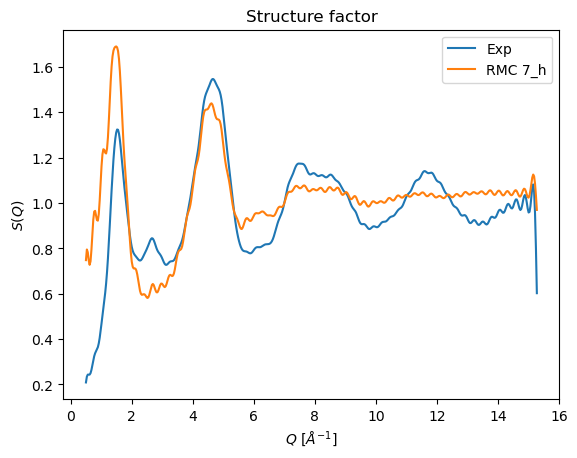

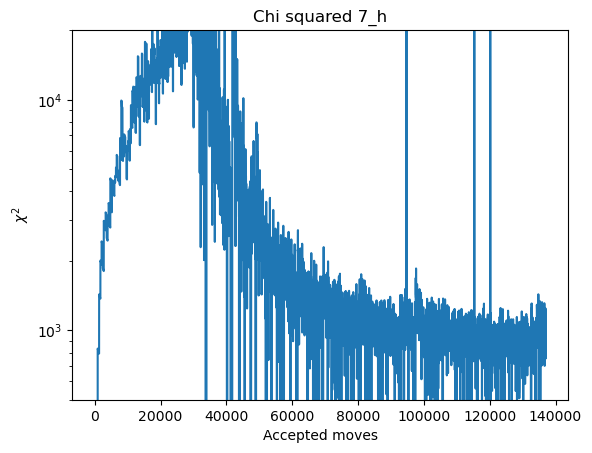

In [496]:
filepath = 'pbc_rulez_2000/ge_o_network1/dw_oo'
directories = ['7_h']#,'start']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,'both',[4,5e2,2e4])

In [497]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/7_h/ge_o_network.rmc6f')
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'O', 1.17,2.35)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'Ge', 1.17,2.35)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'O', 0,3.5)
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'Ge', 0,3.6)

Average Ge-O coordination number 4.00
Coordination number 0: 0.05% 
Coordination number 1: 0.30% 
Coordination number 2: 0.55% 
Coordination number 3: 0.10% 
Coordination number 4: 97.50% 
Coordination number 5: 1.30% 
Coordination number 6: 0.10% 
Coordination number 7: 0.05% 
Coordination number 8: 0.05% 
Average O-Ge coordination number 2.01
Coordination number 2: 99.35% 
Coordination number 3: 0.63% 
Coordination number 4: 0.03% 
Average O-O coordination number 7.67
Coordination number 3: 0.03% 
Coordination number 4: 0.18% 
Coordination number 5: 0.15% 
Coordination number 6: 15.62% 
Coordination number 7: 33.50% 
Coordination number 8: 27.85% 
Coordination number 9: 15.37% 
Coordination number 10: 5.27% 
Coordination number 11: 1.41% 
Coordination number 12: 0.40% 
Coordination number 13: 0.10% 
Coordination number 14: 0.08% 
Coordination number 15: 0.03% 
Coordination number 16: 0.03% 
Average Ge-Ge coordination number 4.35
Coordination number 1: 0.15% 
Coordination number 2: 0.

Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 4.35
Coordination number 1: 0.15% 
Coordination number 2: 0.40% 
Coordination number 3: 0.30% 
Coordination number 4: 68.70% 
Coordination number 5: 25.05% 
Coordination number 6: 4.85% 
Coordination number 7: 0.50% 
Coordination number 8: 0.05% 
Average Ge-O coordination number 4.00
Coordination number 0: 0.05% 
Coordination number 1: 0.30% 
Coordination number 2: 0.55% 
Coordination number 3: 0.10% 
Coordination number 4: 97.50% 
Coordination number 5: 1.30% 
Coordination number 6: 0.10% 
Coordination number 7: 0.05% 
Coordination number 8: 0.05% 
Average O-Ge coordination number 2.01
Coordination number 2: 99.35% 
Coordination number 3: 0.63% 
Coordination number 4: 0.03% 
Average O-O coordination number 7.67
Coordination number 3: 0.03% 
Coordination number 4: 0.18% 
Coordination number 5: 0.15% 
Coordination number 6: 15.62% 
Coordination number 7: 33.50% 
Coordination number 8: 27.85% 
Coordination n

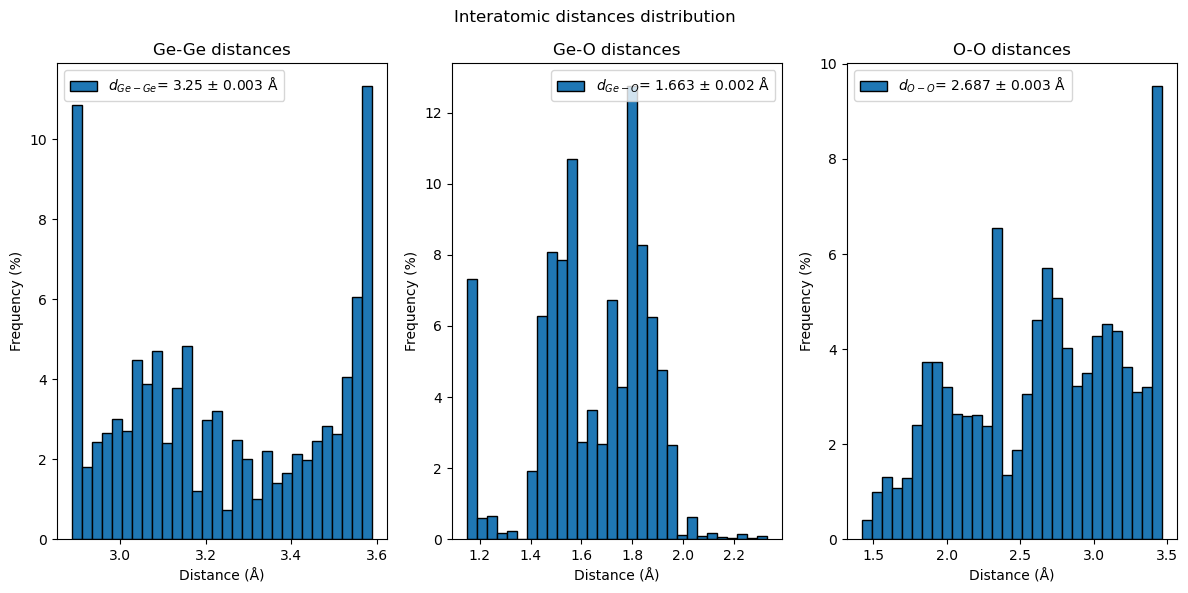

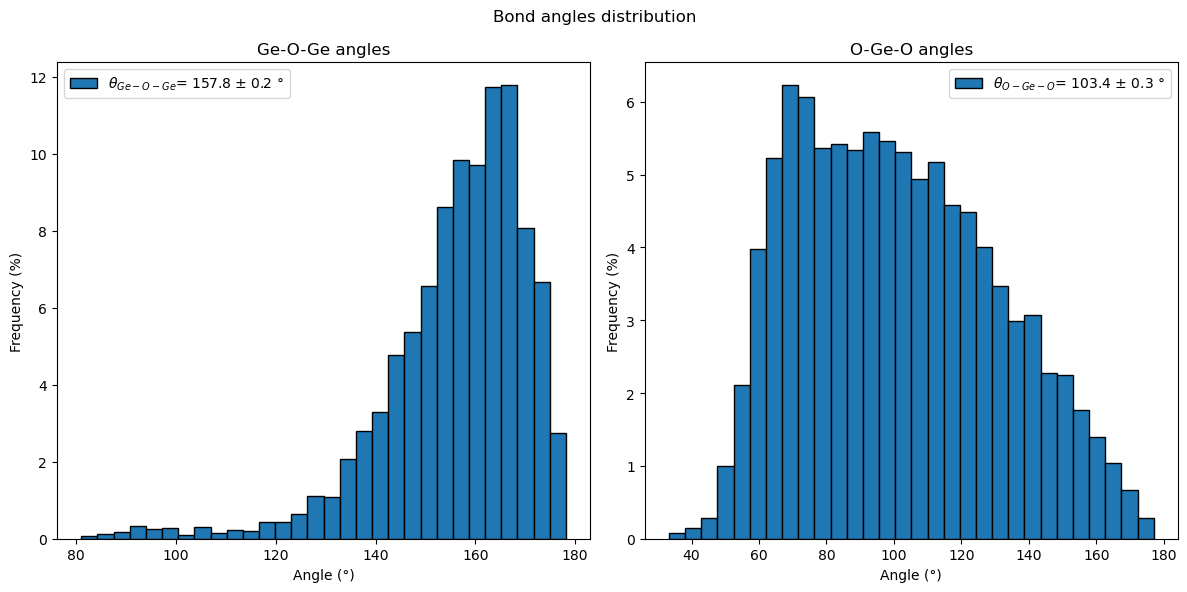

In [498]:
analyze_rmc(geo2_atoms, 'Ge','O',[3.6, 2.35, 3.5],30)

# PBC 700

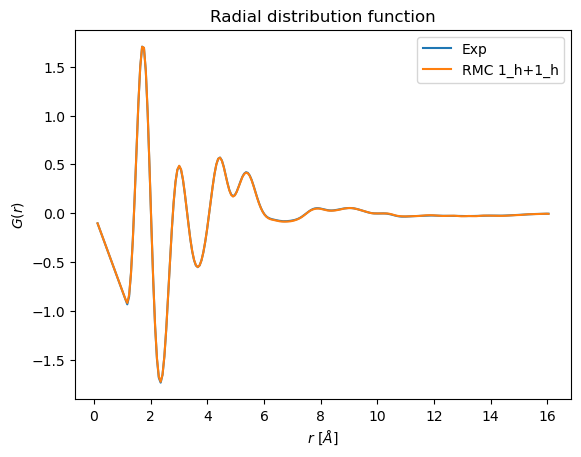

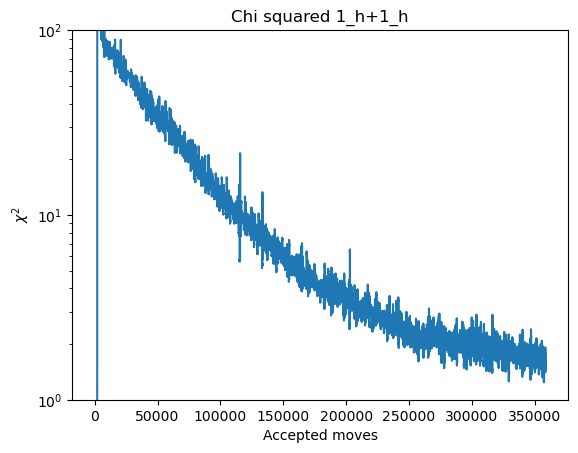

In [47]:
filepath = 'pbc_rulez_700/ge_o_network/no_constraints_gdr'
#directories = ['start','1_h','1_h+1_h']
directories = ['1_h+1_h']
check_RMC_simulation(filepath,directories,'ge_o_network','gdr',[4,1e0,1e2])

In [48]:
# I want to view just the centarl part of the box, a sub box with size 6x6x6
geo2_atoms = rmc6f.read_rmc6f(filepath+'/1_h+1_h/ge_o_network.rmc6f')
geo2_atoms_sub_box = view_sub_box(geo2_atoms, 15)

view(geo2_atoms_sub_box,viewer = 'x3d')


Unit cell center: [16.21824187 16.11813666 15.97284807]
Sub-box bounds: [8.71824187 8.61813666 8.47284807] to [23.71824187 23.61813666 23.47284807]


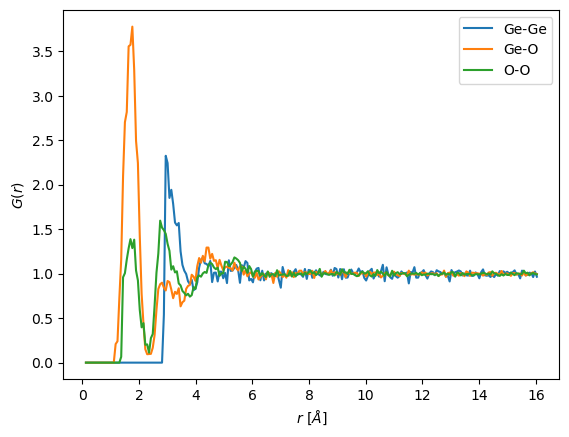

In [472]:


r = pd.read_csv(filepath+'/1_h+1_h/ge_o_network_PDFpartials.csv',header=1,usecols = [0]).values.flatten()

gdr_GeGe = pd.read_csv(filepath+'/1_h+1_h/ge_o_network_PDFpartials.csv',header=1,usecols = [1]).values.flatten()

gdr_GeO = pd.read_csv(filepath+'/1_h+1_h/ge_o_network_PDFpartials.csv',header=1,usecols = [2]).values.flatten()

gdr_OO = pd.read_csv(filepath+'/1_h+1_h/ge_o_network_PDFpartials.csv',header=1,usecols = [3]).values.flatten()


plt.plot(r,gdr_GeGe,label = 'Ge-Ge')
plt.plot(r,gdr_GeO, label = 'Ge-O')
plt.plot(r,gdr_OO, label = 'O-O')
plt.legend()
plt.xlabel(r'$r$ [$\AA$]')
plt.ylabel(r'$G(r)$')
#plt.xlim(1.6,1.8)
plt.show()

Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 3.99
Coordination number 1: 0.14% 
Coordination number 3: 0.14% 
Coordination number 4: 99.71% 
Average Ge-O coordination number 4.00
Coordination number 1: 0.14% 
Coordination number 3: 0.14% 
Coordination number 4: 99.43% 
Coordination number 5: 0.29% 
Average O-Ge coordination number 2.00
Coordination number 2: 99.86% 
Coordination number 3: 0.14% 
Average O-O coordination number 7.39
Coordination number 4: 0.07% 
Coordination number 5: 0.43% 
Coordination number 6: 21.17% 
Coordination number 7: 36.98% 
Coordination number 8: 26.04% 
Coordination number 9: 11.44% 
Coordination number 10: 3.29% 
Coordination number 11: 0.50% 
Coordination number 12: 0.07% 
Average Ge-Ge distance:  3.26 +/- 0.004 Å
Average Ge-O distance:  1.631 +/- 0.002 Å
Average O-O distance:  2.576 +/- 0.006 Å
Average  Ge-O-Ge angle:  179.7 +/- 0.1 °
Average  O-Ge-O angle:  101.6 +/- 0.5 °


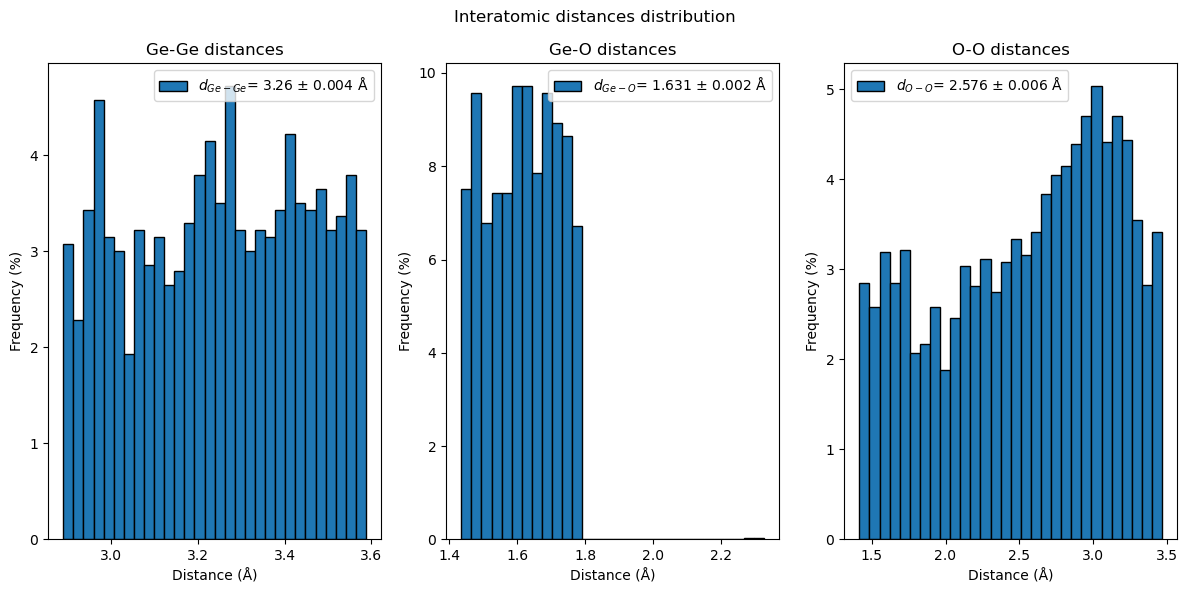

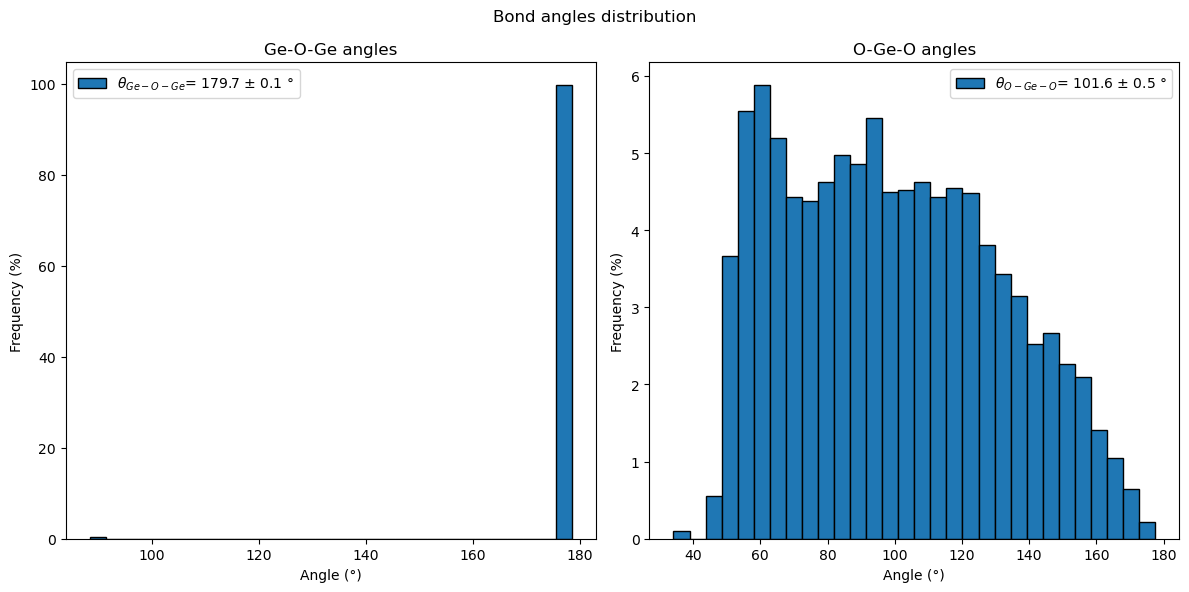

In [473]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/start/ge_o_network.rmc6f')
analyze_rmc(geo2_atoms, 'Ge','O',[3.6, 2.35, 3.5],30)

Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 3.25
Coordination number 0: 0.71% 
Coordination number 1: 6.43% 
Coordination number 2: 19.14% 
Coordination number 3: 31.29% 
Coordination number 4: 28.29% 
Coordination number 5: 11.57% 
Coordination number 6: 2.43% 
Coordination number 7: 0.14% 
Average Ge-O coordination number 3.27
Coordination number 0: 0.43% 
Coordination number 1: 3.14% 
Coordination number 2: 14.14% 
Coordination number 3: 35.14% 
Coordination number 4: 45.57% 
Coordination number 5: 1.57% 
Average O-Ge coordination number 1.64
Coordination number 0: 2.36% 
Coordination number 1: 32.26% 
Coordination number 2: 64.66% 
Coordination number 3: 0.72% 
Average O-O coordination number 6.92
Coordination number 2: 0.29% 
Coordination number 3: 1.72% 
Coordination number 4: 6.37% 
Coordination number 5: 10.94% 
Coordination number 6: 21.10% 
Coordination number 7: 24.18% 
Coordination number 8: 18.53% 
Coordination number 9: 9.94% 
Coordina

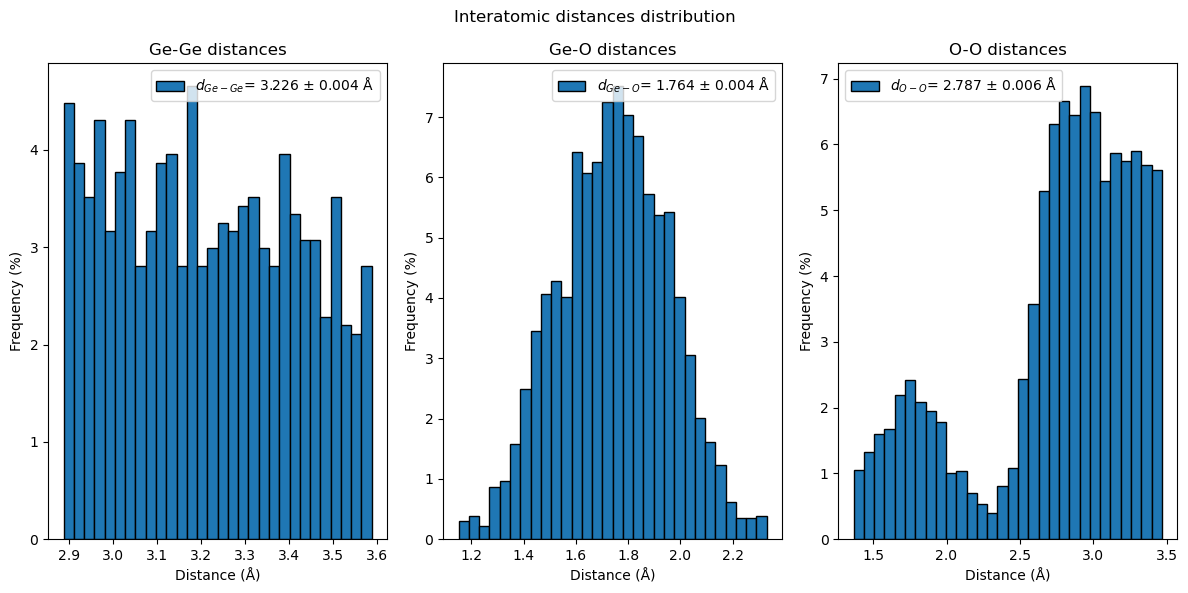

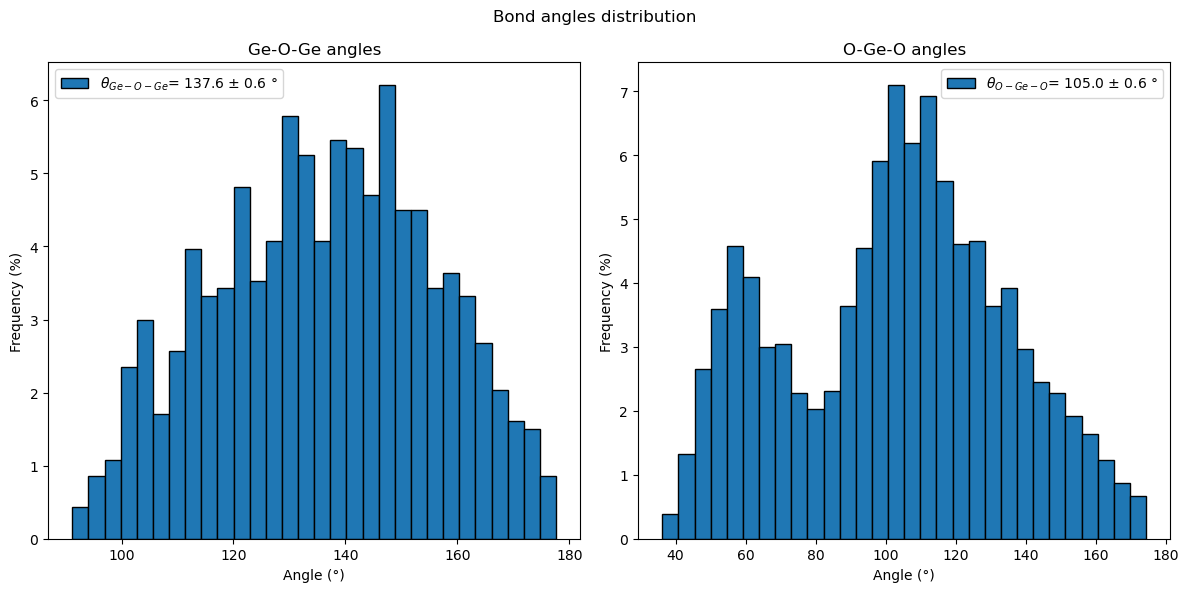

In [477]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/1_h+1_h/ge_o_network.rmc6f')
analyze_rmc(geo2_atoms, 'Ge','O',[3.6, 2.35, 3.5],30)

### D(r) fit with constraints

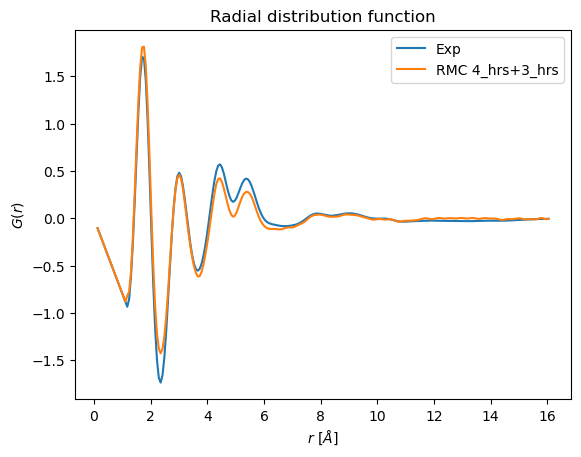

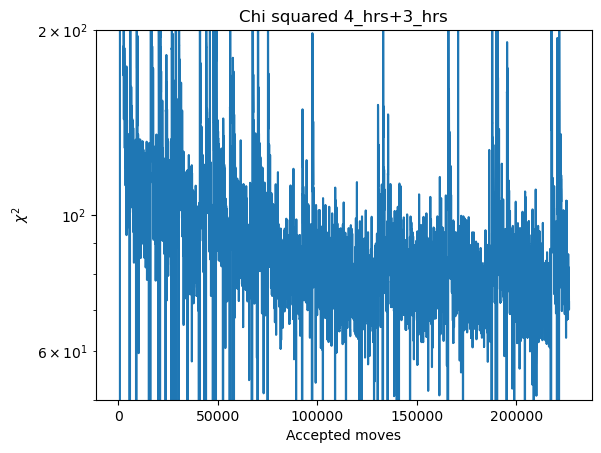

In [50]:
filepath = 'pbc_rulez_700/ge_o_network/dw_gdr'
#directories = ['start','1_h','1_h+1_h']
directories = ['4_hrs+3_hrs']#,'4_hrs']#,'start']
check_RMC_simulation(filepath,directories,'ge_o_network','gdr',[3,5e1,2e2])

Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 4.15
Coordination number 1: 0.14% 
Coordination number 3: 0.14% 
Coordination number 4: 85.14% 
Coordination number 5: 13.71% 
Coordination number 6: 0.86% 


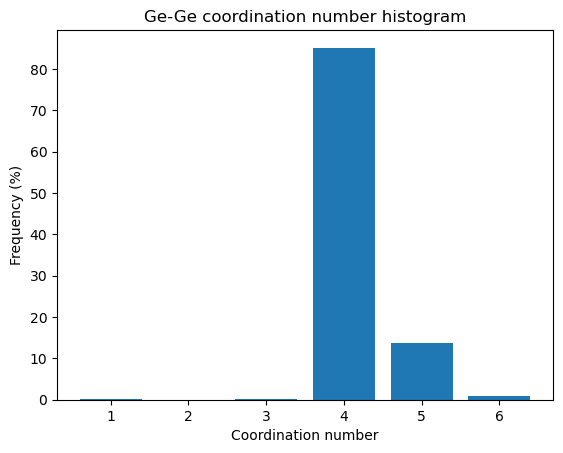

Average Ge-O coordination number 4.00
Coordination number 1: 0.14% 
Coordination number 3: 0.14% 
Coordination number 4: 99.43% 
Coordination number 5: 0.29% 


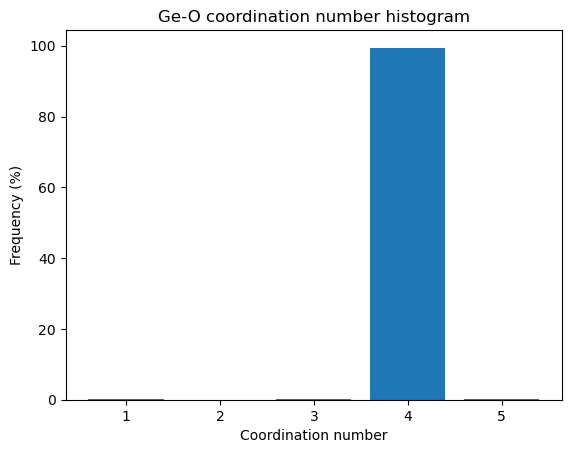

Average O-Ge coordination number 2.00
Coordination number 2: 99.86% 
Coordination number 3: 0.14% 


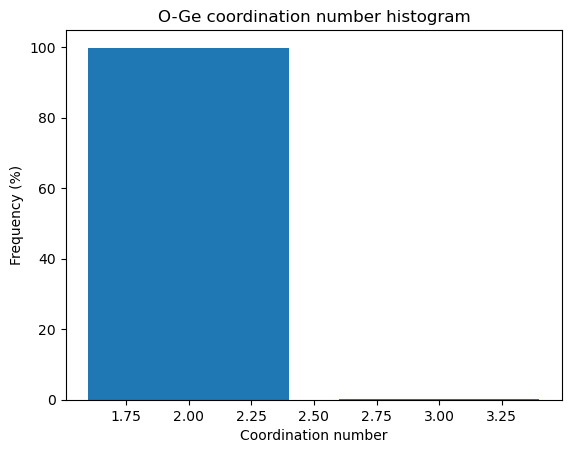

Average O-O coordination number 8.44
Coordination number 5: 0.21% 
Coordination number 6: 4.65% 
Coordination number 7: 19.03% 
Coordination number 8: 29.90% 
Coordination number 9: 26.54% 
Coordination number 10: 13.81% 
Coordination number 11: 5.08% 
Coordination number 12: 0.57% 
Coordination number 13: 0.21% 


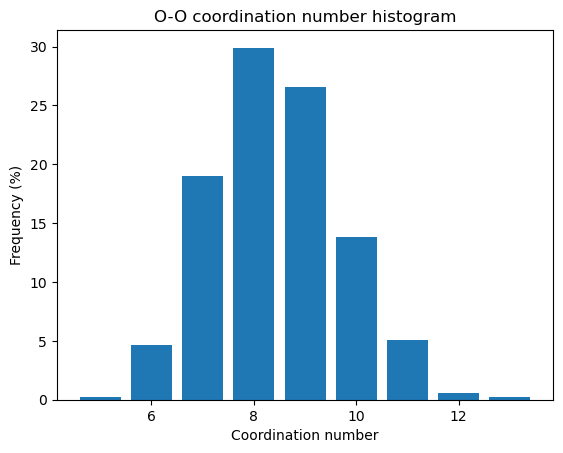

Average Ge-Ge distance:  3.238 +/- 0.004 Å
Average Ge-O distance:  1.755 +/- 0.004 Å
Average O-O distance:  2.894 +/- 0.004 Å
Average  Ge-O-Ge angle:  139.8 +/- 0.6 °
Average  O-Ge-O angle:  106.2 +/- 0.4 °


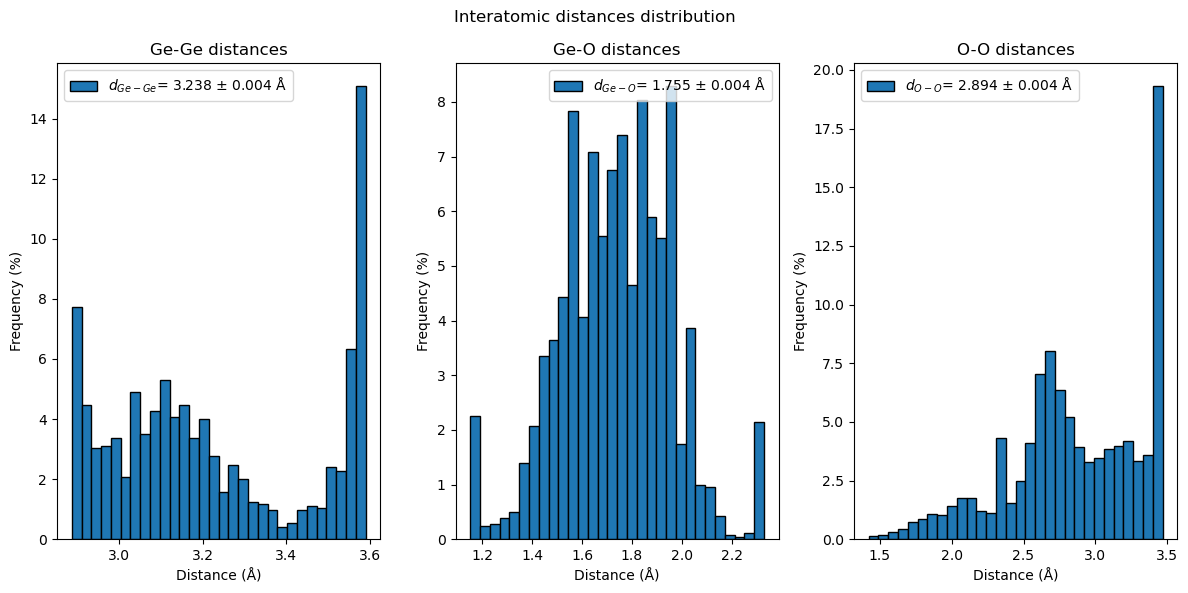

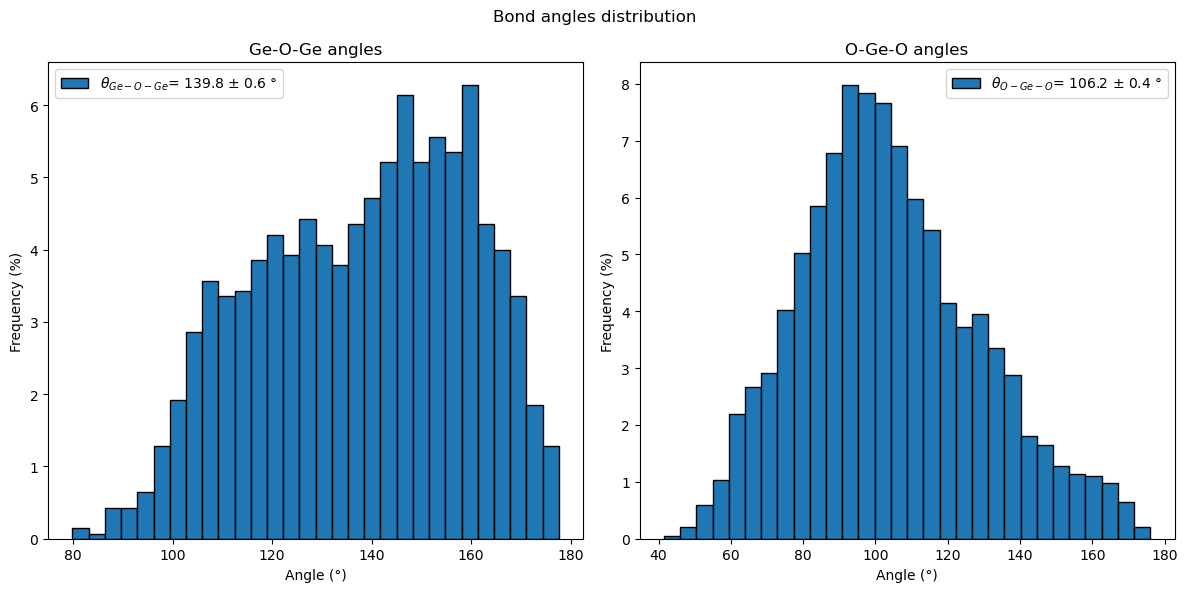

In [43]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/4_hrs+3_hrs/ge_o_network.rmc6f')
analyze_rmc(geo2_atoms, 'Ge','O',[3.6, 2.35, 3.5],30)

### $G'(r)$ and $S(Q)$ fit

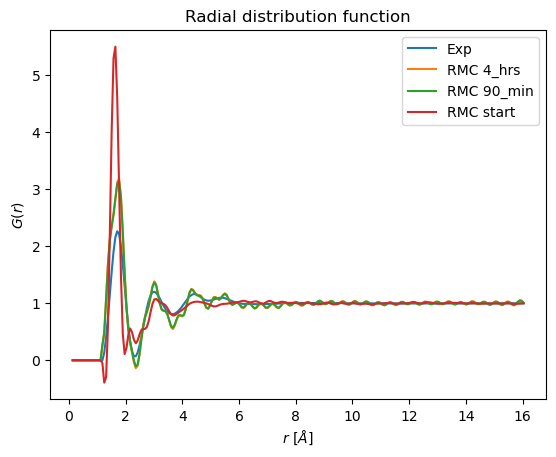

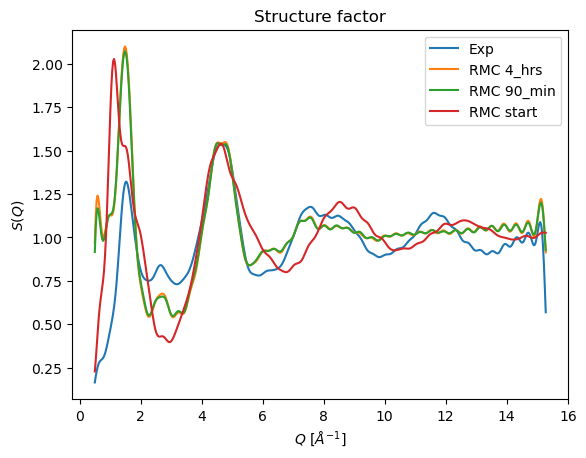

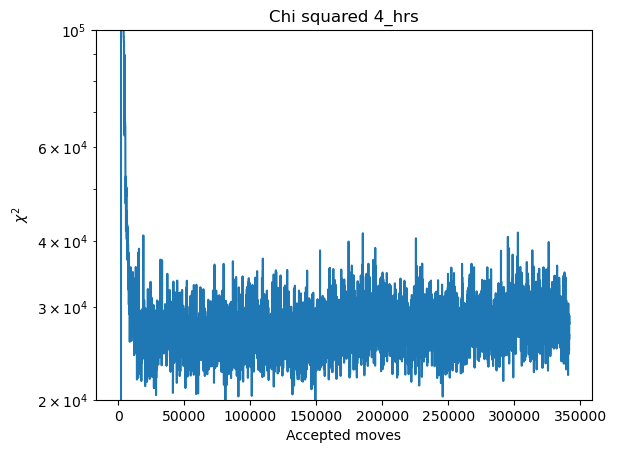

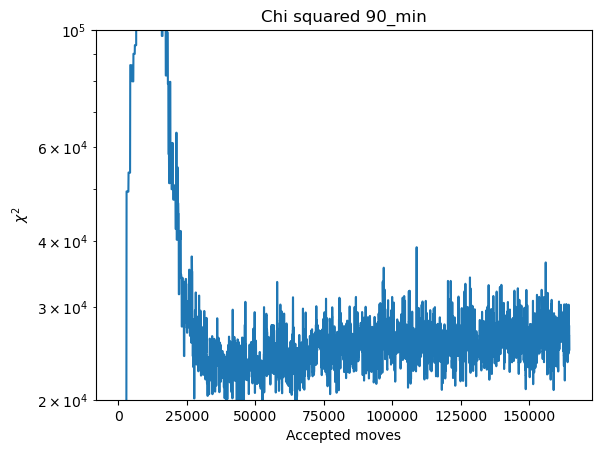

In [51]:
filepath = 'pbc_rulez_700/ge_o_network/Gr_Sq'
#directories = ['start','1_h','1_h+1_h']
directories = ['4_hrs','90_min','start']
check_RMC_simulation(filepath,directories,'ge_o_network','both',[3,2e4,1e5])

Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 4.18
Coordination number 1: 0.14% 
Coordination number 4: 82.57% 
Coordination number 5: 16.00% 
Coordination number 6: 1.14% 
Coordination number 7: 0.14% 


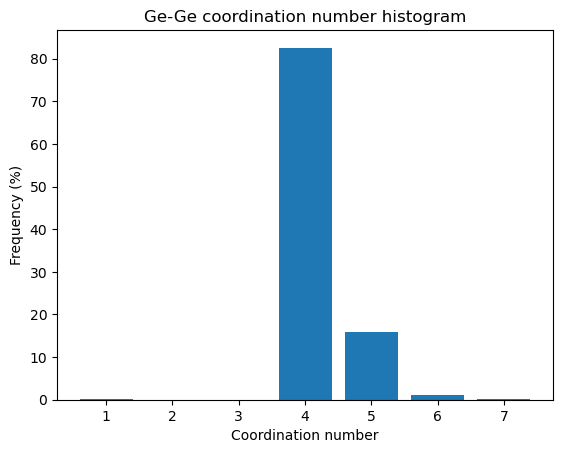

Average Ge-O coordination number 4.02
Coordination number 1: 0.14% 
Coordination number 3: 0.14% 
Coordination number 4: 96.71% 
Coordination number 5: 3.00% 


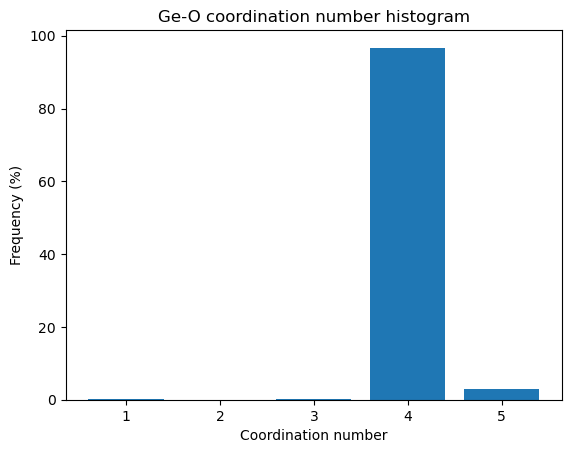

Average O-Ge coordination number 2.02
Coordination number 2: 98.50% 
Coordination number 3: 1.50% 


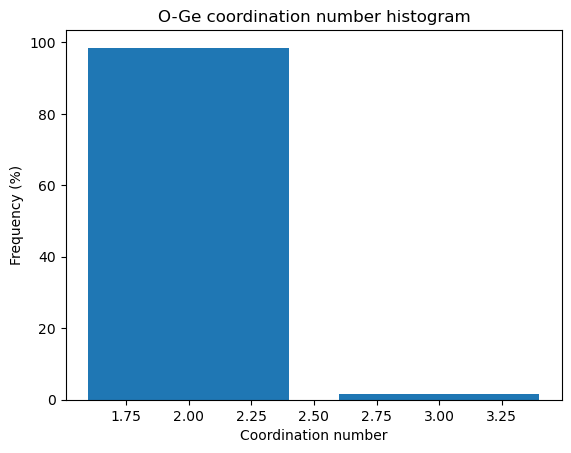

Average O-O coordination number 7.30
Coordination number 3: 0.07% 
Coordination number 4: 1.14% 
Coordination number 5: 5.72% 
Coordination number 6: 21.53% 
Coordination number 7: 30.47% 
Coordination number 8: 23.03% 
Coordination number 9: 12.95% 
Coordination number 10: 3.29% 
Coordination number 11: 1.22% 
Coordination number 12: 0.50% 
Coordination number 13: 0.07% 


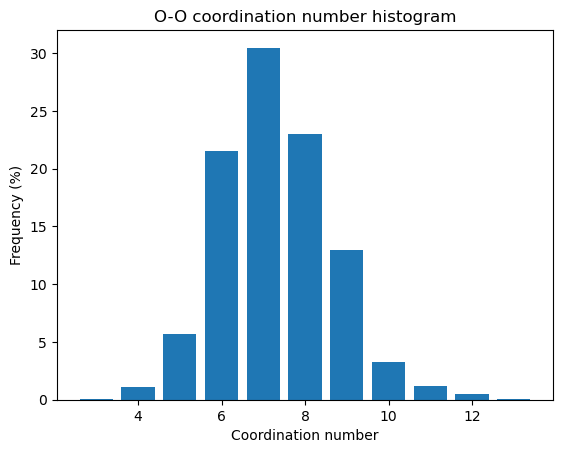

Average Ge-Ge distance:  3.243 +/- 0.004 Å
Average Ge-O distance:  1.673 +/- 0.005 Å
Average O-O distance:  2.578 +/- 0.006 Å
Average  Ge-O-Ge angle:  153.0 +/- 0.4 °
Average  O-Ge-O angle:  101.3 +/- 0.5 °


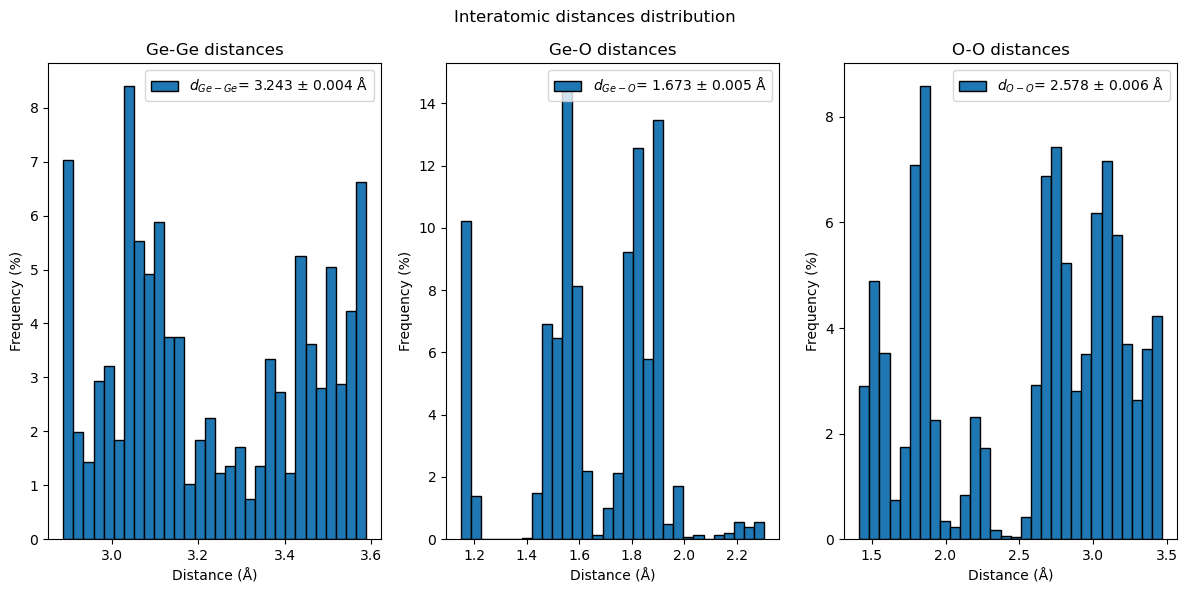

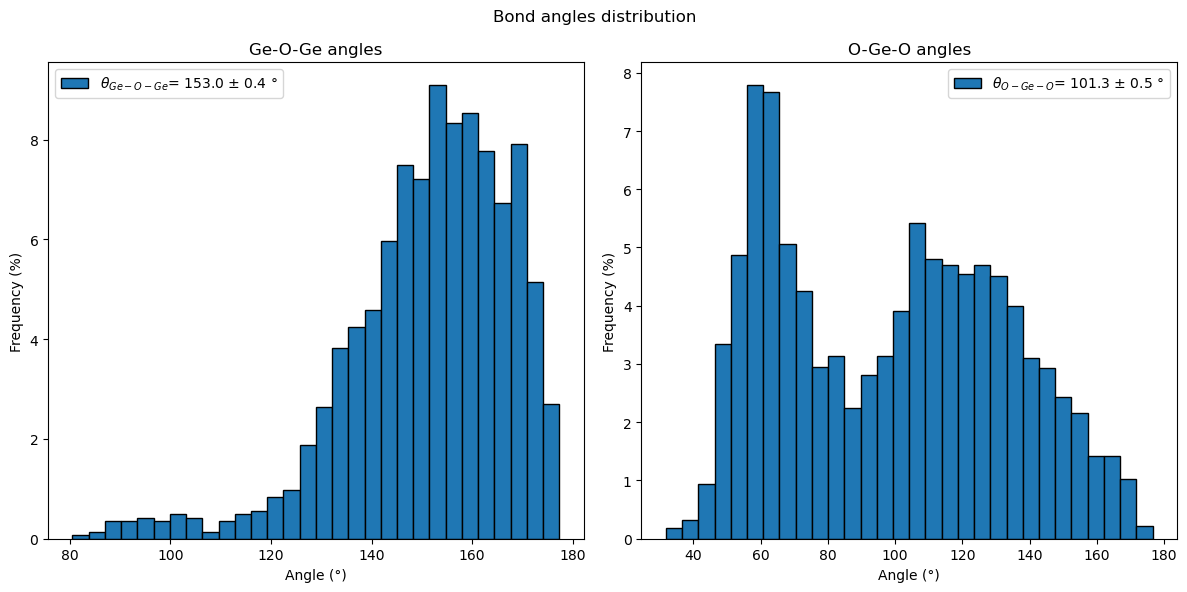

In [579]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/4_hrs/ge_o_network.rmc6f')
analyze_rmc(geo2_atoms, 'Ge','O',[3.6, 2.35, 3.5],30)

# CI à la Zanatta

Set the minimum and maximum Ge-Ge distances accordingly to the infos we actually have: Ge-O average distance (first $G(r)$ peak position) and Ge-O distance spread (first $G(r)$ peak width). Minimum apporach will be given by the Ge-O distance (consider also position spread), maximum will be double the Ge-O distance (still consider distance spread).

In [65]:
ge_o_peak_pos = read_dat_file('../geo2_350K_peaks',1)[0][0]
ge_o_peak_width = read_dat_file('../geo2_350K_peaks',1)[1][0]

print('Ge-O peak position:',ge_o_peak_pos)
print('Ge-O peak width:',ge_o_peak_width)

min_distance = round(ge_o_peak_pos-ge_o_peak_width/2,2)
max_distance = round(2*ge_o_peak_pos+ge_o_peak_width,2)
print('Minimum Ge-Ge distance:',min_distance)
print('Maximum Ge-Ge distance:',max_distance)



Ge-O peak position: 1.7138636762698654
Ge-O peak width: 0.23304900269090412
Minimum Ge-Ge distance: 1.6
Maximum Ge-Ge distance: 3.66


Configuration: rand
Processing directory: Zanatta_CI/rand
Processing file: ge_rand.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 4.11
Coordination number 0: 1.00% 
Coordination number 1: 6.43% 
Coordination number 2: 12.43% 
Coordination number 3: 19.00% 
Coordination number 4: 20.71% 
Coordination number 5: 18.86% 
Coordination number 6: 12.43% 
Coordination number 7: 5.29% 
Coordination number 8: 2.29% 
Coordination number 9: 0.71% 
Coordination number 10: 0.57% 
Coordination number 11: 0.29% 


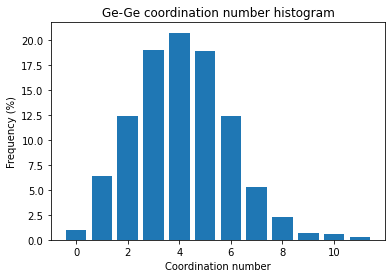

Configuration: net
Processing directory: Zanatta_CI/net
Processing file: ge_net.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 4.01
Coordination number 2: 0.29% 
Coordination number 4: 99.14% 
Coordination number 6: 0.29% 
Coordination number 7: 0.29% 


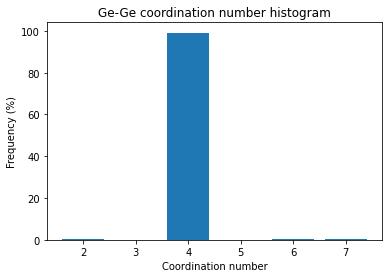

Processing directory: Zanatta_CI/net/move1
Processing file: ge_net.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 3.98
Coordination number 1: 0.29% 
Coordination number 2: 0.71% 
Coordination number 4: 98.86% 
Coordination number 6: 0.14% 


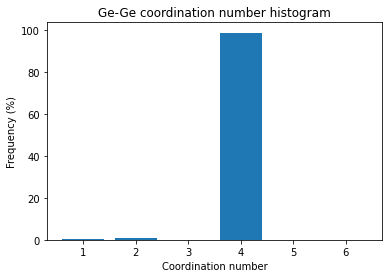

Processing directory: Zanatta_CI/net/move
Processing file: ge_net.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 4.00
Coordination number 2: 0.57% 
Coordination number 4: 99.00% 
Coordination number 6: 0.14% 
Coordination number 7: 0.29% 


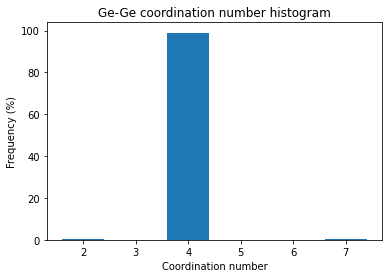

In [21]:
filepath = 'Zanatta_CI'
directories = ['rand','net']
config = check_configuration_building_pbc(filepath,directories,min_distance,max_distance)


In [22]:
ge_atoms_sub_box = view_sub_box(config[0], 15)

view(ge_atoms_sub_box,viewer = 'x3d')

Unit cell center: [16.12462858 16.12006374 15.62086284]
Sub-box bounds: [8.62462858 8.62006374 8.12086284] to [23.62462858 23.62006374 23.12086284]


In [23]:
ge_atoms_sub_box = view_sub_box(config[1], 15)

view(ge_atoms_sub_box,viewer = 'x3d')

Unit cell center: [16.11623794 16.0416141  15.84548678]
Sub-box bounds: [8.61623794 8.5416141  8.34548678] to [23.61623794 23.5416141  23.34548678]


High coordination atoms: [101, 192, 337, 378]
Low coordination atoms: [517, 578]
Trying to move atom 101 with coordination number 7 near to atom 517 with coordination number 2
[15.68112688 31.4523626  10.16644096]
New position: [15.68112688 31.4523626  10.16644096]
Trying to move atom 192 with coordination number 6 near to atom 517 with coordination number 2
None
Trying to move atom 192 with coordination number 6 near to atom 578 with coordination number 2
[17.33797545 24.04857029 29.17493215]
New position: [17.33797545 24.04857029 29.17493215]
Trying to move atom 337 with coordination number 6 near to atom 517 with coordination number 2
None
Trying to move atom 337 with coordination number 6 near to atom 578 with coordination number 2
[15.32217091 27.38570742 27.70566924]
New position: [15.32217091 27.38570742 27.70566924]
Trying to move atom 378 with coordination number 7 near to atom 517 with coordination number 2
None
Trying to move atom 378 with coordination number 7 near to atom 

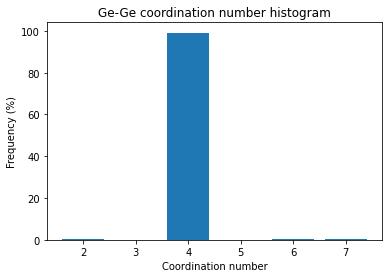

Ge coordination number after move 
Average Ge-Ge coordination number 3.96
Coordination number 1: 0.43% 
Coordination number 3: 2.86% 
Coordination number 4: 96.57% 
Coordination number 7: 0.14% 


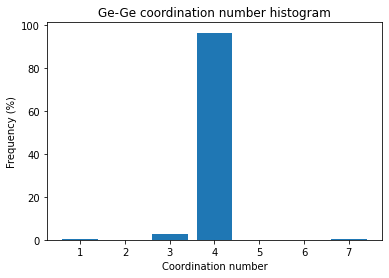

In [26]:
ge_atoms_move = config[1].copy()

coordination_number = calculate_coordination_numbers(ge_atoms_move, min_distance, max_distance)

move_atoms_over(ge_atoms_move, coordination_number, 4, min_distance, max_distance)

print('Ge coordination number after run 1')
coordination_number_calculator_pbc(config[1], 'Ge', 'Ge', min_distance, max_distance)

print('Ge coordination number after move ')
coordination_number_calculator_pbc(ge_atoms_move, 'Ge', 'Ge', min_distance, max_distance)

rmc6f.write_rmc6f(filepath+'/ge_net.rmc6f',atoms=ge_atoms_move)

To obtain a better network would have been better to *move_atoms_under* after *move_atoms_over*, thi sway part of the threefold coordinated are already satisfied befor the run 

Low coordination atoms: [101, 124, 187, 192, 231, 239, 287, 336, 337, 397, 415, 453, 462, 469, 477, 513, 517, 528, 557, 626, 644, 667, 676]
Trying to move atom 101 with coordination number 1 near to atom 124 with coordination number 3
Trying to move atom 101 with coordination number 1 near to atom 187 with coordination number 3
New position: [ 1.1552474  18.14485974  5.96519307]
Atom 101 or atom 187 has obtained the right coordination: 1, 4
Trying to move atom 192 with coordination number 1 near to atom 124 with coordination number 3
Trying to move atom 192 with coordination number 1 near to atom 231 with coordination number 3
Trying to move atom 192 with coordination number 1 near to atom 239 with coordination number 3
Trying to move atom 192 with coordination number 1 near to atom 287 with coordination number 3
Trying to move atom 192 with coordination number 1 near to atom 336 with coordination number 3
New position: [29.69969554  6.01143026 22.55697953]
Atom 192 or atom 336 has obt

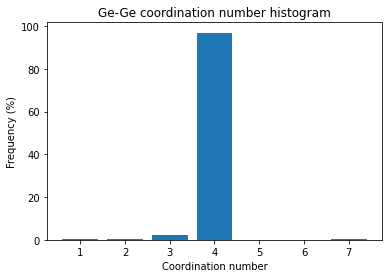

In [27]:
ge_atoms_move1 = ge_atoms_move.copy()

coordination_number = calculate_coordination_numbers(ge_atoms_move1, min_distance, max_distance)

move_atoms_under(ge_atoms_move1, coordination_number, 4, min_distance, max_distance)


print('Ge coordination number after move 1')
coordination_number_calculator_pbc(ge_atoms_move1, 'Ge', 'Ge', min_distance, max_distance)

rmc6f.write_rmc6f(filepath+'/ge_net.rmc6f',atoms=ge_atoms_move)

Ge coordination number after move 1
Average Ge-Ge coordination number 3.98
Coordination number 0: 0.14% 
Coordination number 1: 0.29% 
Coordination number 2: 0.43% 
Coordination number 4: 99.00% 
Coordination number 6: 0.14% 


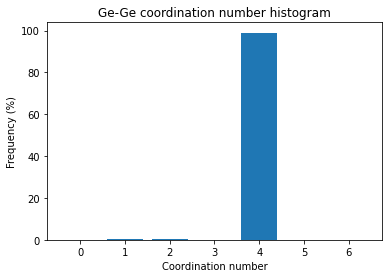

In [26]:
filepath = 'Zanatta_CI'
ge_atoms = rmc6f.read_rmc6f(filepath+'/net/move1/ge_net.rmc6f')
print('Ge coordination number after move 1')
coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', min_distance, max_distance)

ge_atoms_move= rmc6f.read_rmc6f(filepath+'/net/move1/ge_net.rmc6f')

Low coordination atoms: [101, 192, 337, 415, 513, 630]
Trying to move atom 513 with coordination number 0 near to atom 101 with coordination number 1
New position: [18.2686934   2.95523264  8.92143597]
Could not find a valid new position for atom 101
Trying to move atom 415 with coordination number 1 near to atom 101 with coordination number 2
New position: [20.26217838  0.03799528  7.26395909]
Trying to move atom 192 with coordination number 2 near to atom 101 with coordination number 3
Could not find a valid new position for atom 192
Trying to move atom 337 with coordination number 2 near to atom 101 with coordination number 3
Could not find a valid new position for atom 337
Trying to move atom 630 with coordination number 2 near to atom 101 with coordination number 3
Could not find a valid new position for atom 630
Ge coordination number after move 3
Average Ge-Ge coordination number 3.98
Coordination number 1: 0.29% 
Coordination number 2: 0.43% 
Coordination number 3: 0.29% 
Coord

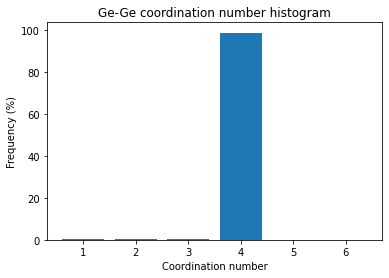

In [27]:
ge_atoms_move1 = ge_atoms_move.copy()

coordination_number = calculate_coordination_numbers(ge_atoms_move1, min_distance, max_distance)

move_atoms_under(ge_atoms_move1, coordination_number, 4, min_distance, max_distance)


print('Ge coordination number after move 3')
coordination_number_calculator_pbc(ge_atoms_move1, 'Ge', 'Ge', min_distance, max_distance)



In [30]:
rmc6f.write_rmc6f(filepath+'/ge_net.rmc6f',atoms=ge_atoms_move1)

Ge coordination number after move 1
Average Ge-Ge coordination number 4.00
Coordination number 2: 0.14% 
Coordination number 4: 99.86% 


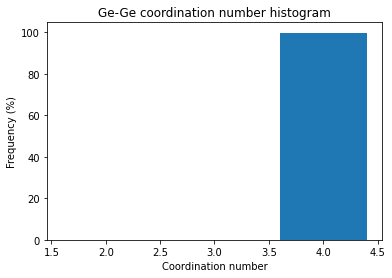

In [66]:
filepath = 'Zanatta_CI'
ge_atoms = rmc6f.read_rmc6f(filepath+'/net/move2_GPU/ge_net.rmc6f')
print('Ge coordination number after move 1')
coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', min_distance, max_distance)

#ge_atoms_move= rmc6f.read_rmc6f(filepath+'/net/move2/ge_net.rmc6f')

Ge coordination number after move and rerun 
Average Ge-Ge coordination number 4.00
Coordination number 2: 0.57% 
Coordination number 4: 99.00% 
Coordination number 6: 0.14% 
Coordination number 7: 0.29% 


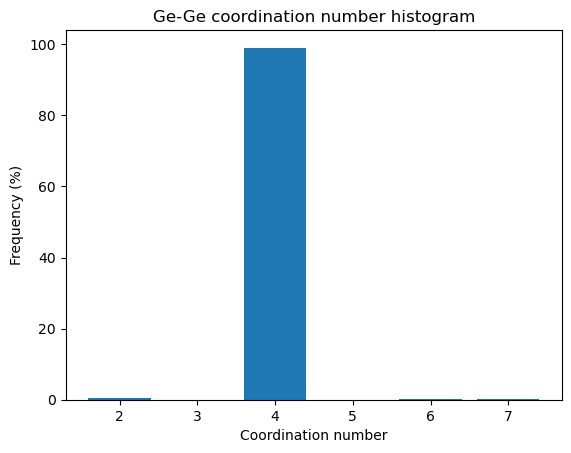

In [44]:
ge_atoms = rmc6f.read_rmc6f(filepath+'/net/move/ge_net.rmc6f')
print('Ge coordination number after move and rerun ')
coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', min_distance, max_distance)

### ge_o_network

In [57]:
ge_atoms = rmc6f.read_rmc6f(filepath+'/net/ge_net.rmc6f')
geo2_atoms = add_oxygen_atoms_pbc(ge_atoms,min_distance,max_distance,filepath)

geo2_atoms_sub_box = view_sub_box(geo2_atoms, 15)

view(geo2_atoms_sub_box,viewer = 'x3d')

Number of O atoms added: 1403
Unit cell center: [16.11464131 15.95293005 15.87620654]
Sub-box bounds: [8.61464131 8.45293005 8.37620654] to [23.61464131 23.45293005 23.37620654]


Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 4.01
Coordination number 2: 0.29% 
Coordination number 4: 99.14% 
Coordination number 6: 0.29% 
Coordination number 7: 0.29% 


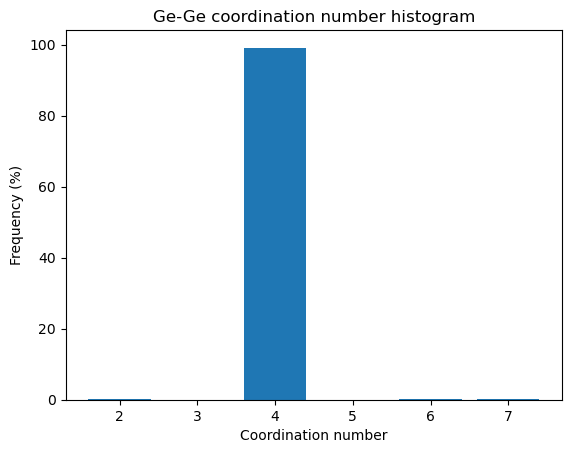

Average Ge-O coordination number 4.27
Coordination number 2: 0.29% 
Coordination number 4: 77.29% 
Coordination number 5: 18.43% 
Coordination number 6: 3.00% 
Coordination number 7: 0.86% 
Coordination number 8: 0.14% 


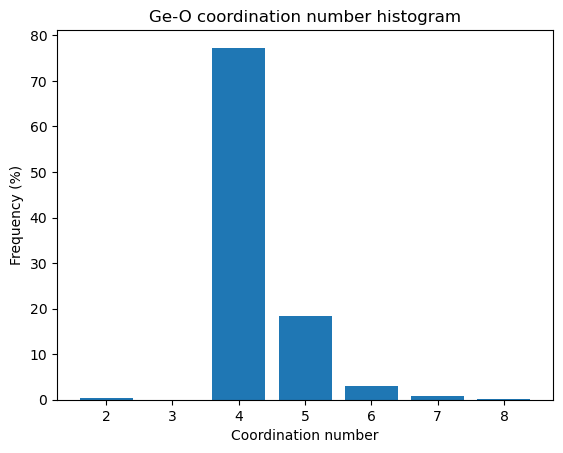

Average O-Ge coordination number 2.13
Coordination number 2: 87.10% 
Coordination number 3: 12.76% 
Coordination number 4: 0.14% 


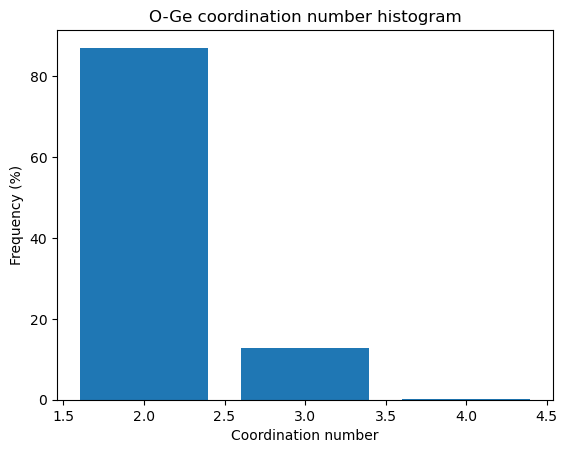

Average O-O coordination number 8.56
Coordination number 4: 0.14% 
Coordination number 5: 0.14% 
Coordination number 6: 5.56% 
Coordination number 7: 16.39% 
Coordination number 8: 30.08% 
Coordination number 9: 26.02% 
Coordination number 10: 12.12% 
Coordination number 11: 5.77% 
Coordination number 12: 2.49% 
Coordination number 13: 0.71% 
Coordination number 14: 0.29% 
Coordination number 15: 0.29% 


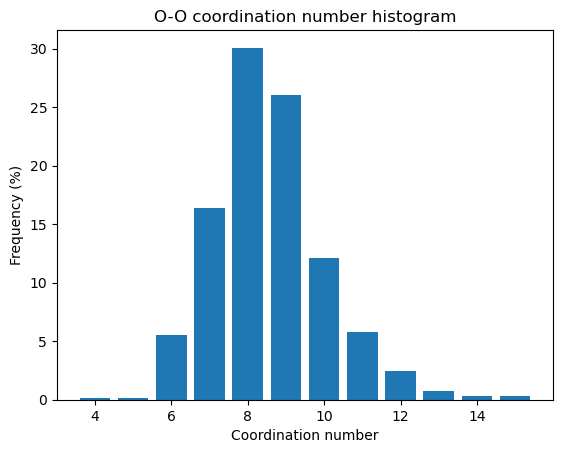

Average Ge-Ge distance:  2.91 +/- 0.01 Å
Average Ge-O distance:  1.46 +/- 0.005 Å
Average O-O distance:  2.372 +/- 0.006 Å
Average  Ge-O-Ge angle:  161.3 +/- 0.9 °
Average  O-Ge-O angle:  94.9 +/- 0.5 °


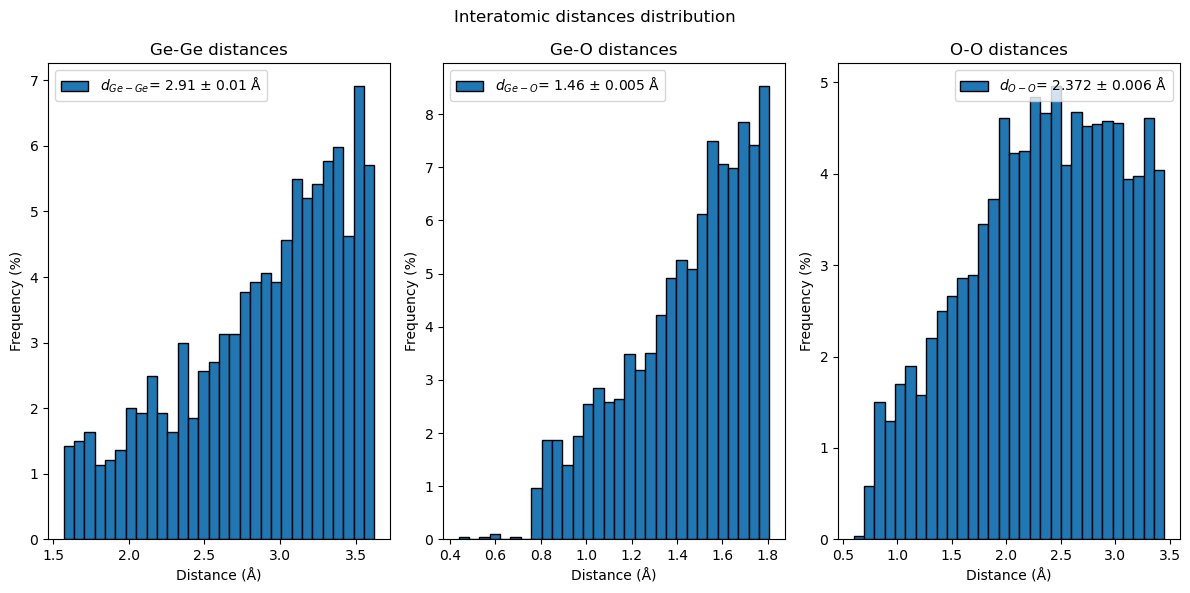

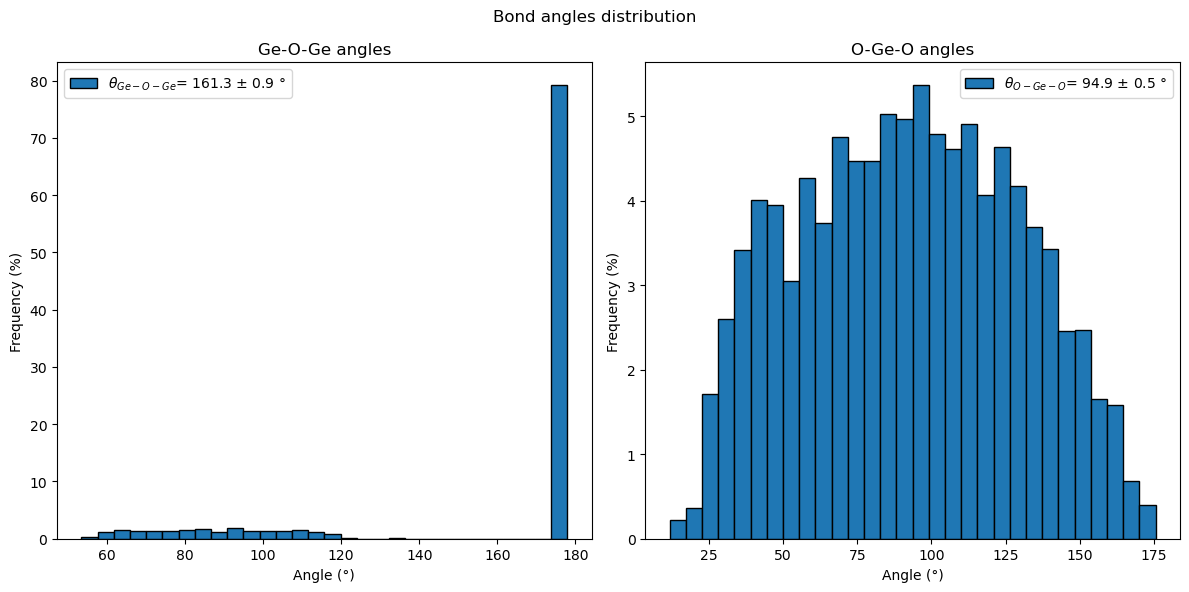

In [59]:
analyze_rmc(geo2_atoms, 'Ge','O',[max_distance, max_distance/2, 3.5],30)

### ge_o_network random

In [54]:
ge_atoms = rmc6f.read_rmc6f(filepath+'/net/ge_net.rmc6f')
geo2_atoms = add_oxygen_atoms_pbc_random(ge_atoms,min_distance,max_distance,filepath,0.1)

geo2_atoms_sub_box = view_sub_box(geo2_atoms, 15)

view(geo2_atoms_sub_box,viewer = 'x3d')

Number of O atoms added: 1403
Unit cell center: [16.11439811 15.95210419 15.87551897]
Sub-box bounds: [8.61439811 8.45210419 8.37551897] to [23.61439811 23.45210419 23.37551897]


Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 4.01
Coordination number 2: 0.29% 
Coordination number 4: 99.14% 
Coordination number 6: 0.29% 
Coordination number 7: 0.29% 


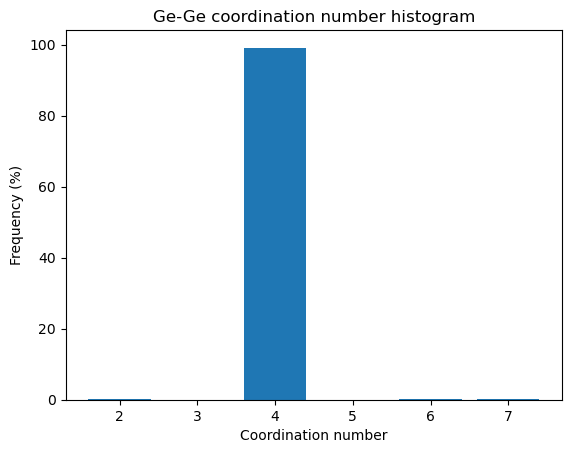

Average Ge-O coordination number 4.34
Coordination number 2: 0.29% 
Coordination number 4: 73.00% 
Coordination number 5: 20.29% 
Coordination number 6: 5.43% 
Coordination number 7: 0.71% 
Coordination number 8: 0.29% 


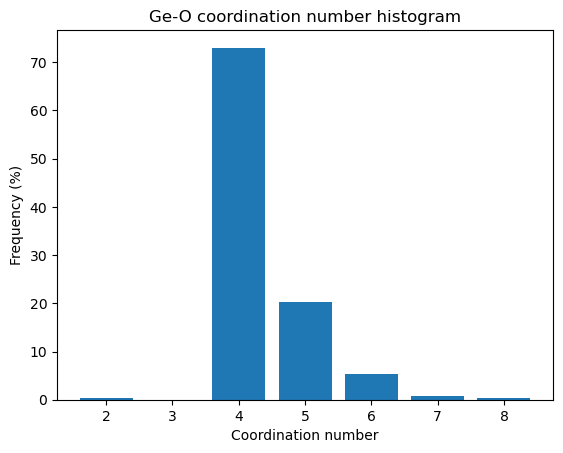

Average O-Ge coordination number 2.16
Coordination number 2: 83.82% 
Coordination number 3: 15.89% 
Coordination number 4: 0.29% 


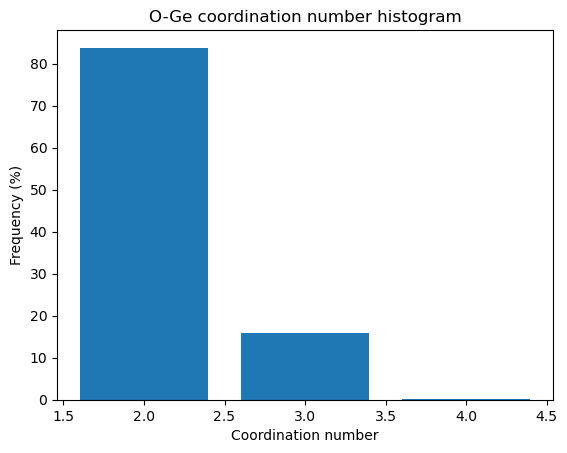

Average O-O coordination number 8.57
Coordination number 4: 0.14% 
Coordination number 5: 0.21% 
Coordination number 6: 5.35% 
Coordination number 7: 16.04% 
Coordination number 8: 30.65% 
Coordination number 9: 26.09% 
Coordination number 10: 11.83% 
Coordination number 11: 5.99% 
Coordination number 12: 2.49% 
Coordination number 13: 0.57% 
Coordination number 14: 0.36% 
Coordination number 15: 0.29% 


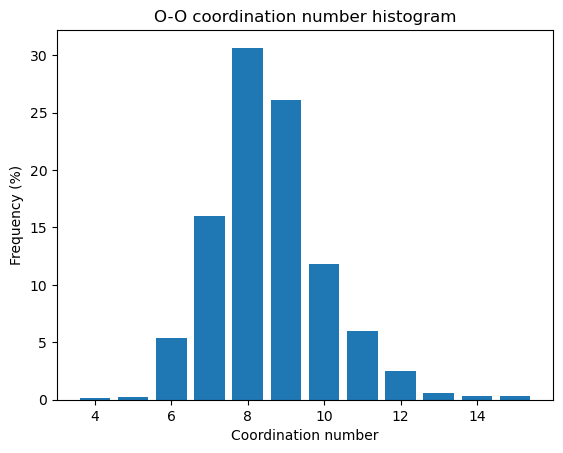

Average Ge-Ge distance:  2.91 +/- 0.01 Å
Average Ge-O distance:  1.466 +/- 0.005 Å
Average O-O distance:  2.372 +/- 0.006 Å
Average  Ge-O-Ge angle:  157.6 +/- 0.9 °
Average  O-Ge-O angle:  94.0 +/- 0.5 °


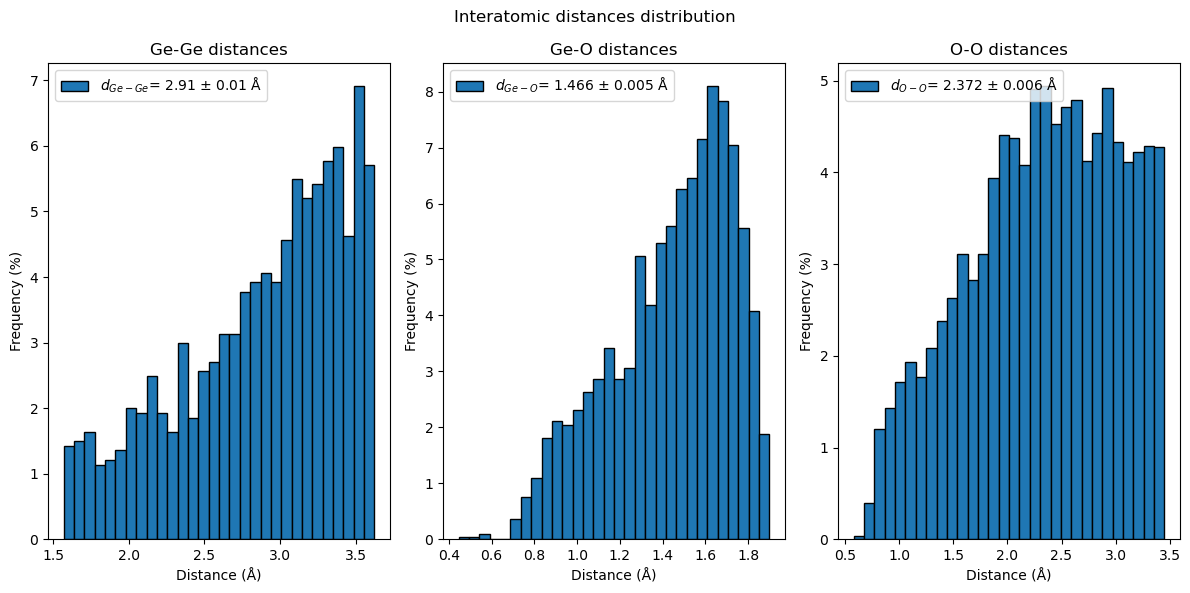

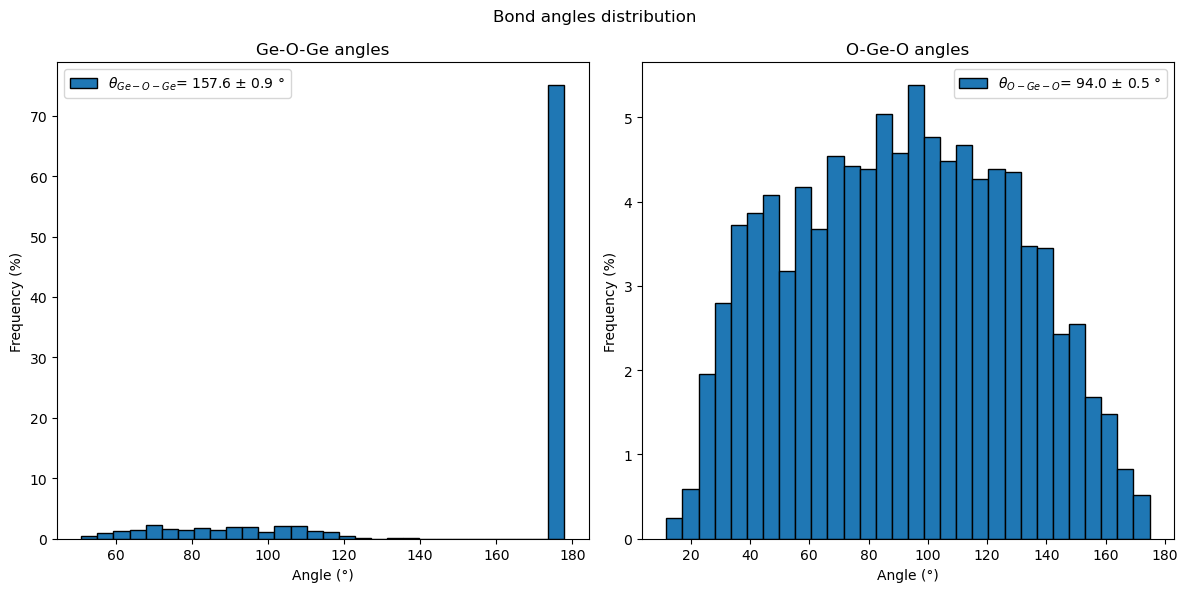

In [56]:
analyze_rmc(geo2_atoms, 'Ge','O',[max_distance, max_distance/2+0.1, 3.5],30)

### simulation

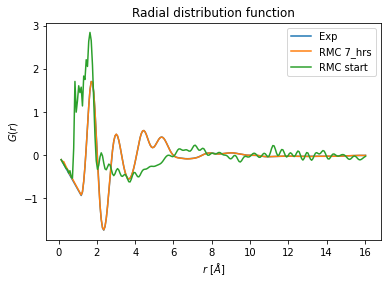

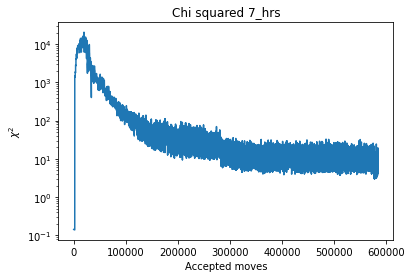

In [17]:
filepath = 'Zanatta_CI/ge_o_network/gdr/o_midpt'
directories =['7_hrs','start']
check_RMC_simulation(filepath,directories,'ge_o_network','gdr',3)

Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 3.22
Coordination number 0: 0.71% 
Coordination number 1: 7.43% 
Coordination number 2: 19.86% 
Coordination number 3: 29.57% 
Coordination number 4: 28.57% 
Coordination number 5: 11.14% 
Coordination number 6: 2.57% 
Coordination number 7: 0.14% 


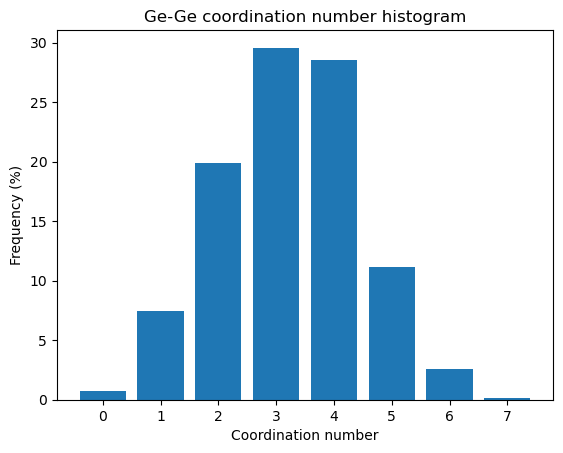

Average Ge-O coordination number 2.41
Coordination number 0: 2.86% 
Coordination number 1: 15.86% 
Coordination number 2: 32.57% 
Coordination number 3: 35.57% 
Coordination number 4: 12.14% 
Coordination number 5: 1.00% 


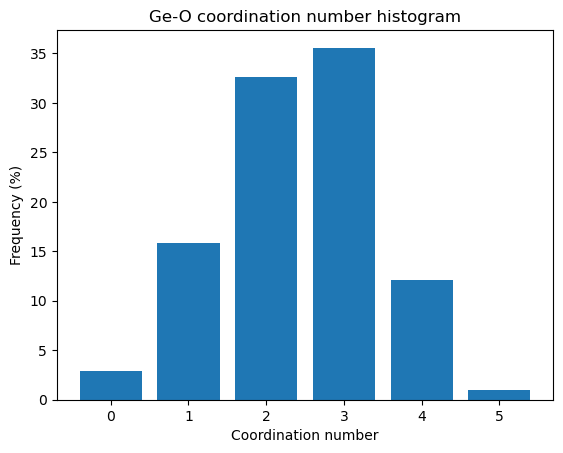

Average O-Ge coordination number 1.20
Coordination number 0: 15.82% 
Coordination number 1: 48.54% 
Coordination number 2: 35.07% 
Coordination number 3: 0.57% 


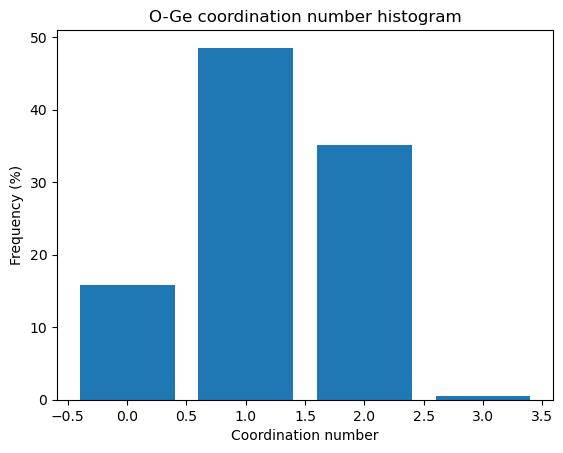

Average O-O coordination number 6.76
Coordination number 1: 0.07% 
Coordination number 2: 0.57% 
Coordination number 3: 1.78% 
Coordination number 4: 6.63% 
Coordination number 5: 15.18% 
Coordination number 6: 18.75% 
Coordination number 7: 23.02% 
Coordination number 8: 18.32% 
Coordination number 9: 11.19% 
Coordination number 10: 3.28% 
Coordination number 11: 1.07% 
Coordination number 12: 0.14% 


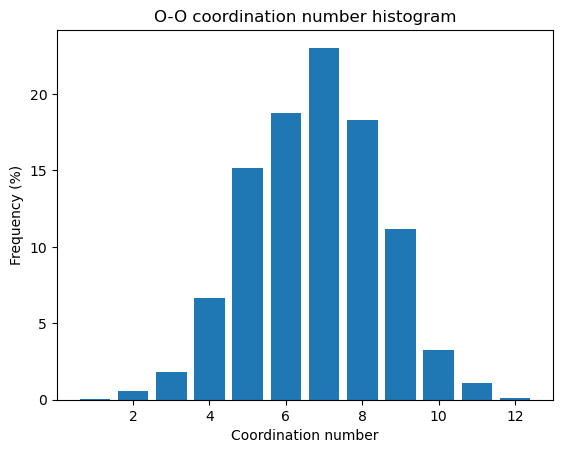

Average Ge-Ge distance:  3.13 +/- 0.008 Å
Average Ge-O distance:  1.669 +/- 0.005 Å
Average O-O distance:  2.763 +/- 0.006 Å
Average  Ge-O-Ge angle:  129.0 +/- 1.0 °
Average  O-Ge-O angle:  101.5 +/- 0.9 °


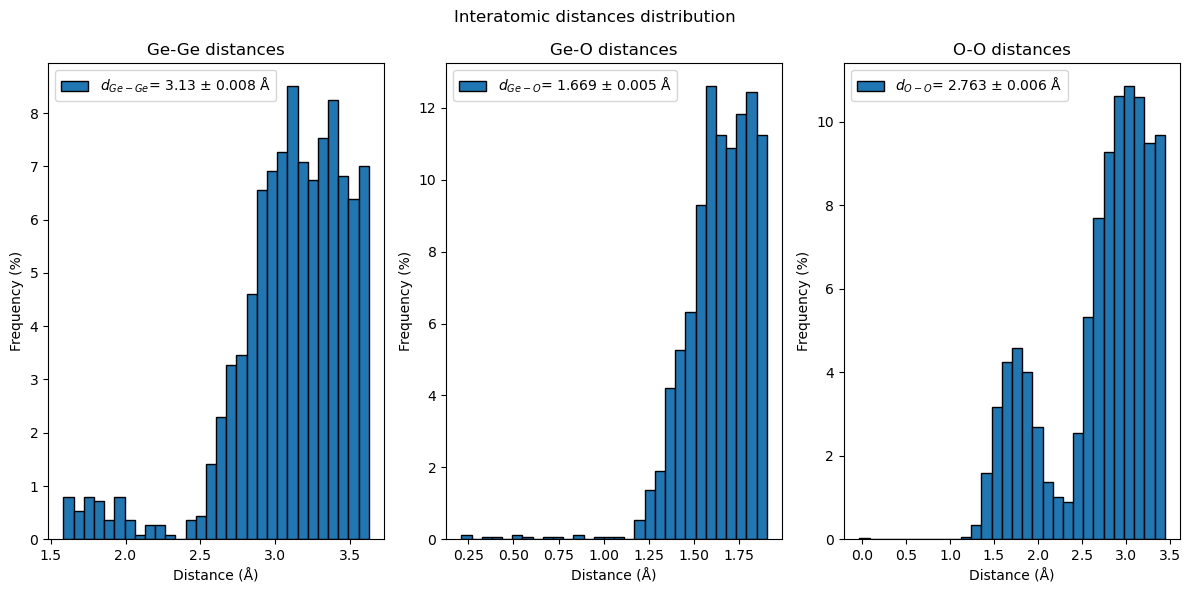

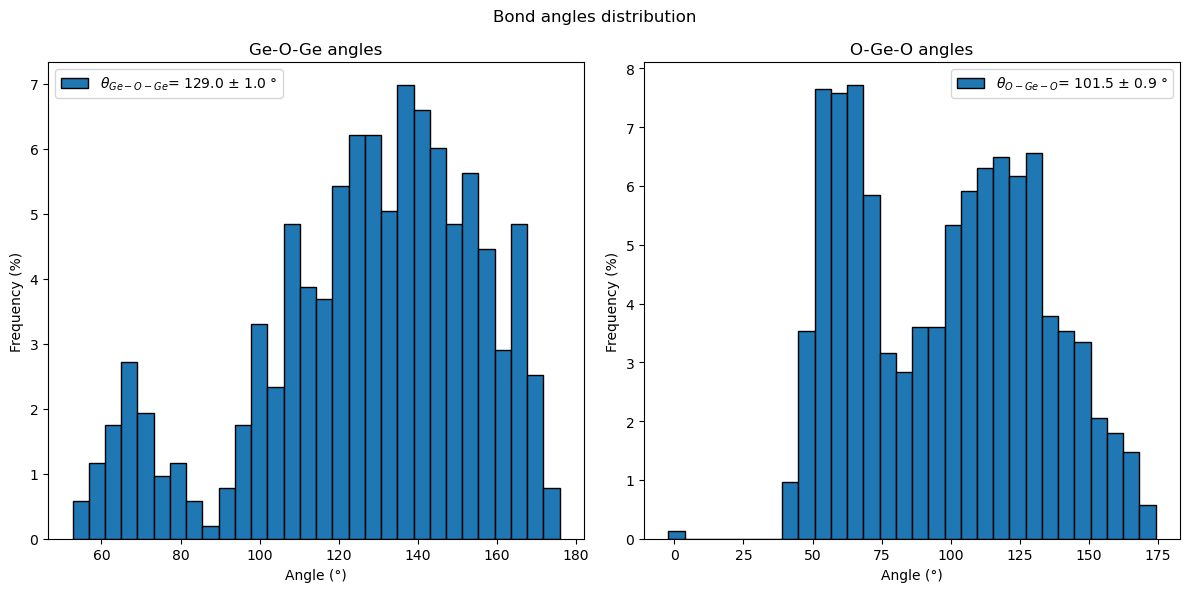

In [80]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/7_hrs/ge_o_network.rmc6f')
analyze_rmc(geo2_atoms, 'Ge','O',[max_distance, max_distance/2+0.1, 3.5],30)

In [81]:
geo2_atoms_sub_box = view_sub_box(geo2_atoms, 15)

view(geo2_atoms_sub_box,viewer = 'x3d')

Unit cell center: [16.23968262 15.88050514 15.73341037]
Sub-box bounds: [8.73968262 8.38050514 8.23341037] to [23.73968262 23.38050514 23.23341037]


### simulation random

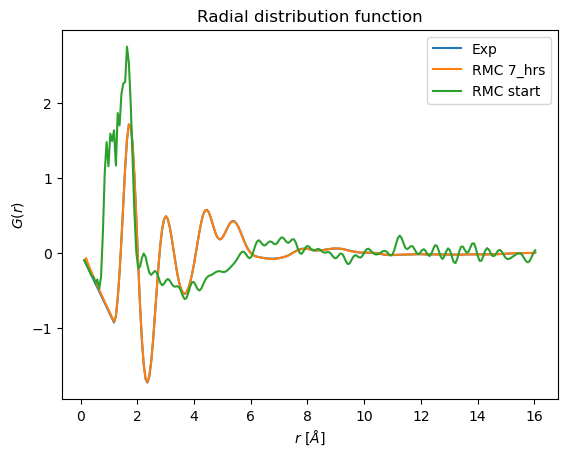

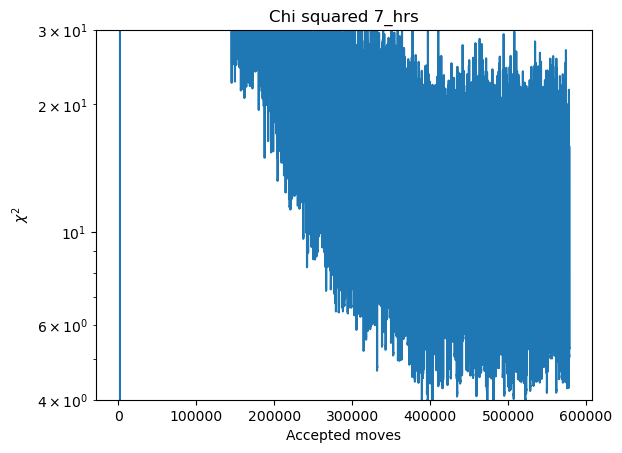

In [91]:
filepath = 'Zanatta_CI/ge_o_network/gdr/o_random'
directories =['7_hrs','start']
check_RMC_simulation(filepath,directories,'ge_o_network','gdr',[3,4e0,3e1])

Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 3.25
Coordination number 0: 2.14% 
Coordination number 1: 4.71% 
Coordination number 2: 19.71% 
Coordination number 3: 30.29% 
Coordination number 4: 28.00% 
Coordination number 5: 13.43% 
Coordination number 6: 1.57% 
Coordination number 7: 0.14% 


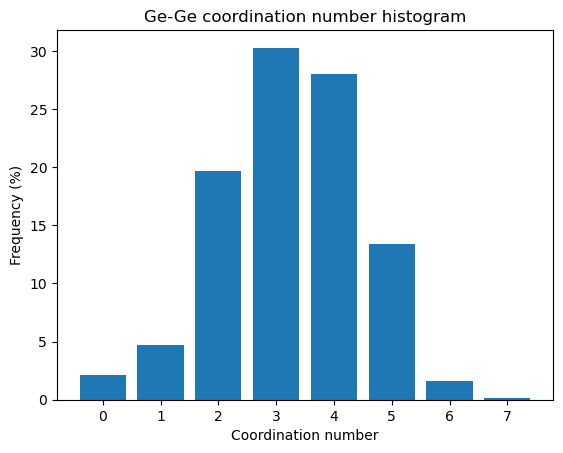

Average Ge-O coordination number 2.42
Coordination number 0: 2.14% 
Coordination number 1: 17.71% 
Coordination number 2: 33.00% 
Coordination number 3: 31.71% 
Coordination number 4: 13.86% 
Coordination number 5: 1.29% 
Coordination number 6: 0.29% 


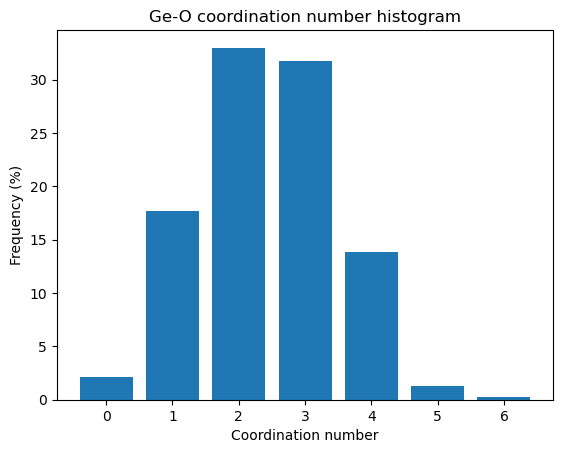

Average O-Ge coordination number 1.21
Coordination number 0: 15.40% 
Coordination number 1: 48.82% 
Coordination number 2: 35.21% 
Coordination number 3: 0.57% 


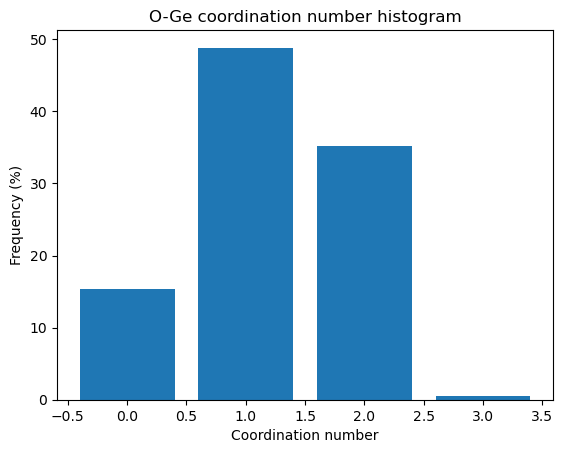

Average O-O coordination number 6.75
Coordination number 1: 0.07% 
Coordination number 2: 0.50% 
Coordination number 3: 2.00% 
Coordination number 4: 7.34% 
Coordination number 5: 13.04% 
Coordination number 6: 21.24% 
Coordination number 7: 21.95% 
Coordination number 8: 18.89% 
Coordination number 9: 9.27% 
Coordination number 10: 4.78% 
Coordination number 11: 0.78% 
Coordination number 12: 0.07% 
Coordination number 13: 0.07% 


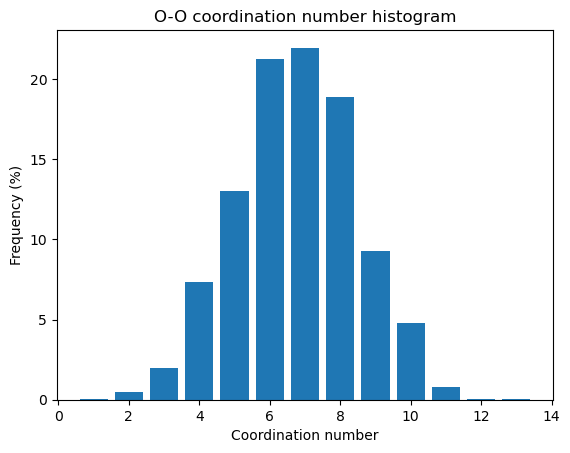

Average Ge-Ge distance:  3.132 +/- 0.008 Å
Average Ge-O distance:  1.671 +/- 0.005 Å
Average O-O distance:  2.766 +/- 0.006 Å
Average  Ge-O-Ge angle:  131.0 +/- 1.0 °
Average  O-Ge-O angle:  101.8 +/- 0.8 °


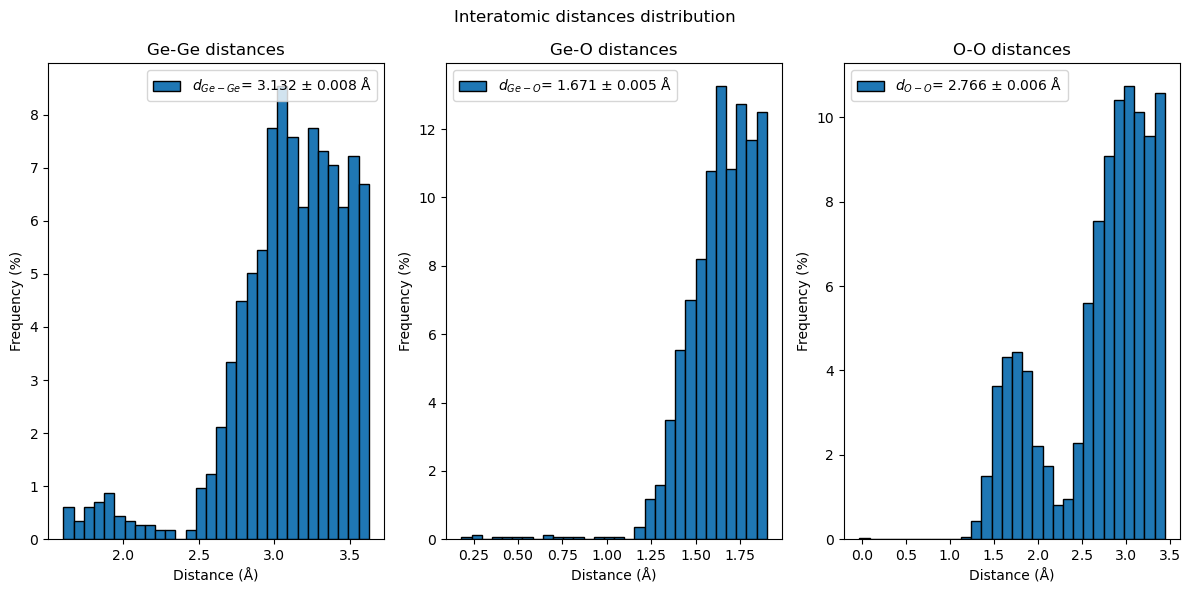

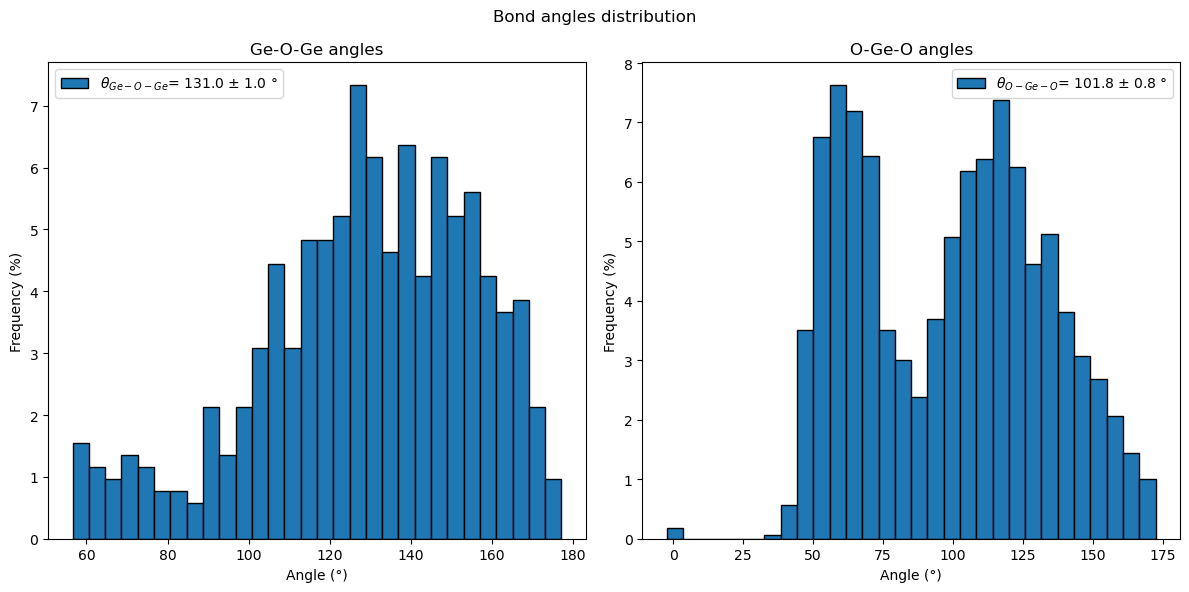

In [88]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/7_hrs/ge_o_network.rmc6f')
analyze_rmc(geo2_atoms, 'Ge','O',[max_distance, max_distance/2+0.1, 3.5],30)

In [86]:
geo2_atoms_sub_box = view_sub_box(geo2_atoms, 15)

view(geo2_atoms_sub_box,viewer = 'x3d')

Unit cell center: [16.15208255 15.88119891 15.79482165]
Sub-box bounds: [8.65208255 8.38119891 8.29482165] to [23.65208255 23.38119891 23.29482165]


### Simulations $G(r)$ and $S(Q)$

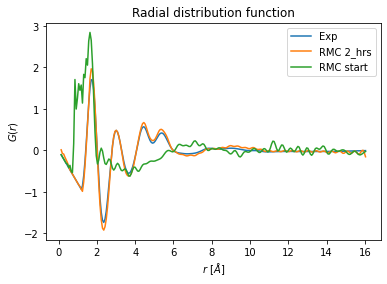

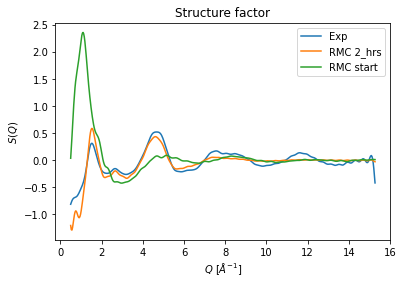

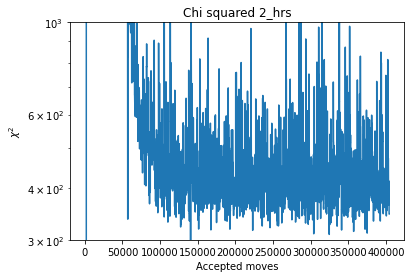

In [61]:
filepath = 'Zanatta_CI/ge_o_network/gdr_sdq/o_midpt'
directories =['2_hrs','start']
check_RMC_simulation(filepath,directories,'ge_o_network','both',[3,3e2,1e3])

Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 3.20
Coordination number 0: 1.14% 
Coordination number 1: 5.14% 
Coordination number 2: 19.43% 
Coordination number 3: 34.29% 
Coordination number 4: 28.29% 
Coordination number 5: 10.29% 
Coordination number 6: 1.14% 
Coordination number 7: 0.29% 


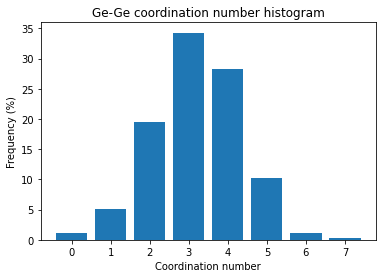

Average Ge-O coordination number 3.10
Coordination number 0: 0.71% 
Coordination number 1: 5.43% 
Coordination number 2: 19.86% 
Coordination number 3: 36.86% 
Coordination number 4: 31.71% 
Coordination number 5: 5.43% 


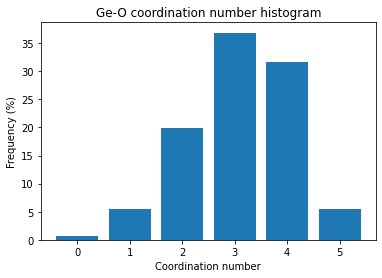

Average O-Ge coordination number 1.55
Coordination number 0: 5.06% 
Coordination number 1: 36.71% 
Coordination number 2: 56.88% 
Coordination number 3: 1.35% 


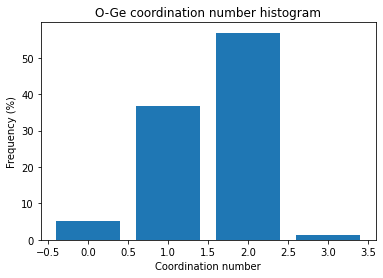

Average O-O coordination number 6.80
Coordination number 1: 0.14% 
Coordination number 2: 0.57% 
Coordination number 3: 1.43% 
Coordination number 4: 5.35% 
Coordination number 5: 13.68% 
Coordination number 6: 20.31% 
Coordination number 7: 27.23% 
Coordination number 8: 15.82% 
Coordination number 9: 10.33% 
Coordination number 10: 3.92% 
Coordination number 11: 1.07% 
Coordination number 12: 0.14% 


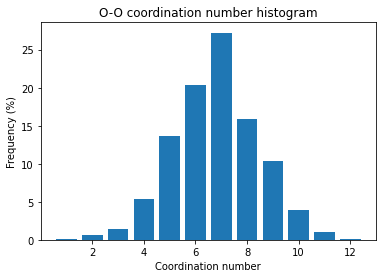

Average Ge-Ge distance:  3.17 +/- 0.008 Å
Average Ge-O distance:  1.734 +/- 0.005 Å
Average O-O distance:  2.742 +/- 0.006 Å
Average  Ge-O-Ge angle:  134.5 +/- 0.9 °
Average  O-Ge-O angle:  99.9 +/- 0.6 °


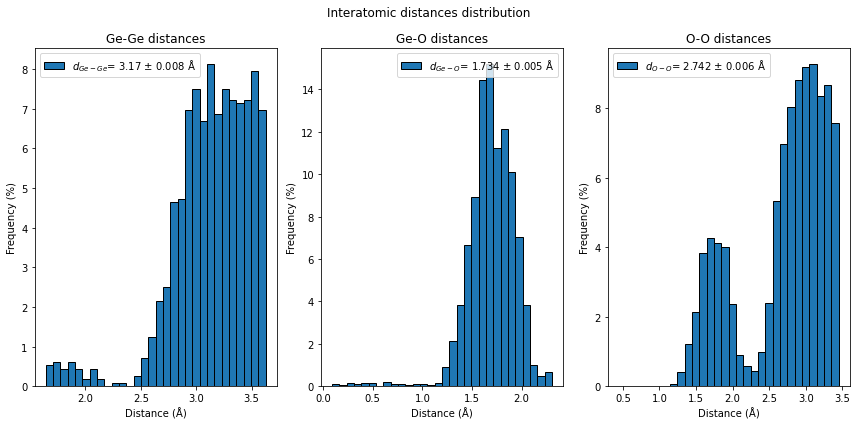

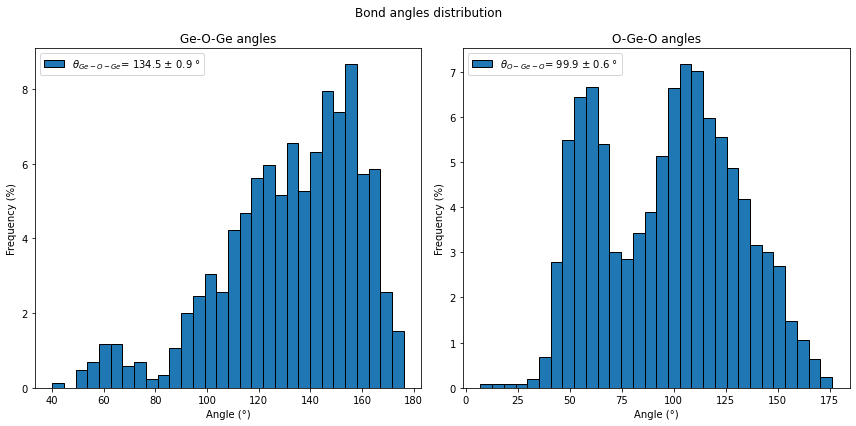

In [55]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/2_hrs/ge_o_network.rmc6f')
analyze_rmc(geo2_atoms, 'Ge','O',[max_distance,2.35, 3.5],30)

In [ ]:
geo2_atoms_sub_box = view_sub_box(geo2_atoms, 15)

view(geo2_atoms_sub_box,viewer = 'x3d')

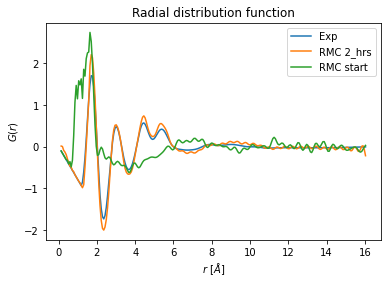

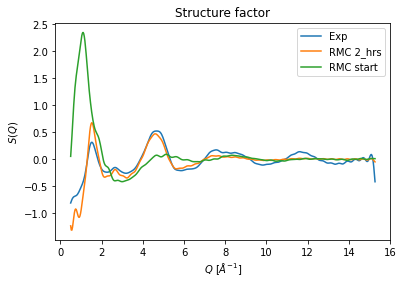

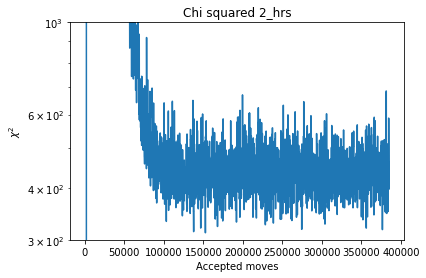

In [60]:
filepath = 'Zanatta_CI/ge_o_network/gdr_sdq/o_random'
directories =['2_hrs','start']
check_RMC_simulation(filepath,directories,'ge_o_network','both',[3,3e2,1e3])

Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 3.07
Coordination number 0: 1.14% 
Coordination number 1: 7.57% 
Coordination number 2: 20.43% 
Coordination number 3: 34.71% 
Coordination number 4: 27.71% 
Coordination number 5: 6.57% 
Coordination number 6: 1.86% 


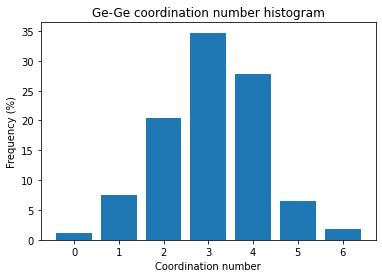

Average Ge-O coordination number 2.51
Coordination number 0: 2.57% 
Coordination number 1: 14.43% 
Coordination number 2: 31.71% 
Coordination number 3: 33.43% 
Coordination number 4: 16.86% 
Coordination number 5: 1.00% 


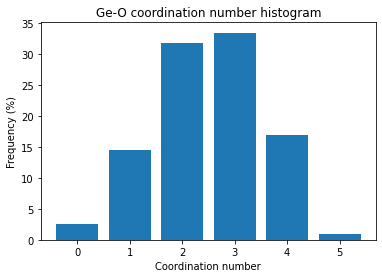

Average O-Ge coordination number 1.25
Coordination number 0: 14.11% 
Coordination number 1: 47.26% 
Coordination number 2: 38.13% 
Coordination number 3: 0.50% 


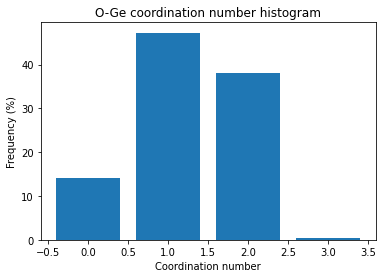

Average O-O coordination number 6.78
Coordination number 1: 0.14% 
Coordination number 2: 0.57% 
Coordination number 3: 1.35% 
Coordination number 4: 5.49% 
Coordination number 5: 12.76% 
Coordination number 6: 22.59% 
Coordination number 7: 25.02% 
Coordination number 8: 19.10% 
Coordination number 9: 8.20% 
Coordination number 10: 3.49% 
Coordination number 11: 1.00% 
Coordination number 12: 0.29% 


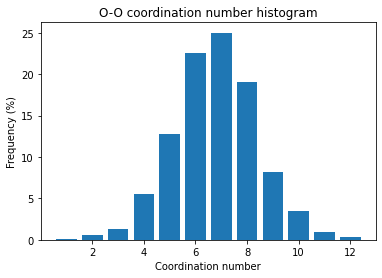

Average Ge-Ge distance:  3.149 +/- 0.008 Å
Average Ge-O distance:  1.656 +/- 0.005 Å
Average O-O distance:  2.724 +/- 0.006 Å
Average  Ge-O-Ge angle:  138.0 +/- 1.0 °
Average  O-Ge-O angle:  101.2 +/- 0.8 °


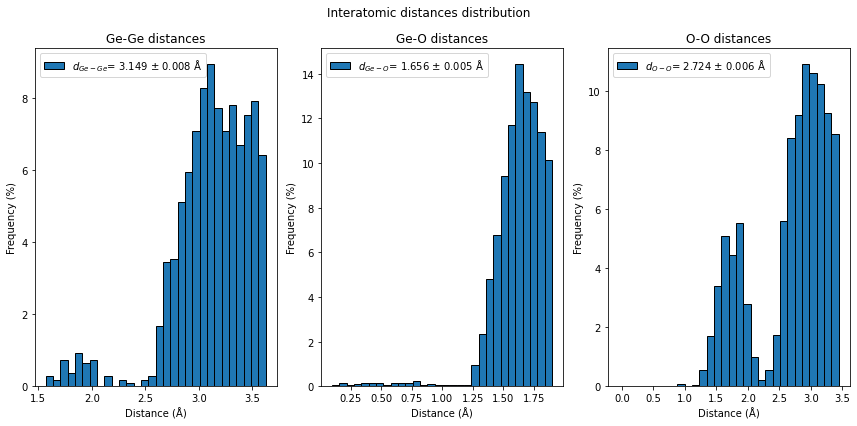

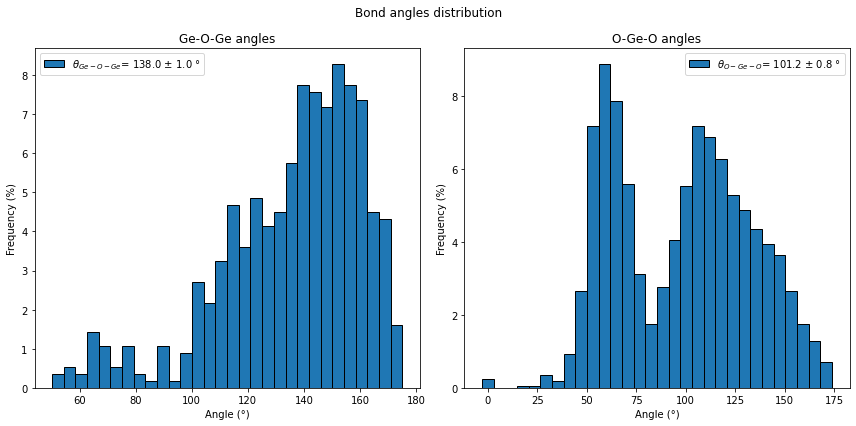

In [51]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/2_hrs/ge_o_network.rmc6f')
analyze_rmc(geo2_atoms, 'Ge','O',[max_distance, max_distance/2+0.1, 3.5],30)

In [52]:
geo2_atoms_sub_box = view_sub_box(geo2_atoms, 15)

view(geo2_atoms_sub_box,viewer = 'x3d')

Unit cell center: [16.18253112 15.83368917 15.69293736]
Sub-box bounds: [8.68253112 8.33368917 8.19293736] to [23.68253112 23.33368917 23.19293736]


In [ ]:
'''from pythreejs import *

# Function to find nearest neighbors using ASE's neighbor_list
def find_nearest_neighbors(atoms, cutoff):
    i, j, S = neighbor_list('ijS', atoms, cutoff)
    pairs = [(i_, j_) for i_, j_ in zip(i, j) if i_ < j_]
    return pairs

# Function to draw lines between nearest neimport pandas as pdighbors
def draw_lines(atoms, pairs):
    lines = []
    for i, j in pairs:
        start = atoms.positions[i]
        end = atoms.positions[j]
        line = Line(
            geometry=BufferGeometry(
                attributes={
                    'position': BufferAttribute(np.array([start, end], dtype=np.float32))
                }import pandas as pd
            ),
            material=LineBasicMaterial(color='blue')
        )
        lines.append(line)
    return lines

# Function to visualize atoms and lines
def visualize_atoms_and_lines(atoms, lines):
    atom_positions = atoms.positions
    atom_colors = np.array([[1, 0, 0] for _ in atoms])  # Example: all atoms red

    atom_geometry = BufferGeometry(
        attributes={
            'position': BufferAttribute(atom_positions, normalized=False),
            'color': BufferAttribute(atom_colors, normalized=True)
        }import pandas as pd
    )

    atom_material = PointsMaterial(vertexColors='VertexColors', size=0.1)
    atom_points = Points(geometry=atom_geometry, material=atom_material)

    scene = Scene(children=[atom_points] + lines)
    camera = PerspectiveCamera(position=[0, 0, 50], up=[0, 0, 1], children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)])
    renderer = Renderer(camera=camera, scene=scene, controls=[OrbitControls(controlling=camera)], width=800, height=600)

    display(renderer)

pairs = find_nearest_neighbors(ge_atoms_sub_box,max_distance)
lines = draw_lines(ge_atoms_sub_box, pairs)
print(lines)
visualize_atoms_and_lines(ge_atoms_sub_box, lines)'''

Atoms(symbols='Ge72', pbc=True, cell=[32.182982, 32.182982, 32.182982])


/home/simo/anaconda3/lib/python3.11/site-packages/pythreejs/traits.py:257: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(3.0, 5.0,…

# CI crystal with correct density
Try with CI from .cif file of $\alpha-$quartz and then enlarge the box and dispalce the atoms to get correct density

In [86]:
def adjust_number_density(filepath, target_number_density, output_filepath):
    # Read the RMC6F file
    atoms = rmc6f.read_rmc6f(filepath)
    
    # Get the current cell and positions
    cell = atoms.get_cell()
    positions = atoms.get_positions()
    
    # Calculate the current volume and number density
    current_volume = np.linalg.det(cell)
    num_atoms = len(atoms)
    current_number_density = num_atoms / current_volume  # Number density = number of atoms / volume
    
    # Calculate the scaling factor to reach the target number density
    scaling_factor = (current_number_density / target_number_density) ** (1/3)
    
    # Scale the cell parameters
    new_cell = cell * scaling_factor
    
    # Scale the atomic positions
    new_positions = positions*scaling_factor
    # Create a new Atoms object with the new cell and positions
    new_atoms = Atoms(symbols=atoms.get_chemical_symbols(), positions=new_positions, cell=new_cell, pbc=True)
    
    # Write the new structure to an RMC6F file
    rmc6f.write_rmc6f(output_filepath, atoms=new_atoms)
    
    print(f"Adjusted number density from {current_number_density:.3f} atoms/Å^3 to {target_density:.3f} atoms/Å^3")
    return new_atoms

filepath = 'crystal_CI/'
filename = 'geo2_350K_crystal.rmc6f'
target_density = 3*n_geo2[0] #from molecular to atomic density 


#view(rmc6f.read_rmc6f(filepath+filename),viewer = 'x3d')



In [87]:
geo2_atoms = adjust_number_density(filepath+filename,target_density,filepath+'geo2_350K.rmc6f')

#view(geo2_atoms,viewer = 'x3d')

Adjusted number density from 0.074 atoms/Å^3 to 0.063 atoms/Å^3


Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 4.00
Coordination number 4: 100.00% 


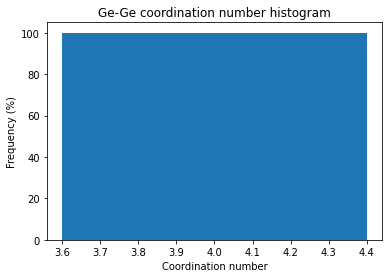

Average Ge-O coordination number 4.00
Coordination number 4: 100.00% 


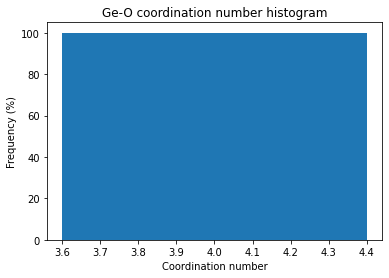

Average O-Ge coordination number 2.00
Coordination number 2: 100.00% 


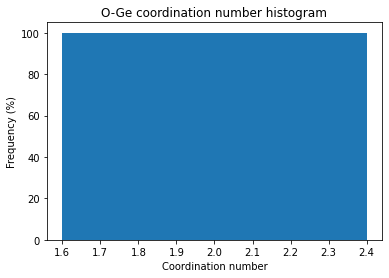

Average O-O coordination number 6.00
Coordination number 6: 100.00% 


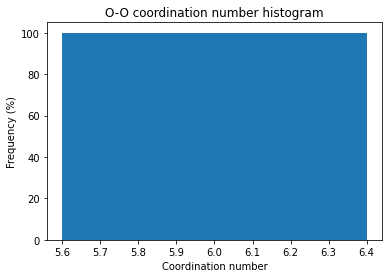

Average Ge-Ge distance:  3.3255164 +/- 3e-07 Å
Average Ge-O distance:  1.8337 +/- 8e-05 Å
Average O-O distance:  2.9938 +/- 0.0006 Å
Average  Ge-O-Ge angle:  130.12804 +/- 2e-05 °
Average  O-Ge-O angle:  109.49 +/- 0.05 °


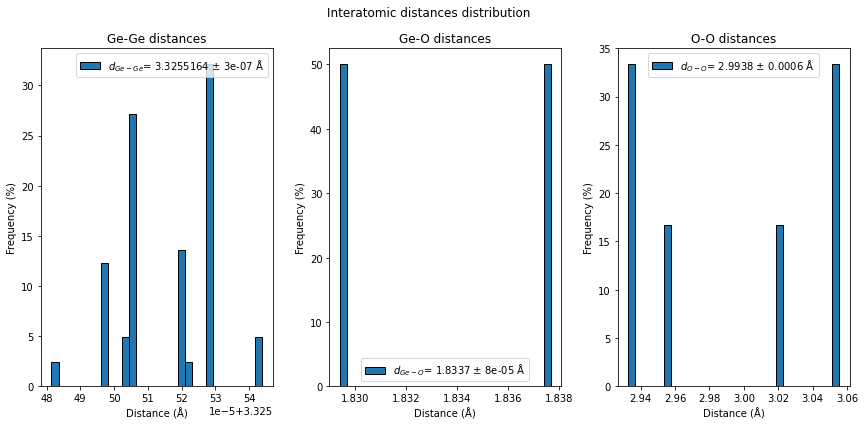

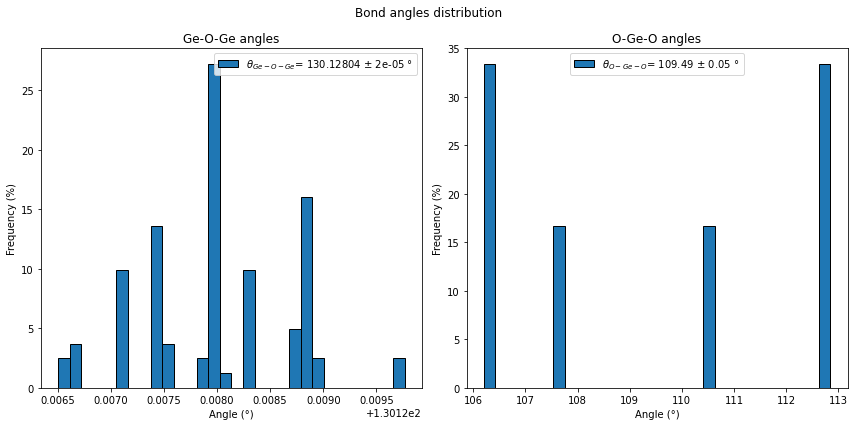

In [88]:
analyze_rmc(geo2_atoms, 'Ge','O',[3.6,2.35, 3.1],30)

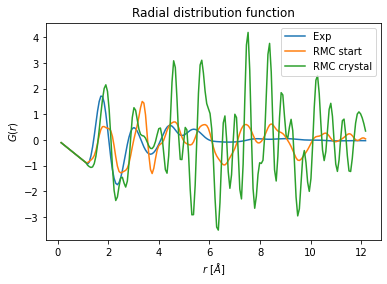

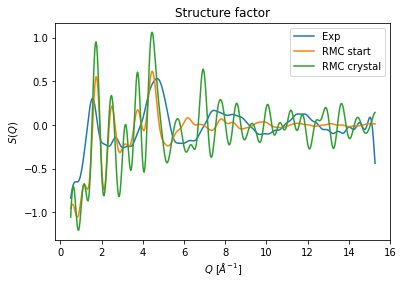

In [21]:
filepath = 'crystal_CI'
directories =['start','crystal']
check_RMC_simulation(filepath,directories,'geo2_350K','both',3)

Pairs computed
Angles computed
Histograms made
Average Ge-Ge coordination number 3.59
Coordination number 3: 44.75% 
Coordination number 4: 51.70% 
Coordination number 5: 3.09% 
Coordination number 6: 0.46% 


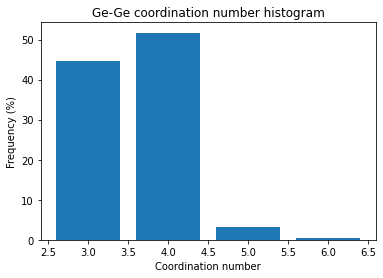

Average Ge-O coordination number 4.04
Coordination number 4: 95.99% 
Coordination number 5: 4.01% 


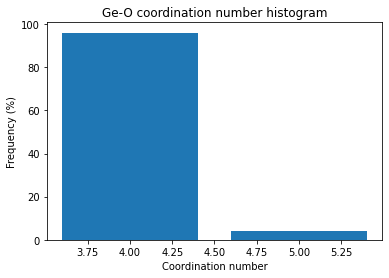

Average O-Ge coordination number 2.02
Coordination number 2: 97.99% 
Coordination number 3: 2.01% 


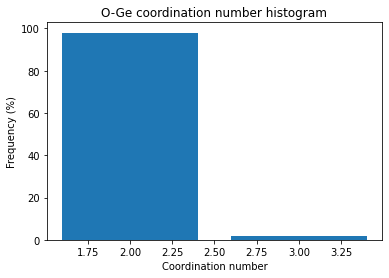

Average O-O coordination number 3.80
Coordination number 0: 0.77% 
Coordination number 1: 4.71% 
Coordination number 2: 12.89% 
Coordination number 3: 20.76% 
Coordination number 4: 28.55% 
Coordination number 5: 22.22% 
Coordination number 6: 8.56% 
Coordination number 7: 1.39% 
Coordination number 8: 0.15% 


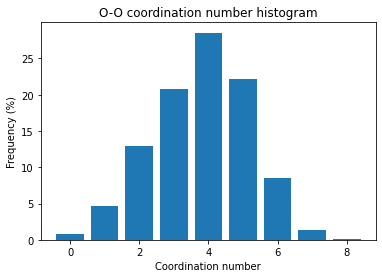

Average Ge-Ge distance:  3.334 +/- 0.004 Å
Average Ge-O distance:  1.933 +/- 0.005 Å
Average O-O distance:  2.826 +/- 0.003 Å
Average  Ge-O-Ge angle:  125.0 +/- 0.4 °
Average  O-Ge-O angle:  107.3 +/- 0.3 °


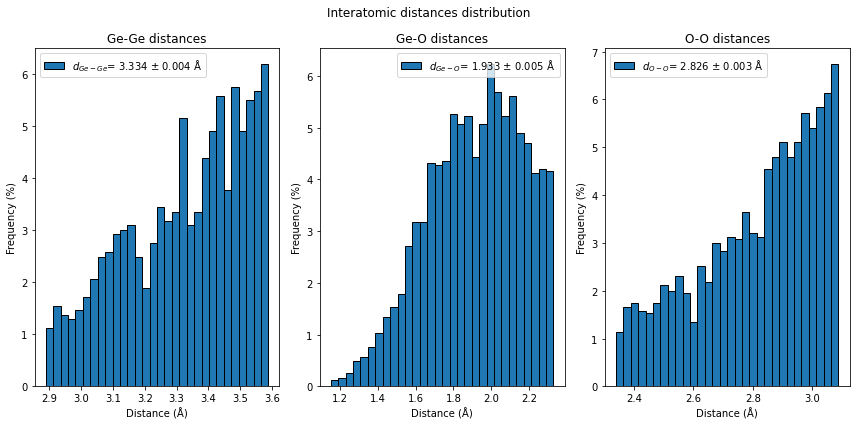

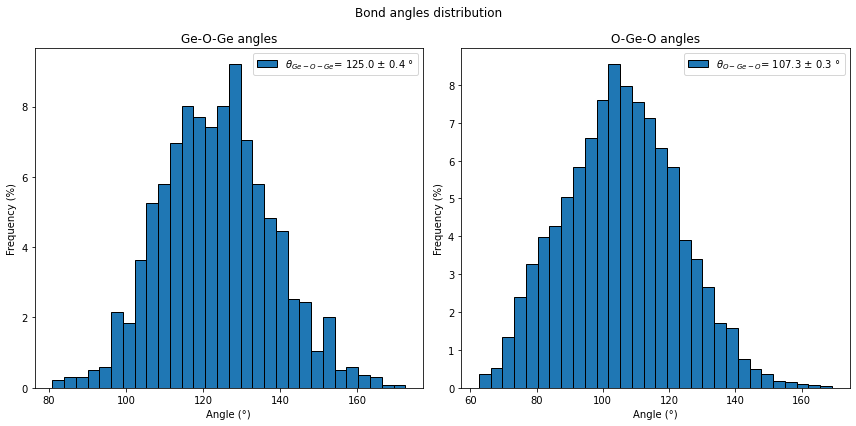

In [22]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/start/geo2_350K.rmc6f')
analyze_rmc(geo2_atoms, 'Ge','O',[3.6,2.35, 3.1],30)

# SiO $_2$

Pairs computed
Angles computed
Histograms made
Average Si-Si coordination number 3.96
Coordination number 0: 0.67% 
Coordination number 1: 4.00% 
Coordination number 2: 10.67% 
Coordination number 3: 23.33% 
Coordination number 4: 26.33% 
Coordination number 5: 18.33% 
Coordination number 6: 13.33% 
Coordination number 7: 3.00% 
Coordination number 8: 0.33% 


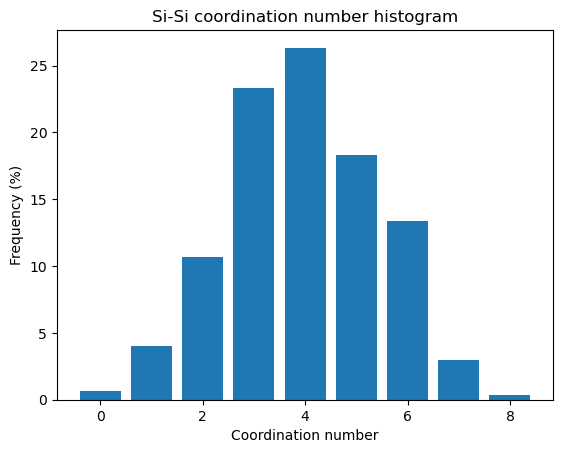

Average Si-O coordination number 2.95
Coordination number 0: 5.00% 
Coordination number 1: 13.67% 
Coordination number 2: 22.33% 
Coordination number 3: 13.67% 
Coordination number 4: 35.67% 
Coordination number 5: 6.33% 
Coordination number 6: 2.33% 
Coordination number 7: 0.67% 
Coordination number 8: 0.33% 


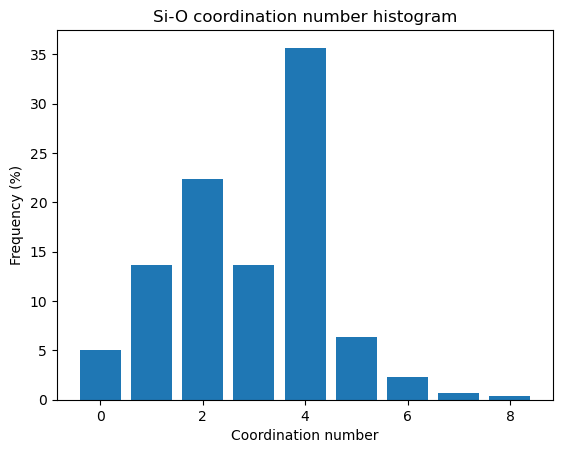

Average O-Si coordination number 1.72
Coordination number 0: 1.36% 
Coordination number 1: 25.10% 
Coordination number 2: 73.54% 


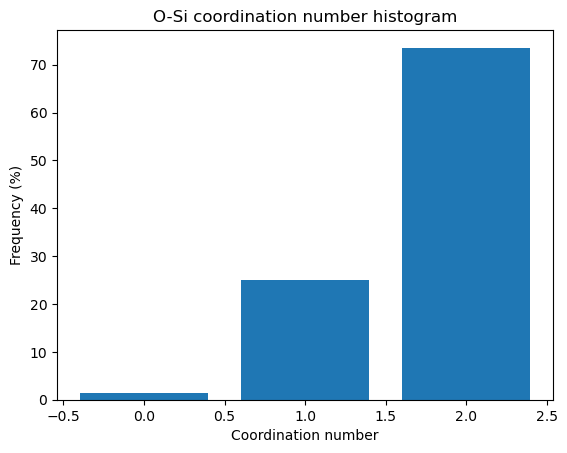

Average O-O coordination number 5.46
Coordination number 1: 1.56% 
Coordination number 2: 4.67% 
Coordination number 3: 11.67% 
Coordination number 4: 15.37% 
Coordination number 5: 20.43% 
Coordination number 6: 17.51% 
Coordination number 7: 12.26% 
Coordination number 8: 9.14% 
Coordination number 9: 3.70% 
Coordination number 10: 2.14% 
Coordination number 11: 0.97% 
Coordination number 12: 0.58% 


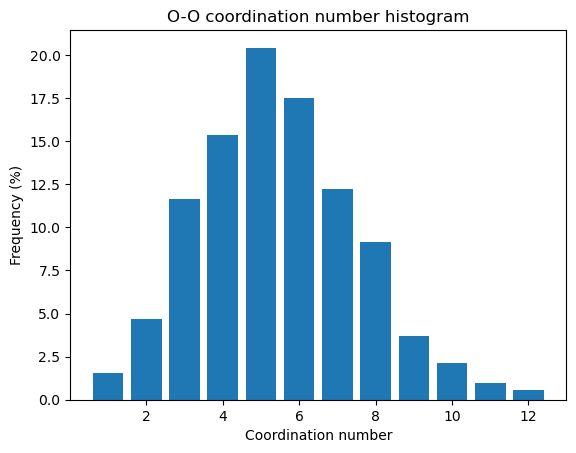

Average Si-Si distance:  3.1334 +/- 0.0009 Å
Average Si-O distance:  1.5995 +/- 0.0005 Å
Average O-O distance:  2.395 +/- 0.001 Å
Average  Si-O-Si angle:  152.7 +/- 0.2 °
Average  O-Si-O angle:  104.3 +/- 0.1 °


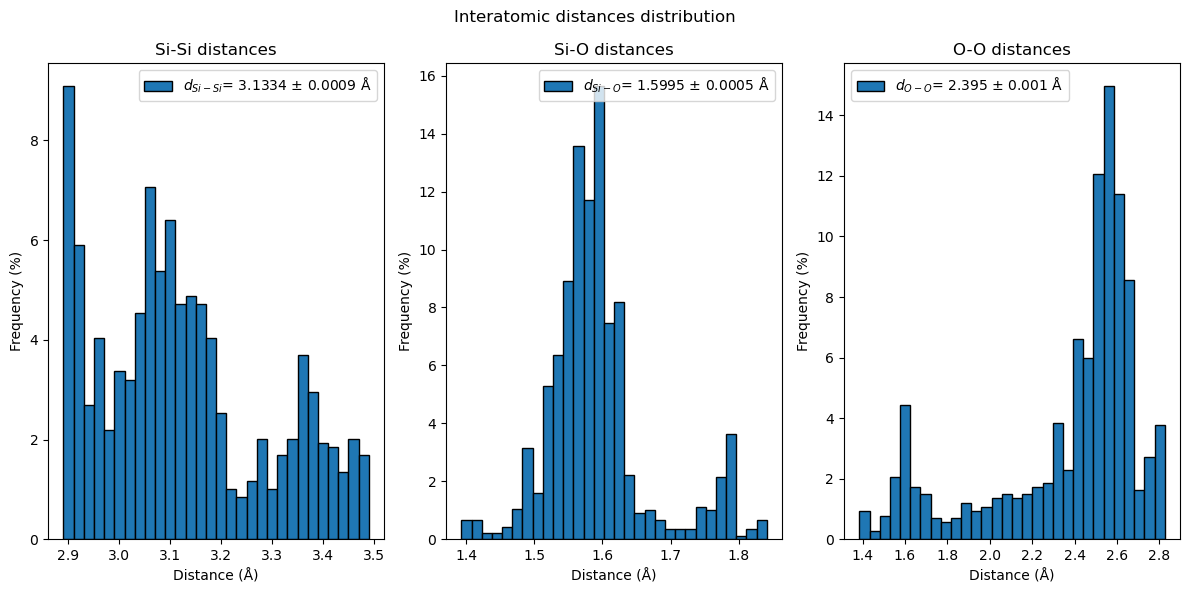

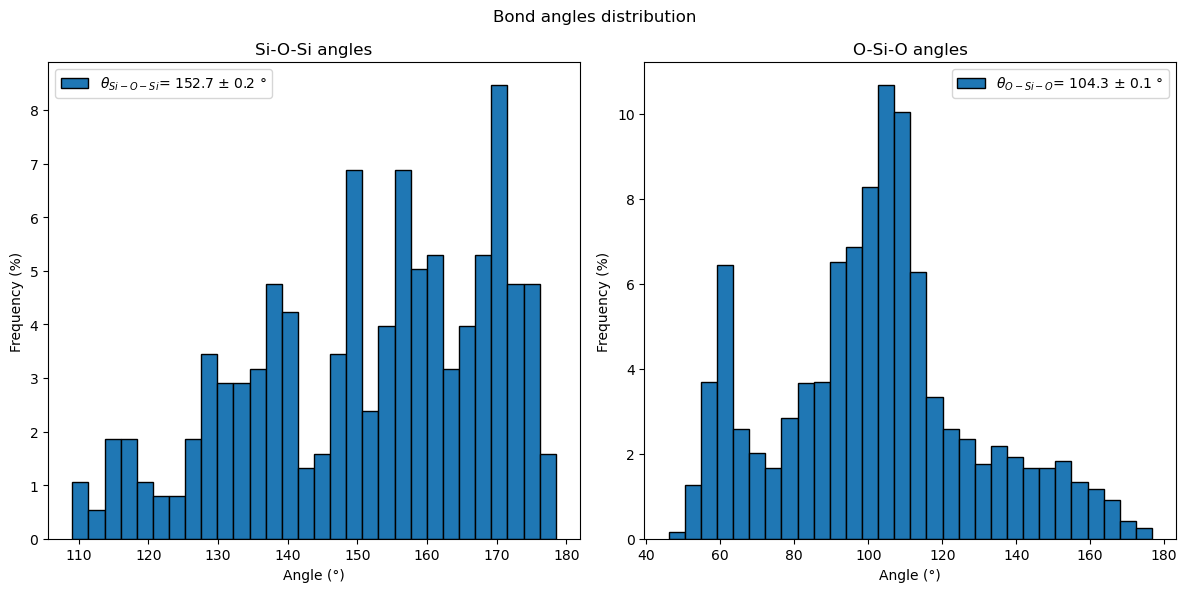

In [546]:
filepath= '../SiO2'

sio2 = rmc6f.read_rmc6f(filepath+'/start/sio2.rmc6f')

analyze_rmc(sio2,'Si','O', [3.5, 1.85, 2.85],30)


In [ ]:
sio2 = rmc6f.read_rmc6f(filepath+'/8h_run/sio2.rmc6f')
analyze_rmc(sio2,'Si','O', [3.5, 1.85, 2.85],30)

In [ ]:
filepath = 'pbc_rulez'
directories = ['rand','net']
config = check_configuration_building_pbc(filepath,directories,0,3.6)